In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

import warnings
warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-StepDecay-wd
Time: Tue Nov 17 20:05:26 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
14261  id_a6a4f3626  trt_cp       24      D2 -0.3265  0.1577 -0.3381  0.1789   
14266  id_a6b456ebb  trt_cp       24      D1 -0.7239  0.0713  0.2250  0.5864   
5119   id_3bd739795  trt_cp       24      D1  0.5283  1.2350  2.7150 -0.0206   
692    id_07b7426b2  trt_cp       24      D1 -0.2856 -0.6573  1.8890 -0.3083   
6833   id_4fbf1ada4  trt_cp       72      D2  0.9492 -0.5027 -0.0934 -2.2830   
7051   id_52620ac73  trt_cp       24      D1 -0.4717 -0.2592 -0.5129  0.0462   
13131  id_995a3b2d4  trt_cp       48      D1  2.4190 -1.1380 -0.4596 -0.1602   
2435   id_1c33757b3  trt_cp       24      D1 -0.0171 -0.0432 -0.4036 -0.6486   
10021  id_7514b50fb  trt_cp       48      D1  0.5772  0.8006  1.5080 -0.8161   
13768  id_a0ad27715  trt_cp       48      D2  0.2120  0.2485  1.0300 -1.0730   
18518  id_d7bb3adc4  trt_cp       48      D1 -0.7536 -0.5321 -0.1516 -0.0495   
20041  id_e91fab646  trt_cp       72      D2 -0.6309  0.4781 -2.6910  0.2385   
18117  id_d31c9e94e  trt_cp       48      D1  0.7976  1.0440  0.2952 -0.5905   
15504  id_b4cc111bb  trt_cp       48      D1 -0.5976 -1.1690 -0.4103  0.5798   
5556   id_412140e64  trt_cp       24      D1 -0.5952 -0.9559  2.4630 -0.0315   
21588  id_fbd8dbcad  trt_cp       72      D2 -0.2161 -1.4290  0.4589  1.0030   
15360  id_b31db9325  trt_cp       48      D1 -0.0374 -1.0160  1.9580 -0.4785   
11138  id_821c17c40  trt_cp       24      D2 -0.0261  0.1104 -0.1617 -0.3219   
8190   id_60006934f  trt_cp       48      D1  0.1364 -1.3170 -0.8553  0.1797   
2259   id_1a17c635a  trt_cp       72      D1 -1.0280 -0.8049 -1.0320  0.1032   

          g-4     g-5  ...  tropomyosin_receptor_kinase_inhibitor  \
14261  0.2595  0.7117  ...                                      0   
14266  2.6280 -0.4762  ...                                      0   
5119   0.5865  0.2824  ...                                      0   
692   -0.5899  0.5369  ...                                      0   
6833  -0.1903  0.0230  ...                                      0   
7051   0.5863 -0.6585  ...                                      0   
13131  2.5480  1.5230  ...                                      0   
2435  -0.7183 -0.5947  ...                                      0   
10021 -0.1879 -0.1965  ...                                      0   
13768 -0.0180 -1.7210  ...                                      0   
18518  1.0390  0.0809  ...                                      0   
20041 -0.3716 -1.7600  ...                                      0   
18117 -0.1289 -0.0398  ...                                      0   
15504 -1.1120 -0.5922  ...                                      0   
5556  -1.1080 -0.4219  ...                                      1   
21588 -0.4092 -0.3814  ...                                      0   
15360 -1.9240  0.4834  ...                                      0   
11138 -0.3690 -0.3912  ...                                      0   
8190  -0.3682  0.3688  ...                                      0   
2259  -1.0780  0.4771  ...                                      0   

       trpv_agonist  trpv_antagonist  tubulin_inhibitor  \
14261             0                0                  0   
14266             0                0                  0   
5119              0                0                  0   
692               0                0                  0   
6833              0                0                  0   
7051              0                0                  0   
13131             0                0                  0   
2435              0                0                  0   
10021             0                0                  0   
13768             0                0                  0   
18518             0                0                  0   
20041             0                0                  0   
18117             0                0                  0   
15504             0                0                  0 

# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 7e-3
    wd = 1e-3
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = None
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [14]:
import torch_optimizer

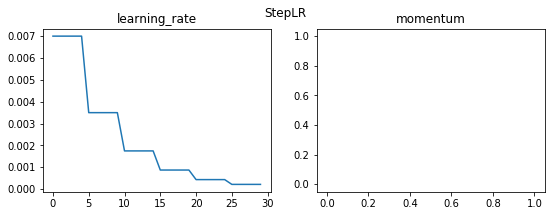

In [15]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Yogi
CFG.optim_param = optim_param

scheduler_param = {
    'step_size': 5, 
    'gamma': 0.5
}
CFG.scheduler = optim.lr_scheduler.StepLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# optimizer

In [16]:
from tabulate import tabulate
from colorama import Fore, Back, Style

version_higher = (torch.__version__ >= "1.5.0")

class AdaBelief(Optimizer):
    r"""Implements AdaBelief algorithm. Modified from Adam in PyTorch
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-16)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
        weight_decouple (boolean, optional): ( default: True) If set as True, then
            the optimizer uses decoupled weight decay as in AdamW
        fixed_decay (boolean, optional): (default: False) This is used when weight_decouple
            is set as True.
            When fixed_decay == True, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay$.
            When fixed_decay == False, the weight decay is performed as
            $W_{new} = W_{old} - W_{old} \times decay \times lr$. Note that in this case, the
            weight decay ratio decreases with learning rate (lr).
        rectify (boolean, optional): (default: True) If set as True, then perform the rectified
            update similar to RAdam
        degenerated_to_sgd (boolean, optional) (default:True) If set as True, then perform SGD update
            when variance of gradient is high
    reference: AdaBelief Optimizer, adapting stepsizes by the belief in observed gradients, NeurIPS 2020
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-16,
                 weight_decay=0,
                 amsgrad=False,
                 weight_decouple=True,
                 fixed_decay=False,
                 rectify=True,
                 degenerated_to_sgd=True):

        # ------------------------------------------------------------------------------
        # Print modifications to default arguments
        print(
            Fore.RED +
            'Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.'
        )
        print(Fore.RED + 'Modifications to default arguments:')
        default_table = tabulate(
            [['adabelief-pytorch=0.0.5', '1e-8', 'False', 'False'],
             ['Current version (0.1.0)', '1e-16', 'True', 'True']],
            headers=['eps', 'weight_decouple', 'rectify'])
        print(Fore.RED + default_table)

        print(Fore.RED +
              'For a complete table of recommended hyperparameters, see')
        print(Fore.RED +
              'https://github.com/juntang-zhuang/Adabelief-Optimizer')

        print(Style.RESET_ALL)
        # ------------------------------------------------------------------------------

        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad,
                        buffer=[[None, None, None] for _ in range(10)])
        super(AdaBelief, self).__init__(params, defaults)

        self.degenerated_to_sgd = degenerated_to_sgd
        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.fixed_decay = fixed_decay
        if self.weight_decouple:
            print('Weight decoupling enabled in AdaBelief')
            if self.fixed_decay:
                print('Weight decay fixed')
        if self.rectify:
            print('Rectification enabled in AdaBelief')
        if amsgrad:
            print('AMSGrad enabled in AdaBelief')

    def __setstate__(self, state):
        super(AdaBelief, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def reset(self):
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                amsgrad = group['amsgrad']

                # State initialization
                state['step'] = 0
                # Exponential moving average of gradient values
                state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                # Exponential moving average of squared gradient values
                state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                    if version_higher else torch.zeros_like(p.data)

                if amsgrad:
                    # Maintains max of all exp. moving avg. of sq. grad. values
                    state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdaBelief does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data,memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Update first and second moment running average
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_residual = grad - exp_avg
                exp_avg_var.mul_(beta2).addcmul_(grad_residual,
                                                 grad_residual,
                                                 value=1 - beta2)

                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var,
                              exp_avg_var,
                              out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_var.add_(group['eps']).sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2**state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (
                            1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                                (N_sma - 2) / N_sma * N_sma_max /
                                (N_sma_max - 2)) / (1 - beta1**state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1**state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg,
                                        denom,
                                        value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [17]:
class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                radam_step = p_data_fp32.clone()
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    radam_step.addcdiv_(-radam_step_size * group['lr'], exp_avg, denom)
                else:
                    radam_step.add_(-radam_step_size * group['lr'], exp_avg)

                radam_norm = radam_step.pow(2).sum().sqrt()
                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                if N_sma >= 5:
                    p_data_fp32.addcdiv_(-radam_step_size * group['lr'] * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step_size * group['lr'] * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

def Ranger(params, alpha=0.5, k=6, *args, **kwargs):
    radam = RAdam(params, *args, **kwargs)
    return Lookahead(radam, alpha, k)


def RangerLars(params, alpha=0.5, k=6, *args, **kwargs):
    ralamb = Ralamb(params, *args, **kwargs)
    return Lookahead(ralamb, alpha, k)

In [18]:
# CG
# https://github.com/Yonghongwei/Gradient-Centralization
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))),
                               keepdim=True))
    return x

class Adam_CG(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 amsgrad=False,
                 use_gc=False,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(Adam_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(Adam_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead'
                    )
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1
                #GC operation
                G_grad = exp_avg / denom
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class AdamW_CG(Optimizer):
    r"""Implements AdamW algorithm.
    The original Adam algorithm was proposed in `Adam: A Method for Stochastic Optimization`_.
    The AdamW variant was proposed in `Decoupled Weight Decay Regularization`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay coefficient (default: 1e-2)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=1e-2,
                 amsgrad=False,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        amsgrad=amsgrad)
        super(AdamW_CG, self).__init__(params, defaults)
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

    def __setstate__(self, state):
        super(AdamW_CG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError(
                        'AdamW does not support sparse gradients')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(
                        p, memory_format=torch.preserve_format)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(
                            p, memory_format=torch.preserve_format)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])
                else:
                    denom = (exp_avg_sq.sqrt() /
                             math.sqrt(bias_correction2)).add_(group['eps'])

                step_size = group['lr'] / bias_correction1

                #GC operation and stepweight decay
                G_grad = (exp_avg / denom).add(p.data,
                                               alpha=group['weight_decay'])
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p.add_(G_grad, alpha=-step_size)

        return loss


class PlainRAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                beta2_t = beta2**state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] * math.sqrt(
                        (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                        (N_sma - 2) / N_sma * N_sma_max /
                        (N_sma_max - 2)) / (1 - beta1**state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom

                elif self.degenerated_to_sgd:
                    #if group['weight_decay'] != 0:
                    #    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    step_size = group['lr'] / (1 - beta1**state['step'])
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p.data, alpha=group['weight_decay'])

                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class RAdam_CG(Optimizer):
    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.9, 0.999),
                 eps=1e-8,
                 weight_decay=0,
                 degenerated_to_sgd=True,
                 use_gc=True,
                 gc_conv_only=False,
                 gc_loc=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(
                betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only

        if isinstance(params,
                      (list, tuple)) and len(params) > 0 and isinstance(
                          params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0]
                                         or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        buffer=[[None, None, None] for _ in range(10)])
        super(RAdam_CG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam_CG, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError(
                        'RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 -
                                                                       beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                elif step_size > 0:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)
                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                #p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                p.data.copy_(p_data_fp32)
        return loss


class Ranger_CG(Optimizer):
    def __init__(
            self,
            params,
            lr=1e-3,  # lr
            alpha=0.5,
            k=6,
            N_sma_threshhold=5,  # Ranger options
            betas=(.95, 0.999),
            eps=1e-5,
            weight_decay=0,  # Adam options
            # Gradient centralization on or off, applied to conv layers only or conv + fc layers
            use_gc=True,
            gc_conv_only=False,
            gc_loc=False):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')

        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr,
                        alpha=alpha,
                        k=k,
                        step_counter=0,
                        betas=betas,
                        N_sma_threshhold=N_sma_threshhold,
                        eps=eps,
                        weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}"
        )
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(
                        state
                ) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)

                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                #if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad,
                                                use_gc=self.use_gc,
                                                gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2**state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) *
                            (N_sma - 2) / N_sma * N_sma_max /
                            (N_sma_max - 2)) / (1 - beta1**state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1**state['step'])
                    buffered[2] = step_size

                #if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                #GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(
                        G_grad,
                        use_gc=self.use_gc,
                        gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [19]:
from collections import defaultdict

class Lookahead(Optimizer):
    def __init__(self, base_optimizer, alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        defaults = dict(lookahead_alpha=alpha, lookahead_k=k, lookahead_step=0)
        self.base_optimizer = base_optimizer
        self.param_groups = self.base_optimizer.param_groups
        self.defaults = base_optimizer.defaults
        self.defaults.update(defaults)
        self.state = defaultdict(dict)
        # manually add our defaults to the param groups
        for name, default in defaults.items():
            for group in self.param_groups:
                group.setdefault(name, default)

    def update_slow(self, group):
        for fast_p in group["params"]:
            if fast_p.grad is None:
                continue
            param_state = self.state[fast_p]
            if 'slow_buffer' not in param_state:
                param_state['slow_buffer'] = torch.empty_like(fast_p.data)
                param_state['slow_buffer'].copy_(fast_p.data)
            slow = param_state['slow_buffer']
            slow.add_(group['lookahead_alpha'], fast_p.data - slow)
            fast_p.data.copy_(slow)

    def sync_lookahead(self):
        for group in self.param_groups:
            self.update_slow(group)

    def step(self, closure=None):
        # print(self.k)
        #assert id(self.param_groups) == id(self.base_optimizer.param_groups)
        loss = self.base_optimizer.step(closure)
        for group in self.param_groups:
            group['lookahead_step'] += 1
            if group['lookahead_step'] % group['lookahead_k'] == 0:
                self.update_slow(group)
        return loss

    def state_dict(self):
        fast_state_dict = self.base_optimizer.state_dict()
        slow_state = {(id(k) if isinstance(k, torch.Tensor) else k): v
                      for k, v in self.state.items()}
        fast_state = fast_state_dict['state']
        param_groups = fast_state_dict['param_groups']
        return {
            'state': fast_state,
            'slow_state': slow_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        fast_state_dict = {
            'state': state_dict['state'],
            'param_groups': state_dict['param_groups'],
        }
        self.base_optimizer.load_state_dict(fast_state_dict)

        # We want to restore the slow state, but share param_groups reference
        # with base_optimizer. This is a bit redundant but least code
        slow_state_new = False
        if 'slow_state' not in state_dict:
            print(
                'Loading state_dict from optimizer without Lookahead applied.')
            state_dict['slow_state'] = defaultdict(dict)
            slow_state_new = True
        slow_state_dict = {
            'state': state_dict['slow_state'],
            'param_groups':
            state_dict['param_groups'],  # this is pointless but saves code
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.param_groups = self.base_optimizer.param_groups  # make both ref same container
        if slow_state_new:
            # reapply defaults to catch missing lookahead specific ones
            for name, default in self.defaults.items():
                for group in self.param_groups:
                    group.setdefault(name, default)


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
    adam = optim.Adam(params, *args, **kwargs)
    return Lookahead(adam, alpha, k)  

def LookaheadAdam_CG(params, alpha=0.5, k=6, *args, **kwargs):
    adam = Adam_CG(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadAdamW(params, alpha=0.5, k=6, *args, **kwargs):
    adam = AdamW(params, *args, **kwargs)
    return Lookahead(adam, alpha, k) 


def LookaheadDiffGrad(params, alpha=0.5, k=6, *args, **kwargs):
    diffgrad = torch_optimizer.DiffGrad(params, *args, **kwargs)
    return Lookahead(diffgrad, alpha, k)


def LookaheadYogi(params, alpha=0.5, k=6, *args, **kwargs):
    yogi = torch_optimizer.Yogi(params, *args, **kwargs)
    return Lookahead(yogi, alpha, k)

In [20]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 0)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, warmup=100, init_lr=0.01, weight_decay=0):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))

        defaults = dict(lr=lr, beta=beta, eps=eps, warmup=warmup,
                        init_lr=init_lr, base_lr=lr, weight_decay=weight_decay)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                p.add_(d_p, alpha=-curr_lr)

        return loss

In [21]:
optim_list = [
    Adam_CG, AdamW_CG, PlainRAdam_CG, RAdam_CG, Ranger_CG,
    #
    torch_optimizer.AggMo, Apollo, 
    torch_optimizer.PID, torch_optimizer.QHM, 
    torch_optimizer.SGDP, torch_optimizer.SGDW, 
    torch.optim.SGD,
    #
    AdaBelief, torch_optimizer.AdaBound, torch_optimizer.AdaMod, AdamW,
    torch_optimizer.AdamP, torch_optimizer.DiffGrad, torch_optimizer.Lamb,
    torch_optimizer.NovoGrad, PlainRAdam, torch_optimizer.QHAdam, RAdam,
    Ranger, torch_optimizer.RangerQH, torch_optimizer.RangerVA,
    torch_optimizer.SWATS, torch_optimizer.Yogi, torch.optim.Adam, 
    LookaheadAdam,
     LookaheadDiffGrad, LookaheadYogi
]

# train

In [22]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [23]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions


optimizer: Adam_CG
fold 0


epoch1 save best model... 0.031818741125506526
fold0 score: 0.031818741116318265


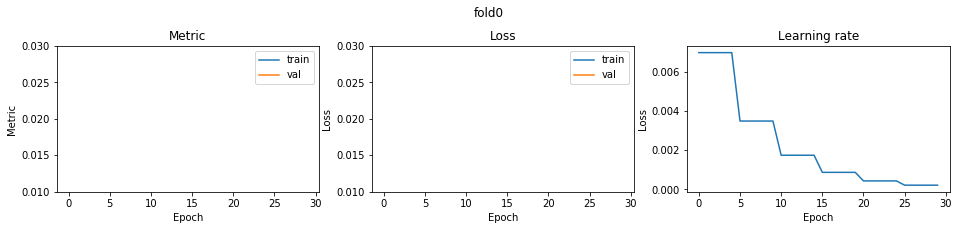

fold 1


epoch1 save best model... 0.032236802622787934
epoch2 save best model... 0.03199238209259703
epoch12 save best model... 0.031862398497055806
epoch16 save best model... 0.03182652564649295
fold1 score: 0.03182652539770235


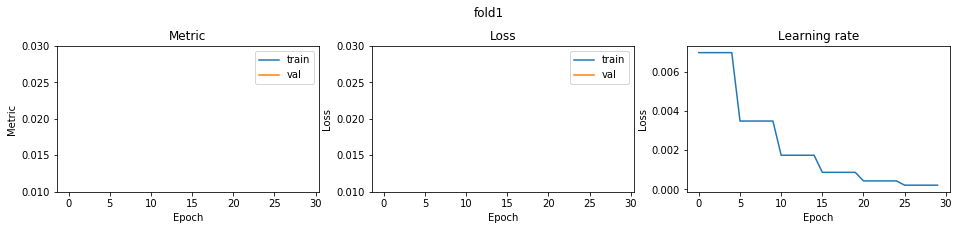

fold 2


epoch1 save best model... 0.032130808691502866
epoch2 save best model... 0.032049231775279845
epoch6 save best model... 0.031706663450800386
fold2 score: 0.03170666502956873


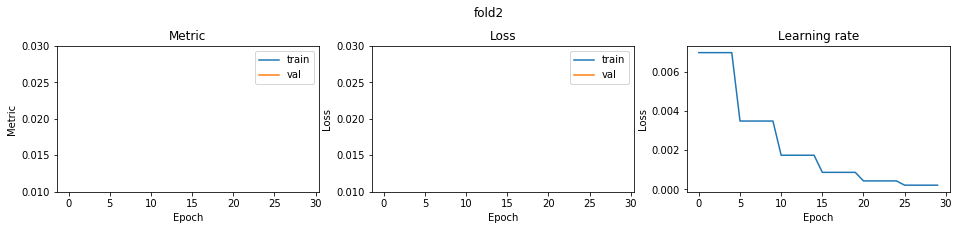

fold 3


epoch1 save best model... 0.03186764321915788
epoch15 save best model... 0.03180441771610587
fold3 score: 0.03180441883326603


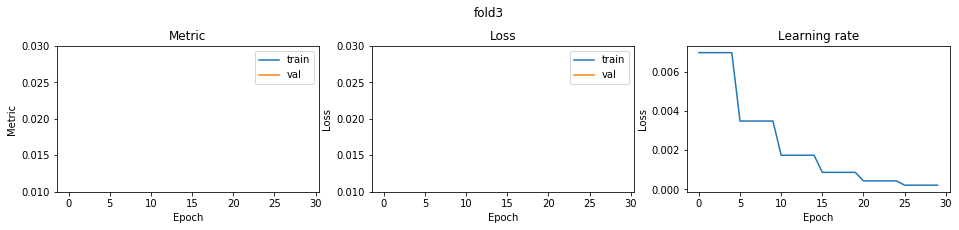

fold 4


epoch1 save best model... 0.031974516376208066
epoch2 save best model... 0.03178346663509795
fold4 score: 0.03178346692213914


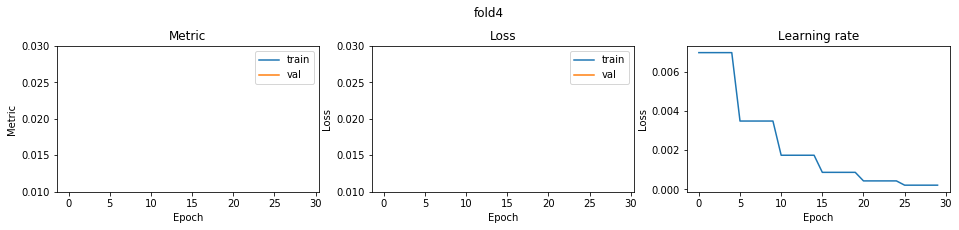

CV score: 0.03178796540696914

optimizer: AdamW_CG
fold 0


epoch1 save best model... 0.020075621694360345
epoch2 save best model... 0.01925598338399091
epoch3 save best model... 0.01819278569064678
epoch4 save best model... 0.017753659712324652
epoch5 save best model... 0.017528805183352807
epoch6 save best model... 0.0170945505142755
epoch7 save best model... 0.01696241466426089
epoch8 save best model... 0.016863598155201432
epoch9 save best model... 0.016788116193340415
epoch10 save best model... 0.016683703171331138
epoch11 save best model... 0.016439133164619257
epoch12 save best model... 0.01642074947222083
epoch13 save best model... 0.016382814125754024
epoch14 save best model... 0.01637366446019373
epoch15 save best model... 0.01630056303266037
epoch16 save best model... 0.01623363610832254
epoch17 save best model... 0.016231693875613136
fold0 score: 0.01623169383775794


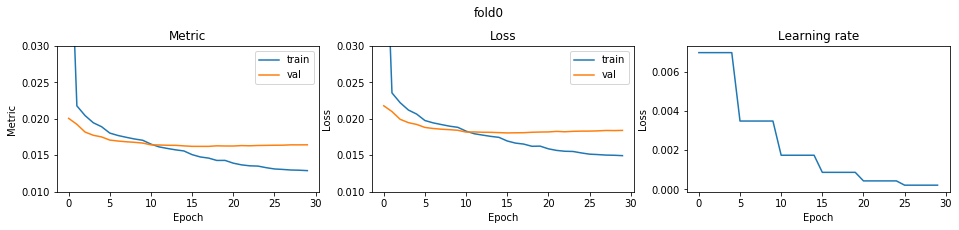

fold 1


epoch1 save best model... 0.020172999607342663
epoch2 save best model... 0.019012077456676733
epoch3 save best model... 0.018406073015550733
epoch4 save best model... 0.01791604674544536
epoch5 save best model... 0.017618833197585053
epoch6 save best model... 0.017266221501495062
epoch7 save best model... 0.01719276830053229
epoch8 save best model... 0.017049536891120338
epoch9 save best model... 0.016995276279677885
epoch10 save best model... 0.01691972804683356
epoch11 save best model... 0.016705200980901447
epoch12 save best model... 0.0166315301156996
epoch13 save best model... 0.016622552152075455
epoch14 save best model... 0.01660076765405932
epoch16 save best model... 0.016550555853879746
epoch17 save best model... 0.01652162245884928
fold1 score: 0.01652162238152447


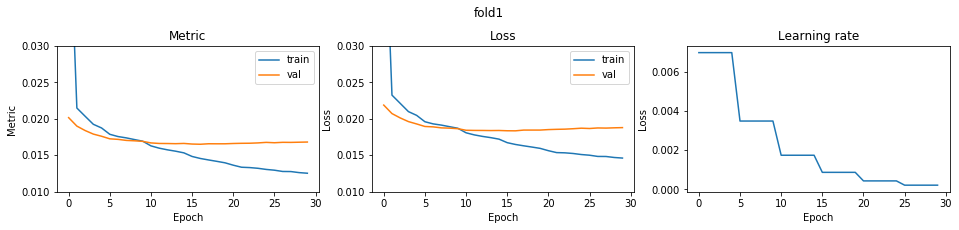

fold 2


epoch1 save best model... 0.020294935696928723
epoch2 save best model... 0.01897259499651916
epoch3 save best model... 0.018179162832791414
epoch4 save best model... 0.01768774104445297
epoch5 save best model... 0.01744997645644473
epoch6 save best model... 0.01710484348178949
epoch7 save best model... 0.01699707959900619
epoch8 save best model... 0.016886098454219383
epoch9 save best model... 0.016867937972969878
epoch10 save best model... 0.016732902809515796
epoch11 save best model... 0.016460831612976654
epoch13 save best model... 0.016409855392394646
epoch14 save best model... 0.016401639363311925
epoch15 save best model... 0.01637571030668787
epoch16 save best model... 0.016266830853725735
fold2 score: 0.016266830703889696


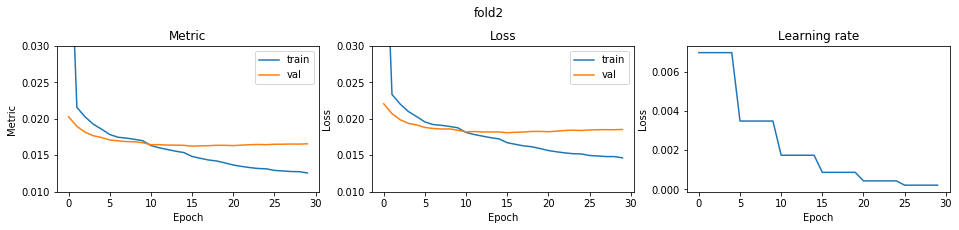

fold 3


epoch1 save best model... 0.020376752598682133
epoch2 save best model... 0.019471339697701377
epoch3 save best model... 0.018835221675218238
epoch4 save best model... 0.018223902912373423
epoch5 save best model... 0.01797258922478061
epoch6 save best model... 0.017477574315270014
epoch7 save best model... 0.017349816210024856
epoch8 save best model... 0.017252606024503164
epoch9 save best model... 0.01716436603677232
epoch10 save best model... 0.01704367749469359
epoch11 save best model... 0.01675934322679029
epoch12 save best model... 0.016711514173308916
epoch14 save best model... 0.016674982651575958
epoch15 save best model... 0.016596988311932678
epoch16 save best model... 0.01650414827337026
epoch19 save best model... 0.01645583768920434
epoch23 save best model... 0.016454738238083882
fold3 score: 0.01645473814652403


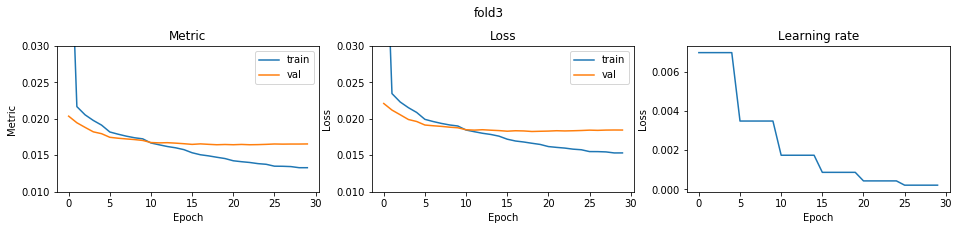

fold 4


epoch1 save best model... 0.020201584860546715
epoch2 save best model... 0.01902086885735087
epoch3 save best model... 0.018151017017068515
epoch4 save best model... 0.01792057806706578
epoch5 save best model... 0.017606548074386795
epoch6 save best model... 0.017262116332532062
epoch7 save best model... 0.017125375857385796
epoch8 save best model... 0.01695157014690594
epoch9 save best model... 0.016864394304471977
epoch10 save best model... 0.016861864641003293
epoch11 save best model... 0.016623534445474795
epoch12 save best model... 0.016520335972903123
epoch14 save best model... 0.016519564984616632
epoch15 save best model... 0.016456370839344207
epoch16 save best model... 0.01637933304266058
epoch19 save best model... 0.01637611629988718
fold4 score: 0.016376116285290496


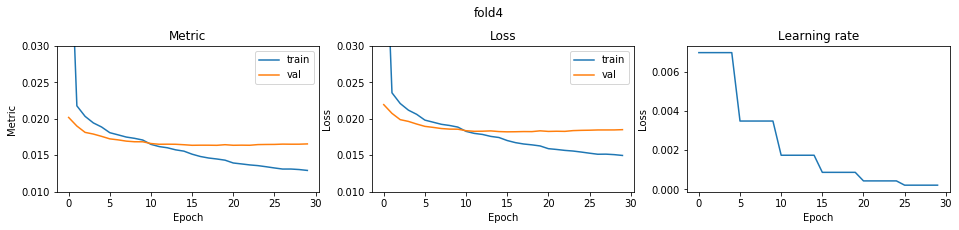

CV score: 0.016370198081615904

optimizer: PlainRAdam_CG
fold 0


epoch1 save best model... 0.698643378163253
epoch2 save best model... 0.6745778785751186
epoch3 save best model... 0.6280070979122692
epoch4 save best model... 0.523708927957235
epoch5 save best model... 0.3752630782154535
epoch6 save best model... 0.3333105508178676
epoch7 save best model... 0.29807539556455503
epoch8 save best model... 0.26488967263617114
epoch9 save best model... 0.2263487239633443
epoch10 save best model... 0.19993881220698084
epoch11 save best model... 0.19245377485056944
epoch12 save best model... 0.1838170345388947
epoch13 save best model... 0.17941932010216158
epoch14 save best model... 0.17270385436968272
epoch15 save best model... 0.1640288433412213
epoch17 save best model... 0.15976123471059125
epoch19 save best model... 0.15846277687163993
epoch20 save best model... 0.15748827974046825
epoch21 save best model... 0.15704296093459552
epoch22 save best model... 0.1565263570644861
epoch23 save best model... 0.1544759602576562
epoch24 save best model... 0.154472

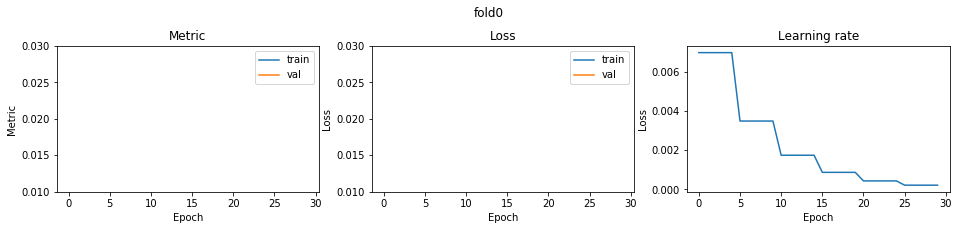

fold 1


epoch1 save best model... 0.6987565298046765
epoch2 save best model... 0.6749243182184268
epoch3 save best model... 0.6272060476883475
epoch4 save best model... 0.5240572967054524
epoch5 save best model... 0.3699940612930512
epoch6 save best model... 0.3286314240129914
epoch7 save best model... 0.29449018802749294
epoch8 save best model... 0.2577937864570092
epoch9 save best model... 0.22652961534407015
epoch10 save best model... 0.19945238057017245
epoch11 save best model... 0.19088483046876947
epoch12 save best model... 0.18415437288044198
epoch13 save best model... 0.17591384127922824
epoch14 save best model... 0.17035232866970165
epoch15 save best model... 0.1614925145091161
epoch16 save best model... 0.16107240125051417
epoch17 save best model... 0.1590189905529496
epoch18 save best model... 0.15798246398428953
epoch19 save best model... 0.1555563472932823
epoch20 save best model... 0.15307149264217101
epoch21 save best model... 0.15232603118166507
epoch24 save best model... 0.151

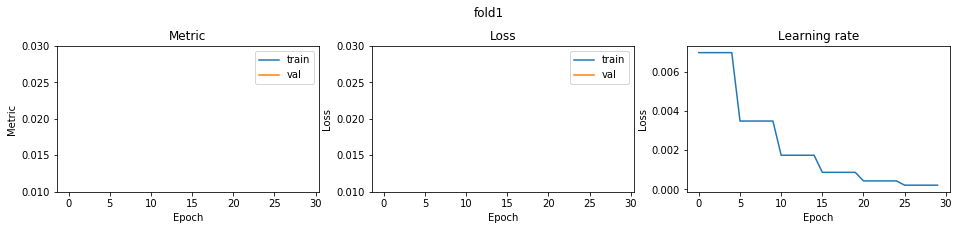

fold 2


epoch1 save best model... 0.7053184251655993
epoch2 save best model... 0.6793910208474153
epoch3 save best model... 0.6333652406109306
epoch4 save best model... 0.5280760050797739
epoch5 save best model... 0.3746285363098135
epoch6 save best model... 0.33904665176187787
epoch7 save best model... 0.29747408451238727
epoch8 save best model... 0.26170399842079745
epoch9 save best model... 0.22892876957388505
epoch10 save best model... 0.19870008379526524
epoch11 save best model... 0.1892073015385539
epoch12 save best model... 0.18484666927253557
epoch13 save best model... 0.17855034964140035
epoch14 save best model... 0.16702101060322352
epoch15 save best model... 0.15975441776706625
epoch19 save best model... 0.15655553325633847
epoch20 save best model... 0.15359002523893212
epoch24 save best model... 0.15343693694565338
epoch25 save best model... 0.14975881668545712
fold2 score: 0.1497588165730796


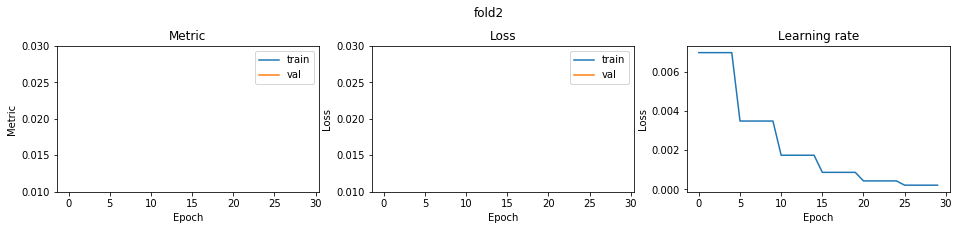

fold 3


epoch1 save best model... 0.6899540141937673
epoch2 save best model... 0.669046392228989
epoch3 save best model... 0.621458293989742
epoch4 save best model... 0.518104448418954
epoch5 save best model... 0.3700341201453111
epoch6 save best model... 0.3304068915121648
epoch7 save best model... 0.29382900637754816
epoch8 save best model... 0.25702280713784126
epoch9 save best model... 0.22418825265894174
epoch10 save best model... 0.19921954331881364
epoch11 save best model... 0.1883210266301735
epoch12 save best model... 0.18409279353390523
epoch13 save best model... 0.17506844496401133
epoch14 save best model... 0.17113573678126368
epoch15 save best model... 0.16069330272343274
epoch16 save best model... 0.16026682275302861
epoch17 save best model... 0.15919417826488513
epoch18 save best model... 0.15631499265348178
epoch20 save best model... 0.1537376737065087
epoch21 save best model... 0.15331026687708965
epoch22 save best model... 0.15057866299749778
epoch27 save best model... 0.1501

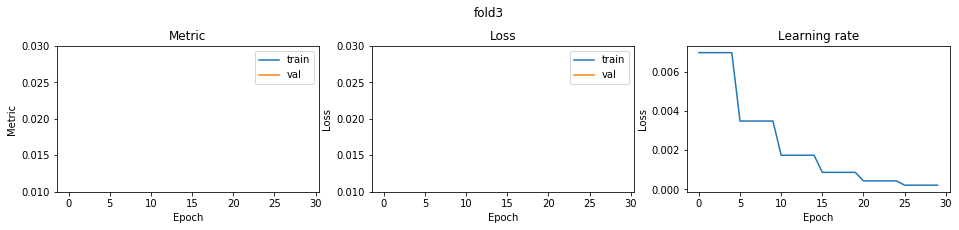

fold 4


epoch1 save best model... 0.6979989603874623
epoch2 save best model... 0.6760534681057333
epoch3 save best model... 0.6300103997043706
epoch4 save best model... 0.5275619930721361
epoch5 save best model... 0.37271495757450546
epoch6 save best model... 0.33675875447877174
epoch7 save best model... 0.2981331363761615
epoch8 save best model... 0.2622772495336576
epoch9 save best model... 0.2281442626665828
epoch10 save best model... 0.19949020418192095
epoch11 save best model... 0.1938325956158323
epoch12 save best model... 0.18375969783048696
epoch13 save best model... 0.17816946732563418
epoch14 save best model... 0.17078779882206188
epoch15 save best model... 0.16322759492386446
epoch16 save best model... 0.16223975530653717
epoch17 save best model... 0.15868636410437303
epoch18 save best model... 0.1584718652290201
epoch19 save best model... 0.15846509678896034
epoch20 save best model... 0.15482648481404862
epoch22 save best model... 0.15385702066378062
epoch24 save best model... 0.15

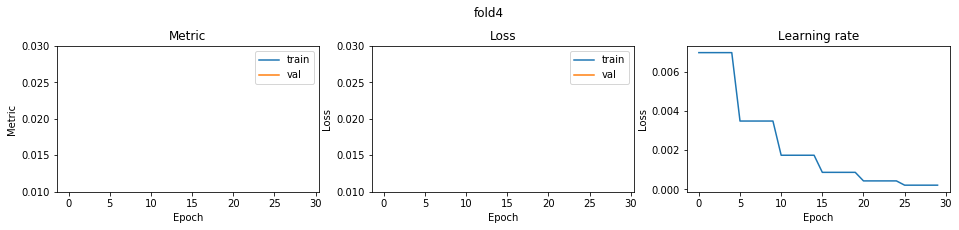

CV score: 0.1506086208765108

optimizer: RAdam_CG
fold 0


epoch1 save best model... 0.020177580875287295
epoch2 save best model... 0.01879244197609756
epoch3 save best model... 0.018131758920967172
epoch4 save best model... 0.017696876281656
epoch5 save best model... 0.017522975236415047
epoch6 save best model... 0.017039356049752725
epoch7 save best model... 0.0169035589190917
epoch8 save best model... 0.01687842049468351
epoch9 save best model... 0.016742451252216357
epoch11 save best model... 0.016405331810558713
epoch13 save best model... 0.016355843607819977
epoch14 save best model... 0.0162535767514335
epoch16 save best model... 0.016172887157046307
epoch17 save best model... 0.01615994889968009
fold0 score: 0.01615994884866005


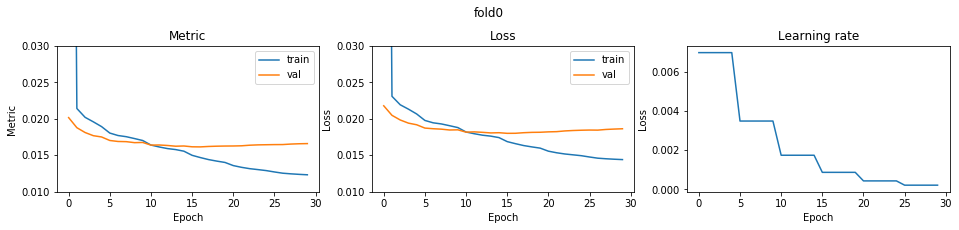

fold 1


epoch1 save best model... 0.020392500042769355
epoch2 save best model... 0.019028632994762422
epoch3 save best model... 0.018473195459113953
epoch4 save best model... 0.017934147858434994
epoch5 save best model... 0.01766944853905109
epoch6 save best model... 0.017283061397889803
epoch7 save best model... 0.017181359517934872
epoch8 save best model... 0.01705852952546222
epoch9 save best model... 0.01704108961754941
epoch10 save best model... 0.01697667324811553
epoch11 save best model... 0.016658712226636903
epoch15 save best model... 0.0166147963926247
epoch16 save best model... 0.016532272766315602
fold1 score: 0.01653227267280774


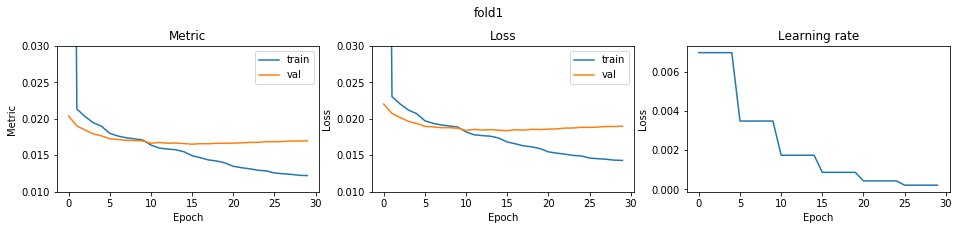

fold 2


epoch1 save best model... 0.02042323971406138
epoch2 save best model... 0.019031831870518844
epoch3 save best model... 0.018238141470287215
epoch4 save best model... 0.01781945675484179
epoch5 save best model... 0.01767658890562595
epoch6 save best model... 0.017091741181500926
epoch7 save best model... 0.01701188965228009
epoch8 save best model... 0.016823543022191724
epoch10 save best model... 0.016777348765323784
epoch11 save best model... 0.016450931510989256
epoch12 save best model... 0.01643190154940311
epoch13 save best model... 0.016426218296729043
epoch16 save best model... 0.016281949348771495
fold2 score: 0.016281949242774086


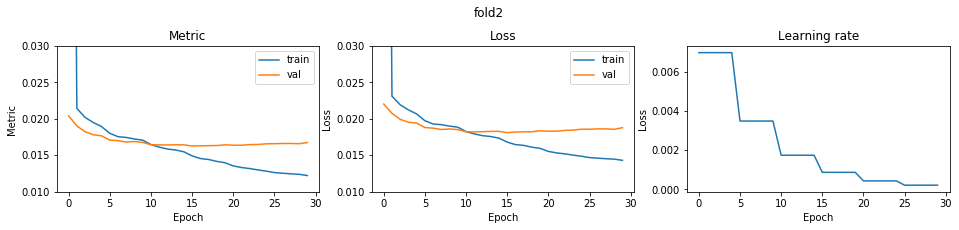

fold 3


epoch1 save best model... 0.020493153701186317
epoch2 save best model... 0.01907858771392927
epoch3 save best model... 0.018263749661590216
epoch4 save best model... 0.018087784208968314
epoch5 save best model... 0.0176508670749147
epoch6 save best model... 0.017291556319523102
epoch7 save best model... 0.017265675734550373
epoch8 save best model... 0.01707524144364381
epoch9 save best model... 0.017007071969092978
epoch10 save best model... 0.016928588076237937
epoch11 save best model... 0.01666391853684377
epoch12 save best model... 0.016591570000662755
epoch13 save best model... 0.01651882733598114
epoch16 save best model... 0.016501688113296085
epoch17 save best model... 0.016494675457545457
epoch18 save best model... 0.016488210359643422
fold3 score: 0.016488210257959008


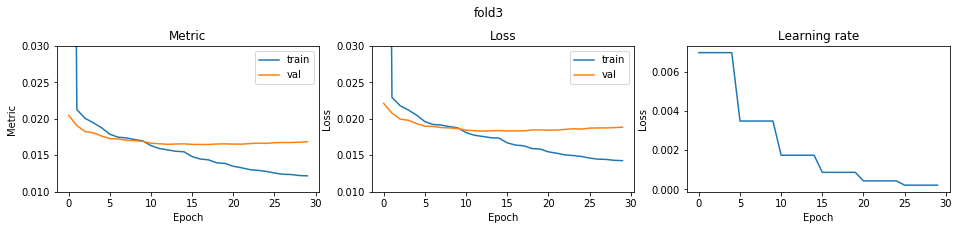

fold 4


epoch1 save best model... 0.020376052725253994
epoch2 save best model... 0.01864986987890578
epoch3 save best model... 0.01821072286966518
epoch4 save best model... 0.017895562822902937
epoch5 save best model... 0.017594564276702855
epoch6 save best model... 0.017252449129956323
epoch7 save best model... 0.017086512259799555
epoch8 save best model... 0.017044549018297352
epoch9 save best model... 0.016960222167143248
epoch10 save best model... 0.01677977656075786
epoch11 save best model... 0.01656854976104373
epoch14 save best model... 0.016537741408312105
epoch15 save best model... 0.016504638428653427
epoch16 save best model... 0.016381651172011343
fold4 score: 0.016381651009120785


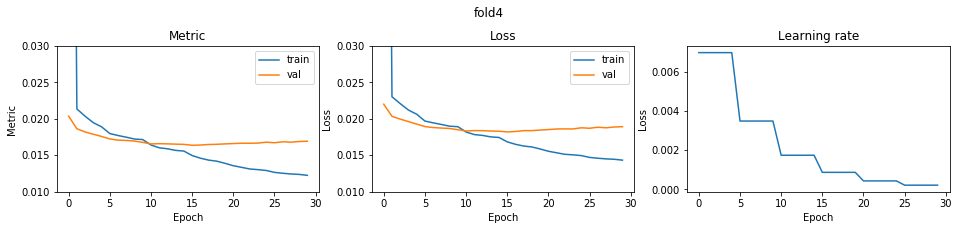

CV score: 0.01636880291578215

optimizer: Ranger_CG
fold 0


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02089450257853658
epoch2 save best model... 0.019281971858547055
epoch3 save best model... 0.018602917471514477
epoch4 save best model... 0.01798585764215177
epoch5 save best model... 0.01766784825109811
epoch6 save best model... 0.01726897739145506
epoch7 save best model... 0.017116656539651963
epoch8 save best model... 0.01695210702785191
epoch9 save best model... 0.01680592966429329
epoch10 save best model... 0.016688169835979684
epoch11 save best model... 0.01647058034693326
epoch12 save best model... 0.016366194226781164
epoch13 save best model... 0.016326346542847456
epoch14 save best model... 0.01629565580576183
epoch15 save best model... 0.016261270083062742
epoch16 save best model... 0.016197517601633127
epoch17 save best model... 0.016154320854566362
fold0 score: 0.01615432074867632


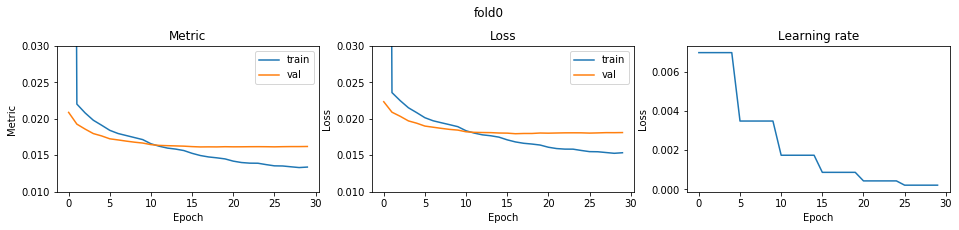

fold 1


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021185859612565455
epoch2 save best model... 0.01948674635502887
epoch3 save best model... 0.018602131594097213
epoch4 save best model... 0.018049037409490105
epoch5 save best model... 0.01784686764116968
epoch6 save best model... 0.017381154598723813
epoch7 save best model... 0.017300828340923592
epoch8 save best model... 0.01706831620598293
epoch9 save best model... 0.016977990594242463
epoch11 save best model... 0.016765118429959702
epoch12 save best model... 0.01670188880335615
epoch13 save best model... 0.01659849717131737
epoch15 save best model... 0.016545908141513705
epoch16 save best model... 0.01649669856707296
epoch17 save best model... 0.01647722361599579
epoch20 save best model... 0.016462299343403094
epoch21 save best model... 0.016445838448188997
fold1 score: 0.016445838376088307


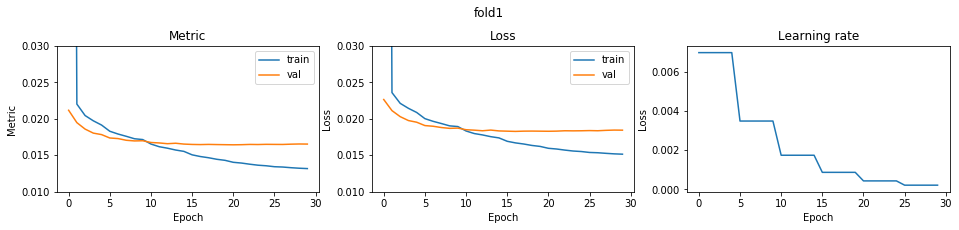

fold 2


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.021253576462735724
epoch2 save best model... 0.019426852129408263
epoch3 save best model... 0.018637147208806878
epoch4 save best model... 0.017941113253285113
epoch5 save best model... 0.0176115043596703
epoch6 save best model... 0.017193287126354977
epoch7 save best model... 0.017018581918801703
epoch8 save best model... 0.016959687251208052
epoch9 save best model... 0.016824753840421456
epoch10 save best model... 0.016724949854551918
epoch11 save best model... 0.016559750025238486
epoch12 save best model... 0.01650742988920573
epoch13 save best model... 0.0164384241083263
epoch14 save best model... 0.01640874521068823
epoch16 save best model... 0.016290872630668096
fold2 score: 0.01629087244784707


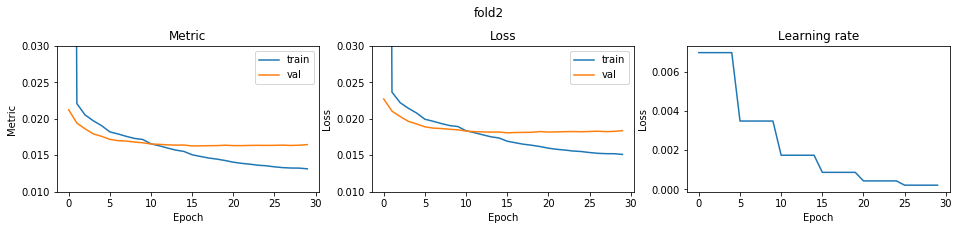

fold 3


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.02126112760623794
epoch2 save best model... 0.019538933939485043
epoch3 save best model... 0.018827407786745687
epoch4 save best model... 0.01813026222449161
epoch5 save best model... 0.017879837069550108
epoch6 save best model... 0.017432566311269795
epoch7 save best model... 0.01734142211649847
epoch8 save best model... 0.017149860917639353
epoch9 save best model... 0.017052787295829056
epoch10 save best model... 0.016904145497871153
epoch11 save best model... 0.016770255872406964
epoch12 save best model... 0.01666751595761347
epoch13 save best model... 0.016583996481243056
epoch14 save best model... 0.01657019362939789
epoch15 save best model... 0.016547233628317
epoch16 save best model... 0.01639908881930121
epoch17 save best model... 0.016393391762548264
epoch21 save best model... 0.016388481414128003
fold3 score: 0.016388481251394832


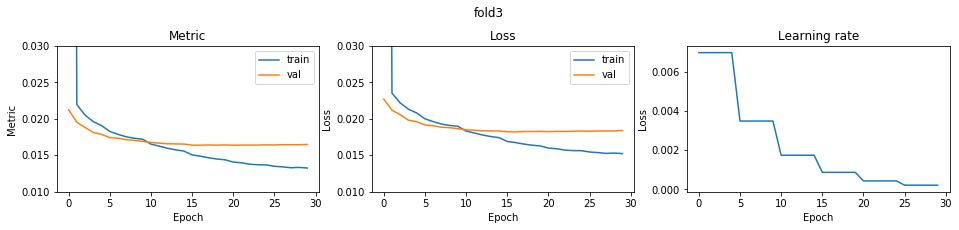

fold 4


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


epoch1 save best model... 0.020898884868329914
epoch2 save best model... 0.01926429775503203
epoch3 save best model... 0.018341218236333147
epoch4 save best model... 0.017840815871393897
epoch5 save best model... 0.0174756979671623
epoch6 save best model... 0.017119612229101206
epoch7 save best model... 0.01702283496262001
epoch9 save best model... 0.01683977250187978
epoch10 save best model... 0.016718503726319597
epoch11 save best model... 0.016616971071614355
epoch12 save best model... 0.016537623267391683
epoch13 save best model... 0.016470793247273817
epoch15 save best model... 0.016440474911930212
epoch16 save best model... 0.016396611626843385
epoch19 save best model... 0.016386797527330747
fold4 score: 0.016386797500073078


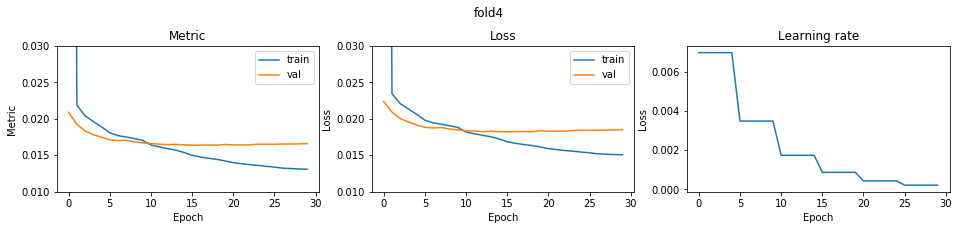

CV score: 0.016333258866953054

optimizer: AggMo
fold 0


epoch1 save best model... 0.27544877525071076
epoch2 save best model... 0.03225111349195174
epoch3 save best model... 0.03015467182378834
fold0 score: 0.030154671767834127


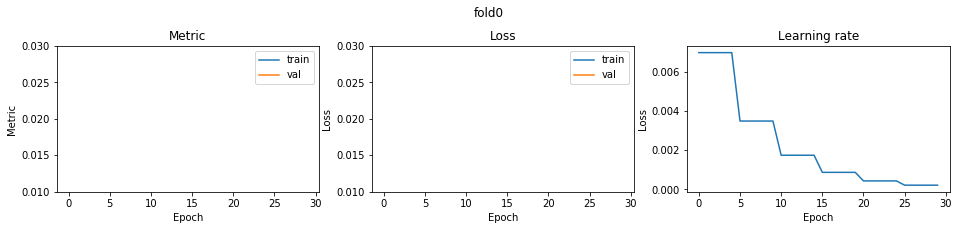

fold 1


epoch1 save best model... 0.2719704919182975
epoch2 save best model... 0.032212706628612246
epoch3 save best model... 0.03019374679781685
fold1 score: 0.030193746767621092


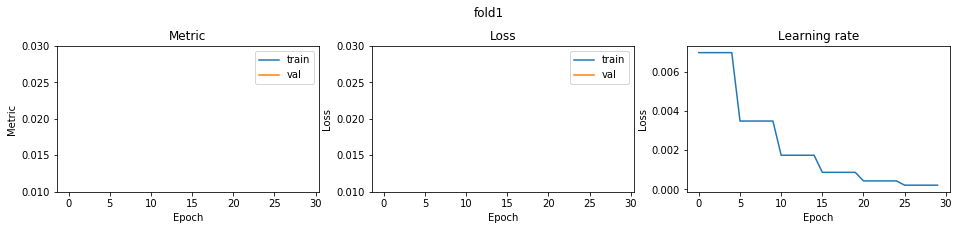

fold 2


epoch1 save best model... 0.2539221891294337
epoch2 save best model... 0.03145313647181631
epoch3 save best model... 0.02983242071406204
fold2 score: 0.029832420689297156


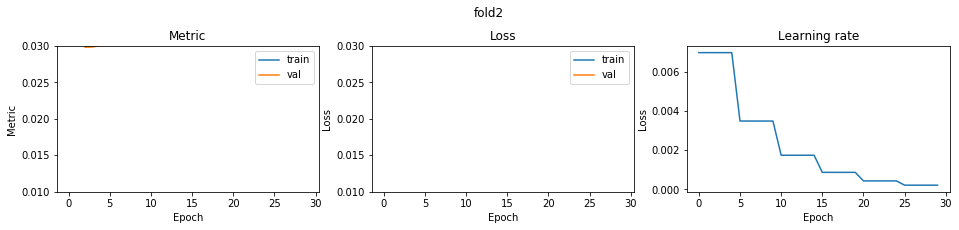

fold 3


epoch1 save best model... 0.2958872773109645
epoch2 save best model... 0.03253689149314016
epoch3 save best model... 0.03041714743068251
epoch4 save best model... 0.03030847170578999
fold3 score: 0.0303084716276055


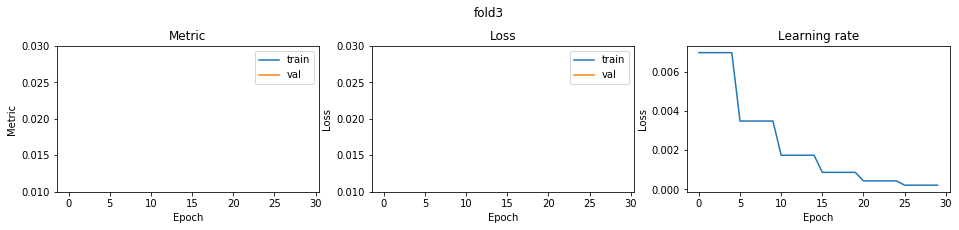

fold 4


epoch1 save best model... 0.26753783588528907
epoch2 save best model... 0.031667602853955604
epoch3 save best model... 0.029684773955604482
fold4 score: 0.02968477397709782


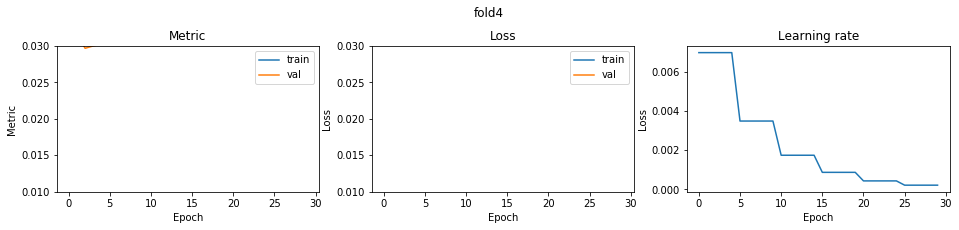

CV score: 0.03003481894632101

optimizer: Apollo
fold 0


epoch1 save best model... 0.7042104169285107
epoch2 save best model... 0.6954855916711898
epoch3 save best model... 0.6872332214766048
epoch4 save best model... 0.6777134833140362
epoch5 save best model... 0.6725499652512796
epoch6 save best model... 0.6662347498678672
epoch7 save best model... 0.6612631420611249
epoch8 save best model... 0.6593140134778815
epoch9 save best model... 0.6525767768705625
epoch10 save best model... 0.6479826980136794
epoch11 save best model... 0.6469350694795404
epoch12 save best model... 0.6450063531382481
epoch13 save best model... 0.641743530282127
epoch14 save best model... 0.639869124036715
epoch15 save best model... 0.6395266805531495
epoch16 save best model... 0.6364831489148064
epoch17 save best model... 0.6345077784838057
epoch19 save best model... 0.6335707227298502
epoch20 save best model... 0.630642838412917
epoch22 save best model... 0.6295935911578306
epoch23 save best model... 0.6286532755050138
epoch24 save best model... 0.6285455224997362


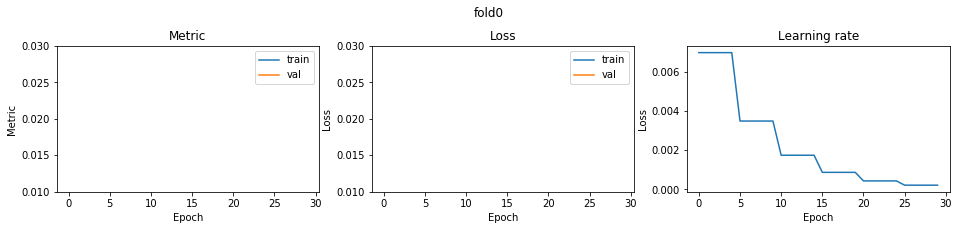

fold 1


epoch1 save best model... 0.7036611590034518
epoch2 save best model... 0.6963703317695448
epoch3 save best model... 0.690046305019781
epoch4 save best model... 0.6818409624309414
epoch5 save best model... 0.672598157963304
epoch6 save best model... 0.6693242449074895
epoch7 save best model... 0.664288700047917
epoch8 save best model... 0.6605697834945317
epoch9 save best model... 0.6569460760789299
epoch10 save best model... 0.6521051122322525
epoch11 save best model... 0.6499241923221181
epoch12 save best model... 0.6472355661454139
epoch13 save best model... 0.6449929586465062
epoch14 save best model... 0.6428510702723765
epoch15 save best model... 0.6414330469825921
epoch16 save best model... 0.6388462246156928
epoch17 save best model... 0.6374186439811844
epoch18 save best model... 0.6360724853828301
epoch20 save best model... 0.6341891318905948
epoch21 save best model... 0.633520520529244
epoch22 save best model... 0.6332545289419648
epoch23 save best model... 0.6306513483254343
e

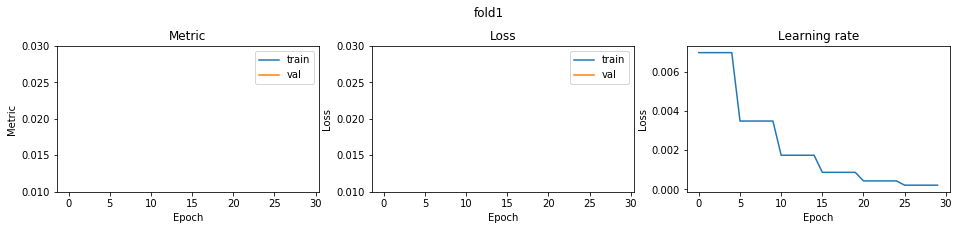

fold 2


epoch1 save best model... 0.7005595368061339
epoch2 save best model... 0.6926021417443751
epoch3 save best model... 0.6831837979311497
epoch4 save best model... 0.6772377398106959
epoch5 save best model... 0.6670765159857466
epoch6 save best model... 0.6616118876910693
epoch7 save best model... 0.6597406489888745
epoch8 save best model... 0.6566942823614936
epoch9 save best model... 0.6497084746113071
epoch10 save best model... 0.6462903442945587
epoch11 save best model... 0.6440223925856258
epoch12 save best model... 0.6428251173453332
epoch13 save best model... 0.6399403996146005
epoch14 save best model... 0.6364991067481981
epoch15 save best model... 0.6341711931332935
epoch16 save best model... 0.6328143602787538
epoch17 save best model... 0.6307594853018975
epoch18 save best model... 0.629824718871674
epoch19 save best model... 0.6286742611582172
epoch20 save best model... 0.62710392116604
epoch21 save best model... 0.6266091848104194
epoch24 save best model... 0.6238102501279049


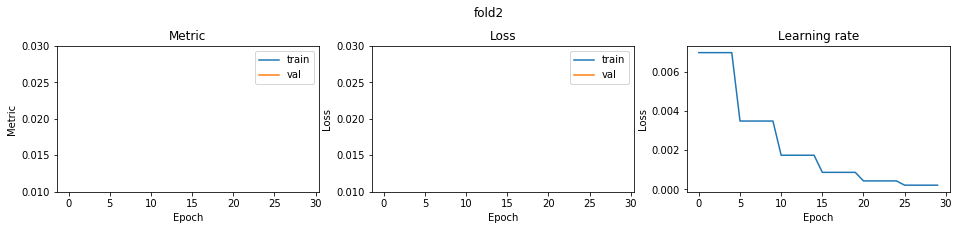

fold 3


epoch1 save best model... 0.7065570272997463
epoch2 save best model... 0.6971668872583429
epoch3 save best model... 0.6885669269159878
epoch4 save best model... 0.6806620327378188
epoch5 save best model... 0.6750135052720072
epoch6 save best model... 0.6698676002052759
epoch7 save best model... 0.6669584075790874
epoch8 save best model... 0.6623148037523778
epoch9 save best model... 0.6569206793107313
epoch10 save best model... 0.6533922529166272
epoch11 save best model... 0.6505327948948245
epoch12 save best model... 0.6501485345303877
epoch13 save best model... 0.6470957084777414
epoch14 save best model... 0.643777801072679
epoch15 save best model... 0.6429229717591357
epoch16 save best model... 0.6420329499896403
epoch17 save best model... 0.6399504766377339
epoch18 save best model... 0.6387925446440799
epoch19 save best model... 0.63693845242194
epoch20 save best model... 0.6367492884058072
epoch21 save best model... 0.6365931361845795
epoch22 save best model... 0.635973897555966
e

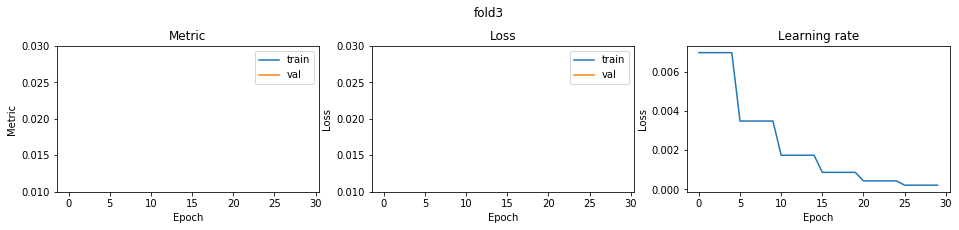

fold 4


epoch1 save best model... 0.7056871978731525
epoch2 save best model... 0.6988878646309664
epoch3 save best model... 0.6919494720417709
epoch4 save best model... 0.6832785419831243
epoch5 save best model... 0.6747786517566864
epoch6 save best model... 0.6708032159164447
epoch7 save best model... 0.6670290414999177
epoch8 save best model... 0.6636124534867619
epoch9 save best model... 0.6589312675330525
epoch10 save best model... 0.6549394164378659
epoch11 save best model... 0.6512912845557263
epoch12 save best model... 0.6496008458333026
epoch13 save best model... 0.6471761440090275
epoch14 save best model... 0.6452435118462339
epoch15 save best model... 0.6414775246368182
epoch16 save best model... 0.6408145481198687
epoch18 save best model... 0.6398936731125607
epoch19 save best model... 0.6370041355185194
epoch20 save best model... 0.6357622254410746
epoch22 save best model... 0.6354187647954207
epoch24 save best model... 0.6333790621616303
epoch27 save best model... 0.63179423089451

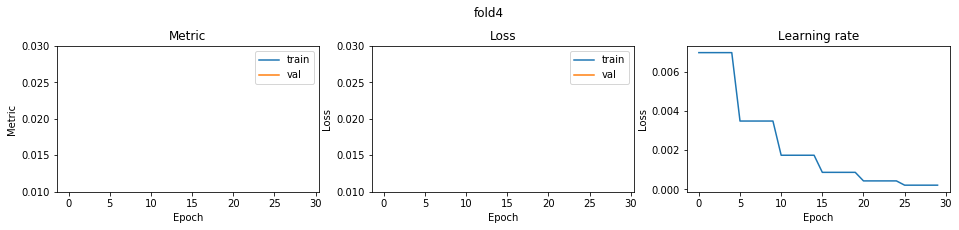

CV score: 0.627586778056901

optimizer: PID
fold 0


epoch1 save best model... 0.7019045250562438
epoch2 save best model... 0.6926811619065617
epoch3 save best model... 0.685389456580603
epoch4 save best model... 0.678284294214227
epoch5 save best model... 0.670825588757465
epoch6 save best model... 0.667609113577015
epoch7 save best model... 0.6647779070706465
epoch8 save best model... 0.6581331913183381
epoch9 save best model... 0.6547235038394537
epoch10 save best model... 0.6497808816221146
epoch11 save best model... 0.649648955552616
epoch12 save best model... 0.6466385970897718
epoch13 save best model... 0.6432903881496612
epoch14 save best model... 0.6423625183268398
epoch15 save best model... 0.6390005352013747
epoch16 save best model... 0.6376824202189956
epoch17 save best model... 0.6355642634535161
epoch18 save best model... 0.6355260739565439
epoch19 save best model... 0.632276830233311
epoch22 save best model... 0.6313097819651993
epoch23 save best model... 0.6305265720721529
epoch24 save best model... 0.6301979135815267
epo

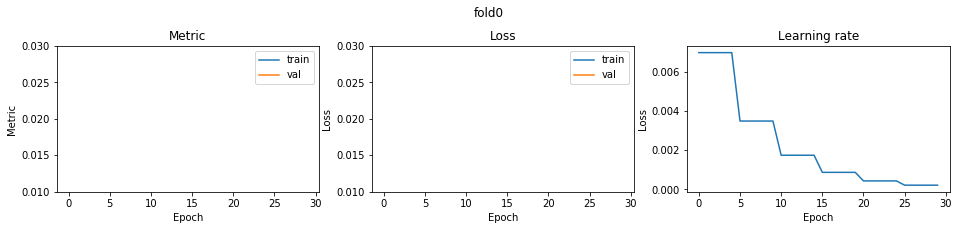

fold 1


epoch1 save best model... 0.7035828147344096
epoch2 save best model... 0.6938038376692787
epoch3 save best model... 0.688645745076088
epoch4 save best model... 0.6797946954294988
epoch5 save best model... 0.6730009822591233
epoch6 save best model... 0.6700477628480821
epoch7 save best model... 0.6649936542040559
epoch8 save best model... 0.6606443441384038
epoch9 save best model... 0.6566620212830018
epoch10 save best model... 0.6519781837269993
epoch11 save best model... 0.6507858315940652
epoch12 save best model... 0.6493573318203535
epoch13 save best model... 0.6452987078627358
epoch14 save best model... 0.6432686303601121
epoch15 save best model... 0.6417451749550886
epoch16 save best model... 0.6399605605156282
epoch17 save best model... 0.639791839104846
epoch18 save best model... 0.6383859787749984
epoch19 save best model... 0.6371969031728083
epoch20 save best model... 0.6355066588702303
epoch21 save best model... 0.6343045347262201
epoch23 save best model... 0.6328678767483934

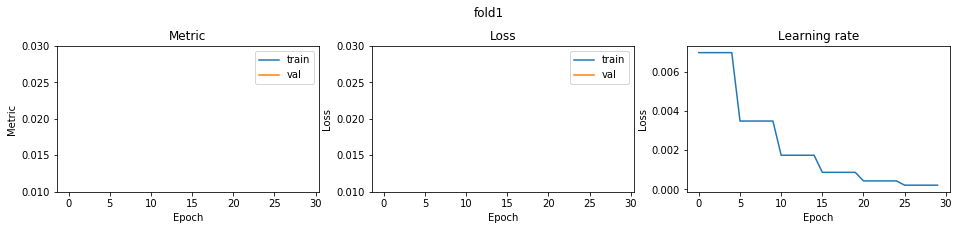

fold 2


epoch1 save best model... 0.7053740136062238
epoch2 save best model... 0.6976944285417966
epoch3 save best model... 0.6894401167785695
epoch4 save best model... 0.6823346141830179
epoch5 save best model... 0.6740792628354759
epoch6 save best model... 0.6694754751050735
epoch7 save best model... 0.6641071464863854
epoch8 save best model... 0.6601958073850481
epoch9 save best model... 0.6552753404214025
epoch10 save best model... 0.6528975661155656
epoch11 save best model... 0.6496467027286105
epoch12 save best model... 0.6470348823583868
epoch13 save best model... 0.6444895179620987
epoch14 save best model... 0.6415531472047279
epoch15 save best model... 0.639626415396747
epoch16 save best model... 0.6388592784403125
epoch17 save best model... 0.6370341190718171
epoch18 save best model... 0.6351359420307243
epoch20 save best model... 0.6347406790913251
epoch21 save best model... 0.6328752724639265
epoch22 save best model... 0.6305290506352702
epoch27 save best model... 0.629414228093083

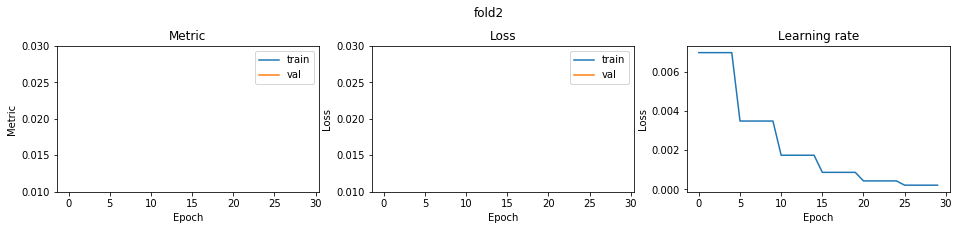

fold 3


epoch1 save best model... 0.704989501528425
epoch2 save best model... 0.6972657499389388
epoch3 save best model... 0.6895593534297987
epoch4 save best model... 0.6795370108445847
epoch5 save best model... 0.6720633954556493
epoch6 save best model... 0.6677826286448433
epoch7 save best model... 0.664560582833301
epoch8 save best model... 0.661574365364935
epoch9 save best model... 0.6565419824900008
epoch10 save best model... 0.652711044194215
epoch11 save best model... 0.6495341839442763
epoch12 save best model... 0.6471576916329681
epoch13 save best model... 0.6460810497301315
epoch14 save best model... 0.644702171247478
epoch15 save best model... 0.6402057195307183
epoch17 save best model... 0.6386426202528569
epoch18 save best model... 0.6381000259471102
epoch19 save best model... 0.6370950038177821
epoch20 save best model... 0.6352696512446045
epoch21 save best model... 0.6343587421882125
epoch22 save best model... 0.6328620131575166
epoch23 save best model... 0.6327073474408282
ep

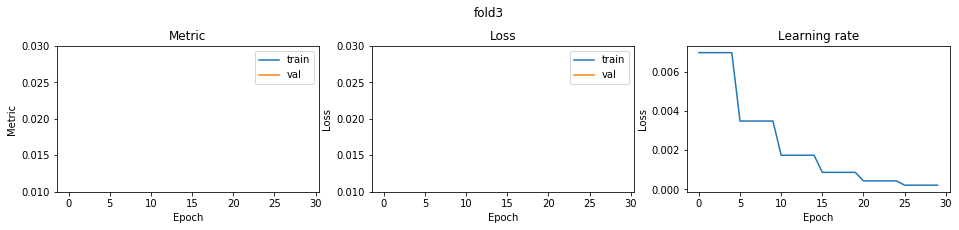

fold 4


epoch1 save best model... 0.710611275279712
epoch2 save best model... 0.6989515733338706
epoch3 save best model... 0.6904975542174928
epoch4 save best model... 0.6822081134911279
epoch5 save best model... 0.675533882414833
epoch6 save best model... 0.6709181613965567
epoch7 save best model... 0.6669163567330136
epoch8 save best model... 0.662201553135092
epoch9 save best model... 0.6577975017877808
epoch10 save best model... 0.6518527307108486
epoch11 save best model... 0.6493089959127213
epoch12 save best model... 0.6469009862945401
epoch13 save best model... 0.644021722368879
epoch14 save best model... 0.6419161447088376
epoch15 save best model... 0.6382287189194716
epoch16 save best model... 0.6379051863468318
epoch18 save best model... 0.636674019959087
epoch19 save best model... 0.6349885607906246
epoch20 save best model... 0.6332558937930843
epoch21 save best model... 0.6325344900606976
epoch22 save best model... 0.6292487130349752
epoch25 save best model... 0.6283306683114558
ep

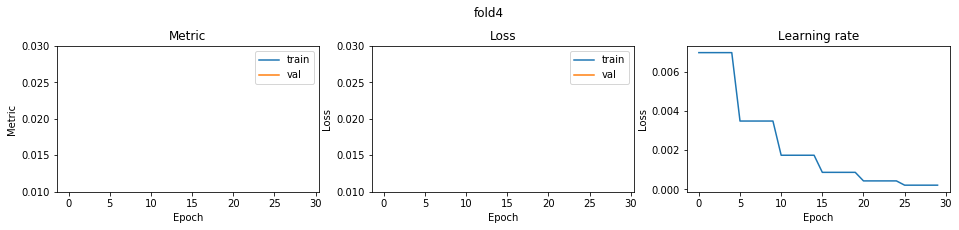

CV score: 0.6281327440582817

optimizer: QHM
fold 0


epoch1 save best model... 0.7020350388079406
epoch2 save best model... 0.6938981267205675
epoch3 save best model... 0.6867012914329563
epoch4 save best model... 0.6813101340806565
epoch5 save best model... 0.6700843194079562
epoch6 save best model... 0.6682113821522793
epoch7 save best model... 0.6622804493730323
epoch8 save best model... 0.6569305924999959
epoch9 save best model... 0.6525420810475708
epoch10 save best model... 0.6484989813900212
epoch11 save best model... 0.6452724759019317
epoch12 save best model... 0.6450181978710149
epoch13 save best model... 0.640879667348362
epoch14 save best model... 0.6378078945948485
epoch15 save best model... 0.6360782518202188
epoch16 save best model... 0.634040411566819
epoch17 save best model... 0.6337579440147295
epoch18 save best model... 0.6314166232230723
epoch19 save best model... 0.6291605418526773
epoch20 save best model... 0.6278569743953696
epoch22 save best model... 0.6274101398800391
epoch24 save best model... 0.6264476067927541

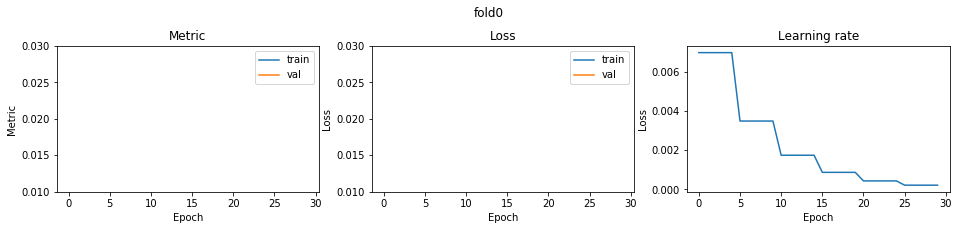

fold 1


epoch1 save best model... 0.7012455336975328
epoch2 save best model... 0.6957405613152632
epoch3 save best model... 0.6863192638196008
epoch4 save best model... 0.6796295378033788
epoch5 save best model... 0.6708347269113853
epoch6 save best model... 0.6675917726900453
epoch7 save best model... 0.6629428792092164
epoch8 save best model... 0.658219848210949
epoch9 save best model... 0.6545031593828599
epoch10 save best model... 0.6509199201259452
epoch11 save best model... 0.6495949677710491
epoch12 save best model... 0.6452717789622585
epoch13 save best model... 0.6421839151438941
epoch14 save best model... 0.6403347000252225
epoch15 save best model... 0.6377495003061648
epoch16 save best model... 0.6365755413870899
epoch18 save best model... 0.6349915371692977
epoch19 save best model... 0.6336704085426739
epoch20 save best model... 0.6317181911520655
epoch22 save best model... 0.630548842976158
epoch23 save best model... 0.6295579368743844
epoch24 save best model... 0.6293555880005741

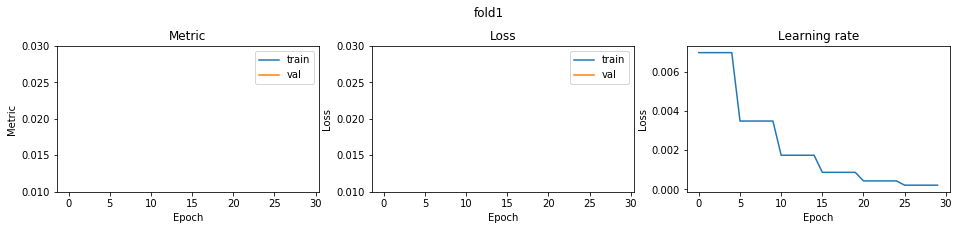

fold 2


epoch1 save best model... 0.7066734108601107
epoch2 save best model... 0.6975201980403302
epoch3 save best model... 0.6898755946417935
epoch4 save best model... 0.6831862029357879
epoch5 save best model... 0.6752927897187783
epoch6 save best model... 0.6722070254533159
epoch7 save best model... 0.6688712194857334
epoch8 save best model... 0.663055404820402
epoch9 save best model... 0.6577277542056894
epoch10 save best model... 0.6547482892765655
epoch11 save best model... 0.6533898691377056
epoch12 save best model... 0.6516078914398755
epoch13 save best model... 0.6487099155936433
epoch14 save best model... 0.6463027730105433
epoch15 save best model... 0.644289345194251
epoch16 save best model... 0.6420000939576711
epoch17 save best model... 0.6410510524798428
epoch18 save best model... 0.6405569263486717
epoch19 save best model... 0.6396592276518425
epoch21 save best model... 0.6375391780583183
epoch23 save best model... 0.6362652898948375
epoch24 save best model... 0.6361907279336607

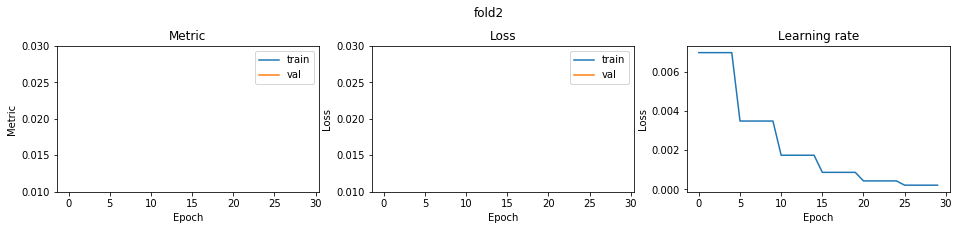

fold 3


epoch1 save best model... 0.7032699420946334
epoch2 save best model... 0.6962734067358569
epoch3 save best model... 0.6877225282523518
epoch4 save best model... 0.6825194925545017
epoch5 save best model... 0.6731066914788683
epoch6 save best model... 0.6690073882257205
epoch7 save best model... 0.6657195521107024
epoch8 save best model... 0.6617155308875516
epoch9 save best model... 0.6562375887379831
epoch10 save best model... 0.6536377696621662
epoch11 save best model... 0.6513566347080917
epoch12 save best model... 0.6486202543037084
epoch13 save best model... 0.6462262575338533
epoch14 save best model... 0.645545221298322
epoch15 save best model... 0.6417312184335974
epoch16 save best model... 0.6413882655543456
epoch17 save best model... 0.6397034730889531
epoch18 save best model... 0.6377015132838881
epoch20 save best model... 0.6372264759144098
epoch21 save best model... 0.6357530910496288
epoch22 save best model... 0.6350096381606708
epoch23 save best model... 0.633561407080543

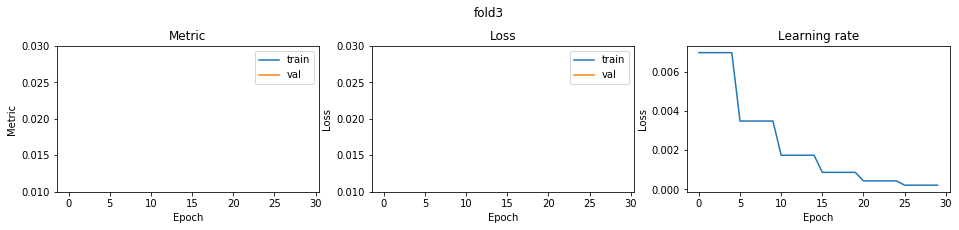

fold 4


epoch1 save best model... 0.7052615848923598
epoch2 save best model... 0.6991408583786601
epoch3 save best model... 0.6917436802034226
epoch4 save best model... 0.6836317656795093
epoch5 save best model... 0.6746006990348017
epoch6 save best model... 0.6706285402009047
epoch7 save best model... 0.667927618070181
epoch8 save best model... 0.6611243498080955
epoch9 save best model... 0.6574671697507958
epoch10 save best model... 0.6541586021084449
epoch11 save best model... 0.6515635835825718
epoch12 save best model... 0.6510065920532156
epoch13 save best model... 0.6483496635269739
epoch14 save best model... 0.6462826197674171
epoch15 save best model... 0.641733882068773
epoch16 save best model... 0.6414404864734832
epoch17 save best model... 0.6393865598089874
epoch19 save best model... 0.638669872962804
epoch20 save best model... 0.6367568263431888
epoch21 save best model... 0.6358947186915369
epoch22 save best model... 0.6339848251440531
epoch27 save best model... 0.6328472003849872


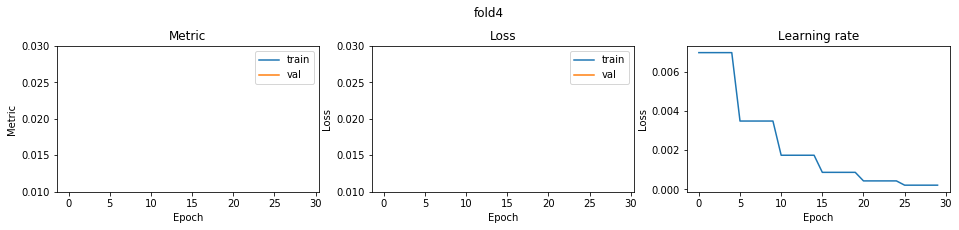

CV score: 0.6297041982887559

optimizer: SGDP
fold 0


epoch1 save best model... 0.7037449880178535
epoch2 save best model... 0.6983357699965562
epoch3 save best model... 0.6884190410579255
epoch4 save best model... 0.6810551820692006
epoch5 save best model... 0.6724803180792337
epoch6 save best model... 0.6696373194388213
epoch7 save best model... 0.6670753220219275
epoch8 save best model... 0.6626632489756191
epoch9 save best model... 0.6573343942811658
epoch10 save best model... 0.6524149578361685
epoch11 save best model... 0.6511671449980595
epoch12 save best model... 0.6496276961915314
epoch13 save best model... 0.6464523080812772
epoch14 save best model... 0.6442869832412529
epoch15 save best model... 0.6403730718312882
epoch17 save best model... 0.6391463115981065
epoch18 save best model... 0.6383032048210197
epoch19 save best model... 0.6368504454714834
epoch20 save best model... 0.6360380988186204
epoch21 save best model... 0.635975066485872
epoch22 save best model... 0.6341650259521936
epoch24 save best model... 0.632845456344934

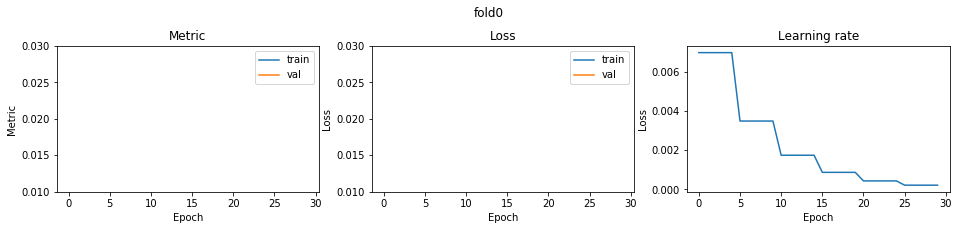

fold 1


epoch1 save best model... 0.7021881237500457
epoch2 save best model... 0.6955879302116103
epoch3 save best model... 0.6862654378512476
epoch4 save best model... 0.679347485663761
epoch5 save best model... 0.67163510605316
epoch6 save best model... 0.6691457038046315
epoch7 save best model... 0.6650068519408243
epoch8 save best model... 0.6611918572630961
epoch9 save best model... 0.6563101377593653
epoch10 save best model... 0.6538964855994144
epoch11 save best model... 0.6512070917056508
epoch12 save best model... 0.6487073546174067
epoch13 save best model... 0.6476168977858456
epoch14 save best model... 0.6444956966510094
epoch15 save best model... 0.6421459298602105
epoch17 save best model... 0.6378738637882041
epoch20 save best model... 0.635477906100216
epoch21 save best model... 0.6348704603354463
epoch23 save best model... 0.6342317277001585
epoch24 save best model... 0.6318155235949777
epoch30 save best model... 0.6316176236395576
fold1 score: 0.631617630725728


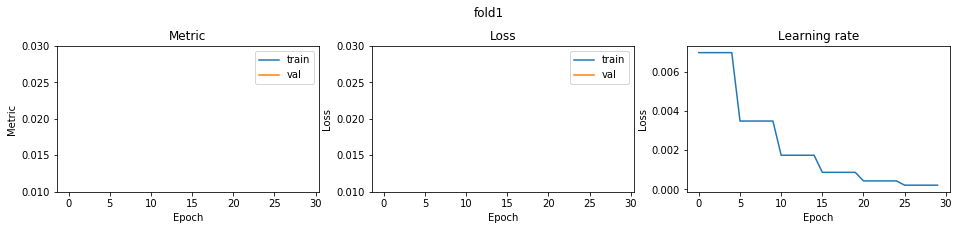

fold 2


epoch1 save best model... 0.7093491080573763
epoch2 save best model... 0.6976468515955633
epoch3 save best model... 0.690008219960448
epoch4 save best model... 0.6838951555056734
epoch5 save best model... 0.6751553916963745
epoch6 save best model... 0.6693602272904144
epoch7 save best model... 0.6664630878376346
epoch8 save best model... 0.6625754469129267
epoch9 save best model... 0.6590606069532227
epoch10 save best model... 0.6522133862084097
epoch11 save best model... 0.6504034188945899
epoch12 save best model... 0.6490829447103975
epoch13 save best model... 0.6473934531592106
epoch14 save best model... 0.6436201063341039
epoch15 save best model... 0.6414212655521357
epoch16 save best model... 0.6403108929740348
epoch17 save best model... 0.6379200465371164
epoch20 save best model... 0.6365222093536957
epoch22 save best model... 0.632885016254804
epoch23 save best model... 0.6319618768723523
epoch25 save best model... 0.6311012628980747
epoch27 save best model... 0.6302179324243954

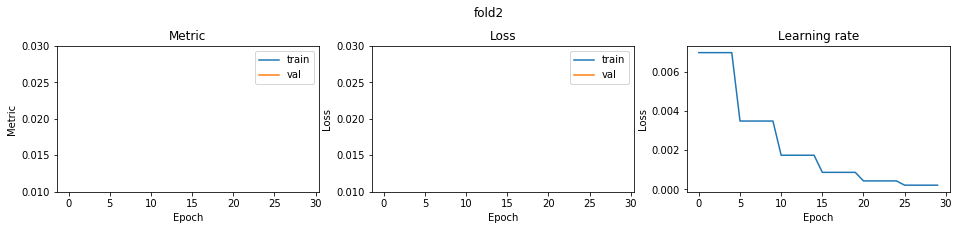

fold 3


epoch1 save best model... 0.70011426666603
epoch2 save best model... 0.6932119504465872
epoch3 save best model... 0.6850054899760966
epoch4 save best model... 0.6774490422974415
epoch5 save best model... 0.6709110885383328
epoch6 save best model... 0.6642009550455219
epoch7 save best model... 0.6602242678335968
epoch8 save best model... 0.6571021669817948
epoch9 save best model... 0.65290549173442
epoch10 save best model... 0.6480001365948375
epoch11 save best model... 0.644890385526731
epoch12 save best model... 0.6414907263731903
epoch13 save best model... 0.6395498366996748
epoch14 save best model... 0.637808479888021
epoch15 save best model... 0.6364950673455257
epoch16 save best model... 0.6345621960581299
epoch17 save best model... 0.6322364535581549
epoch18 save best model... 0.6303635041914659
epoch19 save best model... 0.6281250131157373
epoch20 save best model... 0.6267801556608943
epoch21 save best model... 0.6266443125207767
epoch25 save best model... 0.6250923041330655
epo

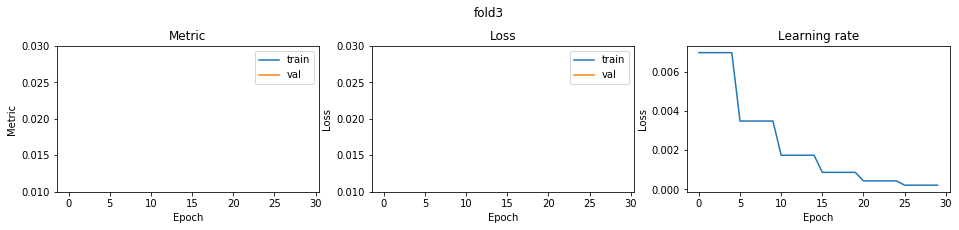

fold 4


epoch1 save best model... 0.7070377155697156
epoch2 save best model... 0.698286622206008
epoch3 save best model... 0.6900707520493614
epoch4 save best model... 0.6820446849412418
epoch5 save best model... 0.672204255270252
epoch6 save best model... 0.6698835995311346
epoch7 save best model... 0.6656348969507326
epoch8 save best model... 0.661874982843638
epoch9 save best model... 0.6572410231299172
epoch10 save best model... 0.6499745526183439
epoch11 save best model... 0.6480092788611567
epoch12 save best model... 0.6475397010599019
epoch13 save best model... 0.6461367411874149
epoch14 save best model... 0.6441522032905005
epoch15 save best model... 0.6417236856284608
epoch16 save best model... 0.6396126887792878
epoch17 save best model... 0.637879086925663
epoch19 save best model... 0.6362885789338983
epoch20 save best model... 0.6351293025092818
epoch21 save best model... 0.6347828727919854
epoch22 save best model... 0.6314519599792897
epoch26 save best model... 0.6312613190985487
e

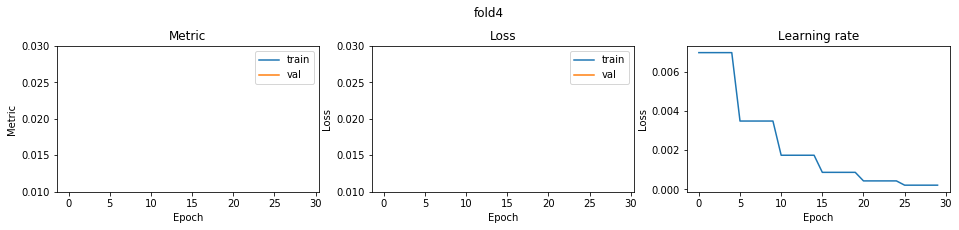

CV score: 0.6289688449443817

optimizer: SGDW
fold 0


epoch1 save best model... 0.7656186022085046
epoch10 save best model... 0.7082220568472269
epoch11 save best model... 0.6819524929572347
epoch14 save best model... 0.6634748459133852
epoch15 save best model... 0.6592002401590891
epoch17 save best model... 0.6180850072710824
epoch19 save best model... 0.6105133230974028
epoch20 save best model... 0.5831357411480167
epoch21 save best model... 0.5441990722420547
fold0 score: 0.5441990765801737


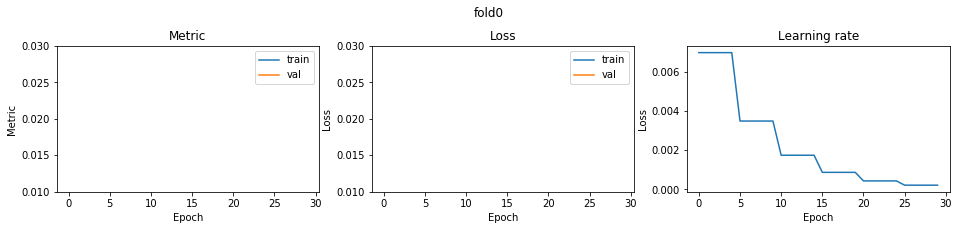

fold 1


epoch1 save best model... 0.7591103945350994
epoch6 save best model... 0.6866957294585141
epoch11 save best model... 0.6571958669091879
epoch16 save best model... 0.6033825322214957
epoch19 save best model... 0.5569132319016021
epoch22 save best model... 0.5549442184272891
epoch30 save best model... 0.5132862884244878
fold1 score: 0.5132862909080443


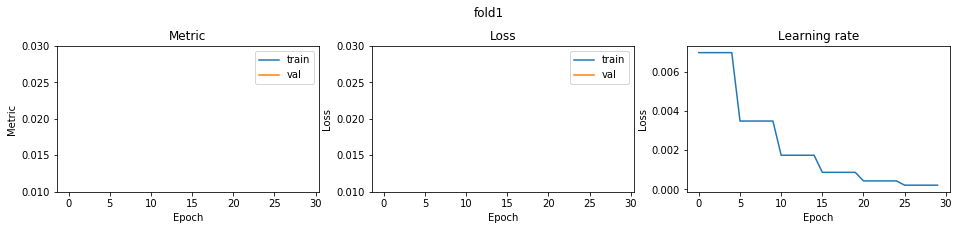

fold 2


epoch1 save best model... 0.7460889251065379
epoch11 save best model... 0.6802623886661721
epoch15 save best model... 0.6211076760025876
epoch16 save best model... 0.6157670081218573
epoch19 save best model... 0.6032138776741149
epoch20 save best model... 0.5761136399447497
epoch22 save best model... 0.5734324804822305
epoch27 save best model... 0.5424017317272259
fold2 score: 0.5424017351405173


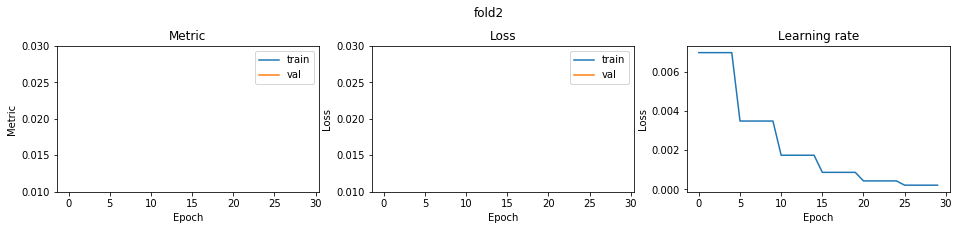

fold 3


epoch1 save best model... 0.7569117704665199
epoch7 save best model... 0.7372067078099436
epoch8 save best model... 0.7114149393144664
epoch11 save best model... 0.6198540898553331
epoch13 save best model... 0.5764184460009963
epoch15 save best model... 0.5472364026484565
epoch22 save best model... 0.47694728356830624
fold3 score: 0.47694728281383975


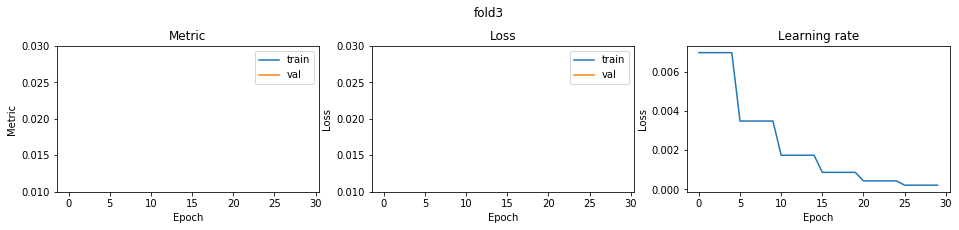

fold 4


epoch1 save best model... 0.7745815195363855
epoch8 save best model... 0.7543541336521201
epoch12 save best model... 0.6500680196393867
epoch15 save best model... 0.6165540379516627
epoch21 save best model... 0.584336338445103
epoch25 save best model... 0.5698561516872571
epoch28 save best model... 0.5212730653600975
fold4 score: 0.5212730631436137


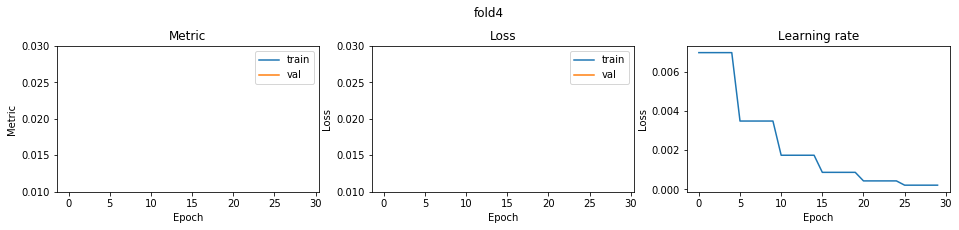

CV score: 0.5196207404441098

optimizer: SGD
fold 0


epoch1 save best model... 0.7107278088502298
epoch2 save best model... 0.7020923751361821
epoch3 save best model... 0.6944003061987545
epoch4 save best model... 0.686497173629752
epoch5 save best model... 0.6789947094026622
epoch6 save best model... 0.6738506440964267
epoch7 save best model... 0.6710499196497889
epoch8 save best model... 0.6660989226675794
epoch9 save best model... 0.6610390804080051
epoch10 save best model... 0.6582977597154083
epoch11 save best model... 0.6558279674797232
epoch12 save best model... 0.6530858260895506
epoch13 save best model... 0.6512868525770096
epoch14 save best model... 0.6466470015890777
epoch15 save best model... 0.6459598908120244
epoch16 save best model... 0.6450809033422101
epoch17 save best model... 0.6440588551664679
epoch18 save best model... 0.6435221575115699
epoch19 save best model... 0.6413020165471661
epoch20 save best model... 0.6388954010531137
epoch21 save best model... 0.6387959200863415
epoch23 save best model... 0.636863297780716

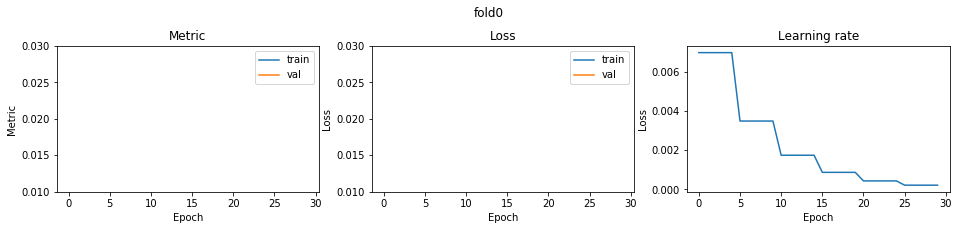

fold 1


epoch1 save best model... 0.705069327495668
epoch2 save best model... 0.6986902958169617
epoch3 save best model... 0.6894341759378586
epoch4 save best model... 0.6819596954537134
epoch5 save best model... 0.6736797290446954
epoch6 save best model... 0.6710968694564122
epoch7 save best model... 0.666710905440442
epoch8 save best model... 0.6618068965428183
epoch9 save best model... 0.6577373008490097
epoch10 save best model... 0.653879854314608
epoch11 save best model... 0.6513881808425658
epoch12 save best model... 0.6499427653412853
epoch13 save best model... 0.6466116846544809
epoch14 save best model... 0.6456618424998136
epoch15 save best model... 0.6428746860699275
epoch16 save best model... 0.6412778752326531
epoch17 save best model... 0.639863792952005
epoch19 save best model... 0.6386085368962786
epoch20 save best model... 0.6367009774811259
epoch21 save best model... 0.6364059989423572
epoch22 save best model... 0.63244042184147
epoch26 save best model... 0.6324143923613661
epo

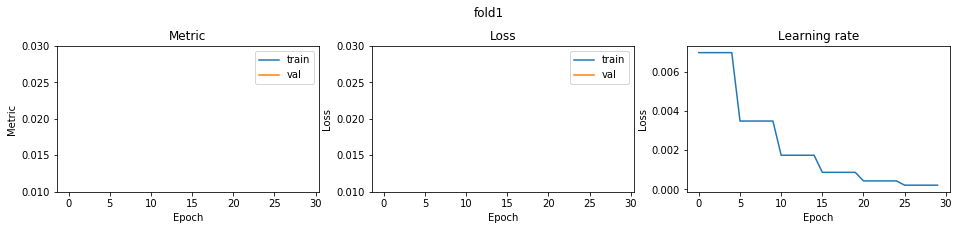

fold 2


epoch1 save best model... 0.7070577286674429
epoch2 save best model... 0.6962058093830837
epoch3 save best model... 0.6886256481118722
epoch4 save best model... 0.6808146982536307
epoch5 save best model... 0.6739533067319952
epoch6 save best model... 0.6707947425158917
epoch7 save best model... 0.6647086940938342
epoch8 save best model... 0.6621942495832576
epoch9 save best model... 0.6551874394187571
epoch10 save best model... 0.653821476053393
epoch11 save best model... 0.6504263232660935
epoch12 save best model... 0.6463391553380544
epoch13 save best model... 0.6439656554280991
epoch14 save best model... 0.6419508365923138
epoch15 save best model... 0.6410168634647387
epoch16 save best model... 0.6385663434214623
epoch17 save best model... 0.6377990222460699
epoch19 save best model... 0.6354072853111411
epoch20 save best model... 0.6325891119903083
epoch23 save best model... 0.6319912234208773
epoch24 save best model... 0.6309645331158511
epoch25 save best model... 0.630728412513772

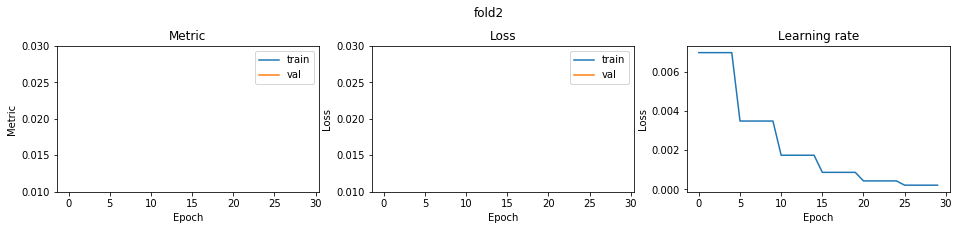

fold 3


epoch1 save best model... 0.7021457812237577
epoch2 save best model... 0.6958866923436489
epoch3 save best model... 0.687619536449806
epoch4 save best model... 0.68055181544028
epoch5 save best model... 0.6731016387972039
epoch6 save best model... 0.6691162332858475
epoch7 save best model... 0.6635708326902368
epoch8 save best model... 0.6587120854501572
epoch9 save best model... 0.6544228806311014
epoch10 save best model... 0.6536152443201504
epoch11 save best model... 0.6484127584513879
epoch12 save best model... 0.6469392907918179
epoch14 save best model... 0.642506794967521
epoch15 save best model... 0.6403947778063103
epoch16 save best model... 0.6384535785416535
epoch17 save best model... 0.6374021549702776
epoch18 save best model... 0.6361422866786531
epoch19 save best model... 0.6348359740676532
epoch20 save best model... 0.6337379970420194
epoch21 save best model... 0.6322172879086541
epoch25 save best model... 0.6296754225239939
fold3 score: 0.6296754219033174


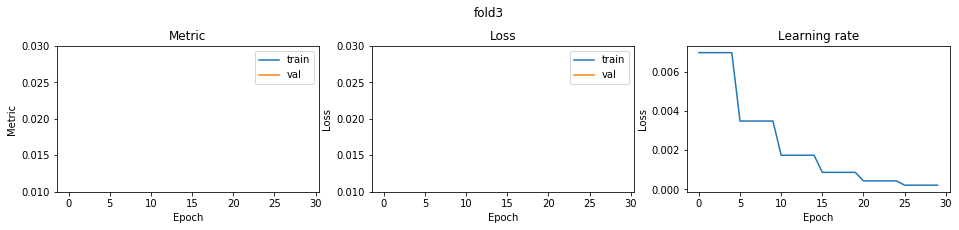

fold 4


epoch1 save best model... 0.7069279157762376
epoch2 save best model... 0.696875861158132
epoch3 save best model... 0.6906787107908644
epoch4 save best model... 0.6819315683054218
epoch5 save best model... 0.6724090404553945
epoch6 save best model... 0.6699826191932574
epoch7 save best model... 0.665913501470127
epoch8 save best model... 0.6613164536502204
epoch9 save best model... 0.6567665673334127
epoch10 save best model... 0.6520688172896522
epoch12 save best model... 0.6492595072216216
epoch13 save best model... 0.6464806064114755
epoch14 save best model... 0.6431724013663098
epoch15 save best model... 0.6430573502542761
epoch16 save best model... 0.6408932386335316
epoch18 save best model... 0.6387239883049203
epoch19 save best model... 0.6373468171762714
epoch20 save best model... 0.6371380961837421
epoch21 save best model... 0.636830651488554
epoch22 save best model... 0.6336697778017483
epoch26 save best model... 0.6331756718066396
epoch27 save best model... 0.6331290952708564


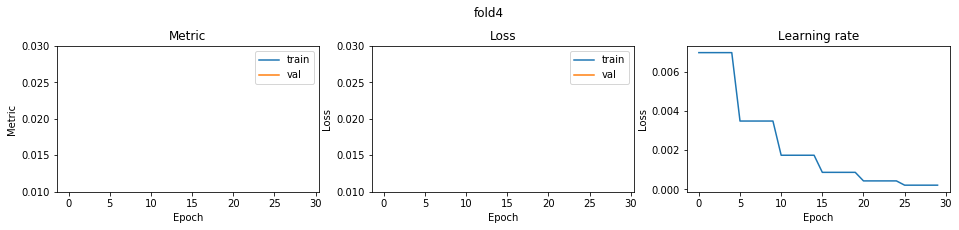

CV score: 0.6308270038355945

optimizer: AdaBelief
fold 0


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01938778491847743
epoch2 save best model... 0.018284793331336594
epoch3 save best model... 0.01779062230657608
epoch4 save best model... 0.017567890902009532
epoch5 save best model... 0.01729370437664296
epoch6 save best model... 0.01683339454140302
epoch7 save best model... 0.016690445186438755
epoch9 save best model... 0.016599737237587335
epoch11 save best model... 0.01631597734919849
epoch13 save best model... 0.016302528676994842
epoch15 save best model... 0.01629399715292698
epoch16 save best model... 0.01625857743517345
fold0 score: 0.01625857744757846


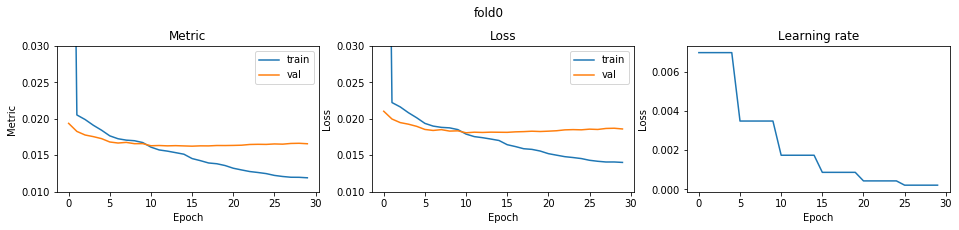

fold 1


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01940356201423711
epoch2 save best model... 0.01859381781306604
epoch3 save best model... 0.018124773202085852
epoch4 save best model... 0.017766322476730365
epoch5 save best model... 0.017381557230119363
epoch6 save best model... 0.01694491588930506
epoch9 save best model... 0.016869036807139876
epoch10 save best model... 0.016864001059615684
epoch11 save best model... 0.016665276161194065
epoch12 save best model... 0.016617367830060424
epoch13 save best model... 0.01660673748459909
epoch16 save best model... 0.016528118108512735
fold1 score: 0.016528118060177427


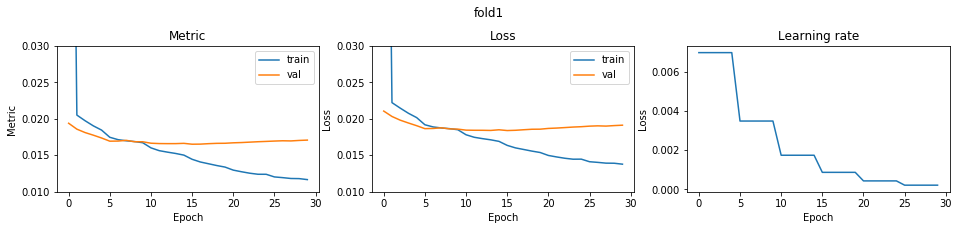

fold 2


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01941170100051393
epoch2 save best model... 0.018378905415972945
epoch3 save best model... 0.01816745876173552
epoch4 save best model... 0.017688444117455487
epoch5 save best model... 0.017297632084286453
epoch6 save best model... 0.016878550604204772
epoch7 save best model... 0.016793190548949725
epoch8 save best model... 0.01674454720717583
epoch9 save best model... 0.016642262005453216
epoch11 save best model... 0.016471728223753045
epoch12 save best model... 0.016446279842252883
epoch13 save best model... 0.016418861319461832
epoch14 save best model... 0.016407880886895192
epoch16 save best model... 0.0163170343857385
fold2 score: 0.016317034275165142


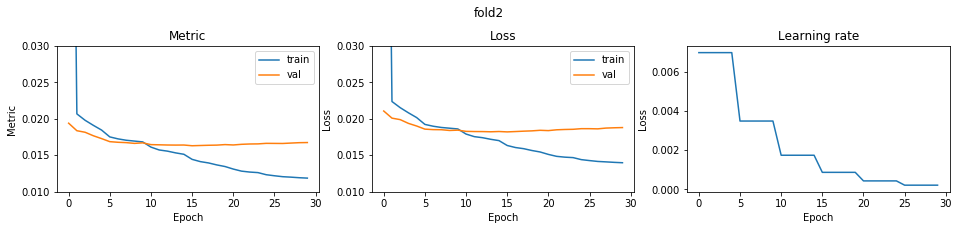

fold 3


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.01962241274909305
epoch2 save best model... 0.01855870462393978
epoch3 save best model... 0.018192201378863466
epoch4 save best model... 0.01766282389564164
epoch5 save best model... 0.017436889730869095
epoch6 save best model... 0.017061057130133644
epoch7 save best model... 0.01705704378961227
epoch8 save best model... 0.016967292566590672
epoch9 save best model... 0.01690668110313543
epoch11 save best model... 0.016622636900421293
epoch12 save best model... 0.01658711244727661
epoch13 save best model... 0.01658081350962638
epoch16 save best model... 0.016494933820429315
fold3 score: 0.016494933563087157


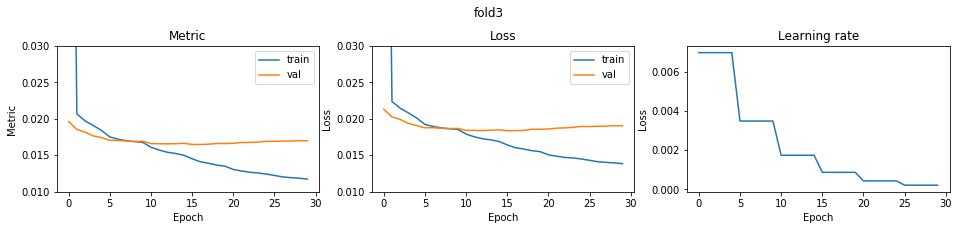

fold 4


Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
Current version (0.1.0)  1e-16  True               True
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


epoch1 save best model... 0.018980976896347788
epoch2 save best model... 0.01833115101607351
epoch3 save best model... 0.01784279203564268
epoch4 save best model... 0.01747249172690721
epoch5 save best model... 0.01738070436755454
epoch6 save best model... 0.01694536231339385
epoch7 save best model... 0.01683360340884104
epoch8 save best model... 0.01683079858261727
epoch9 save best model... 0.01677583924501048
epoch10 save best model... 0.01674059902642406
epoch11 save best model... 0.016519403699064173
epoch16 save best model... 0.0164890360456291
fold4 score: 0.016489035928911717


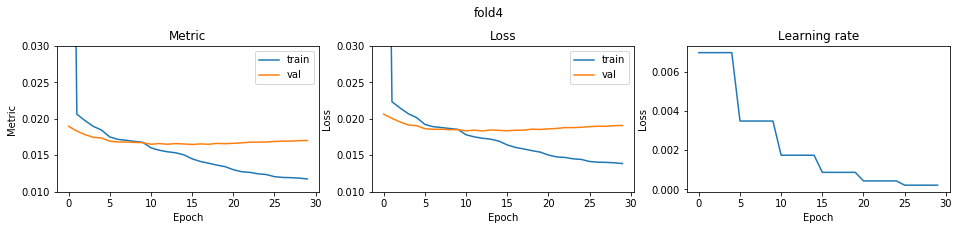

CV score: 0.016417539396052623

optimizer: AdaBound
fold 0


epoch1 save best model... 0.030823903085328723
epoch2 save best model... 0.03043631702271165
fold0 score: 0.030436316966583946


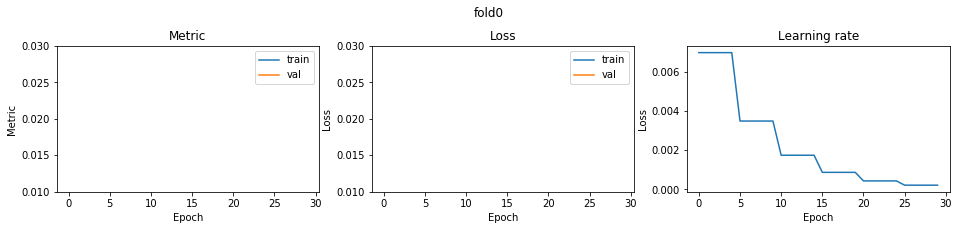

fold 1


epoch1 save best model... 0.031154330809659854
epoch2 save best model... 0.03067467953626972
epoch3 save best model... 0.03066344323741409
fold1 score: 0.030663443249805723


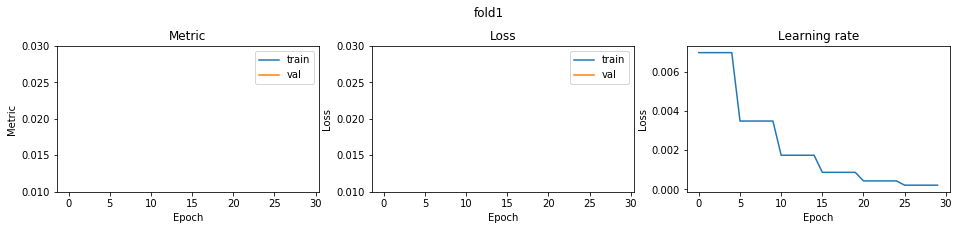

fold 2


epoch1 save best model... 0.030901679942309246
epoch2 save best model... 0.03052460687312661
epoch3 save best model... 0.030444000401816572
fold2 score: 0.03044400038452844


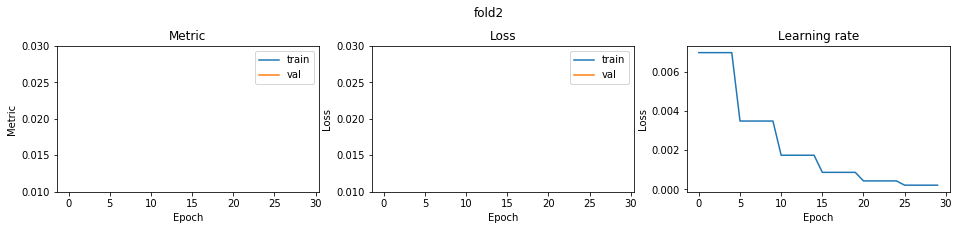

fold 3


epoch1 save best model... 0.03084314563194956
epoch2 save best model... 0.030577150790831224
fold3 score: 0.030577150775724017


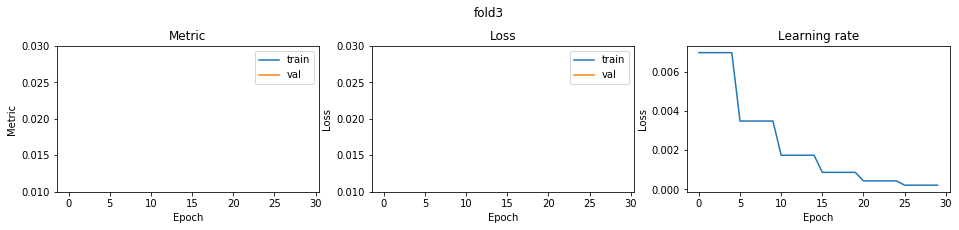

fold 4


epoch1 save best model... 0.03065144387678432
epoch2 save best model... 0.0301996983460454
fold4 score: 0.030199698514568867


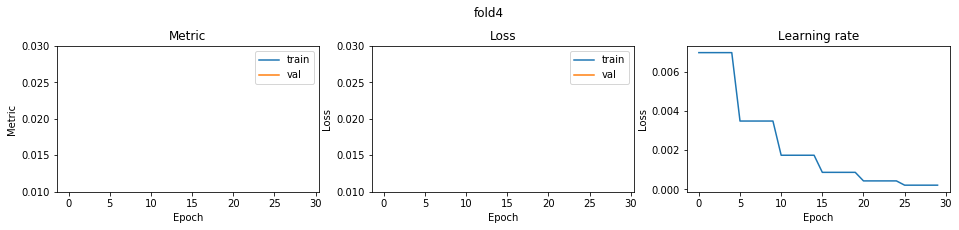

CV score: 0.03046411381350382

optimizer: AdaMod
fold 0


epoch1 save best model... 0.019865779697487727
epoch2 save best model... 0.018414769093410572
epoch3 save best model... 0.018009210480610438
epoch4 save best model... 0.01740203362662591
epoch5 save best model... 0.017249827747125017
epoch6 save best model... 0.016890833318097716
epoch7 save best model... 0.016830297539982275
epoch8 save best model... 0.016575329573421924
epoch10 save best model... 0.016542855377790596
epoch11 save best model... 0.016316035885898427
epoch12 save best model... 0.01625041688849687
epoch14 save best model... 0.016234214346355212
epoch16 save best model... 0.01616641181714171
epoch17 save best model... 0.01616205983754918
fold0 score: 0.016162059800047625


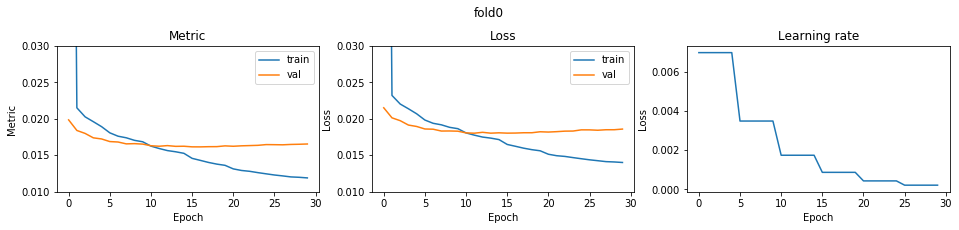

fold 1


epoch1 save best model... 0.020416530580818992
epoch2 save best model... 0.018680696049524784
epoch3 save best model... 0.017875650230481946
epoch4 save best model... 0.017741062674365003
epoch5 save best model... 0.017480279316229794
epoch6 save best model... 0.017259503683972045
epoch7 save best model... 0.01700013025675888
epoch8 save best model... 0.016993585729105348
epoch9 save best model... 0.01683451862414583
epoch11 save best model... 0.016592935316296884
epoch14 save best model... 0.016586166303405377
epoch16 save best model... 0.016566631139957787
fold1 score: 0.016566631030626614


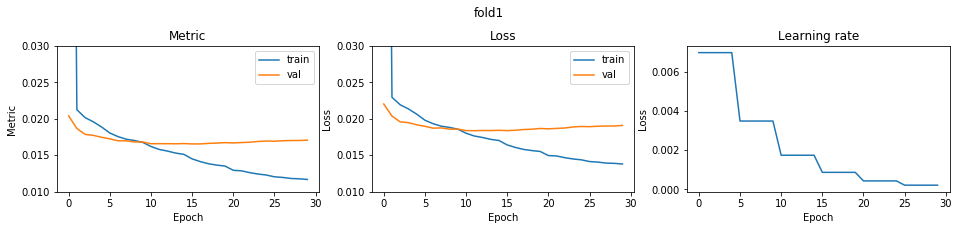

fold 2


epoch1 save best model... 0.020000373051724828
epoch2 save best model... 0.018690331176340946
epoch3 save best model... 0.018071167555073857
epoch4 save best model... 0.017571345715399252
epoch6 save best model... 0.017001339375945588
epoch7 save best model... 0.016904320492092787
epoch8 save best model... 0.016858097288683718
epoch9 save best model... 0.016771125055486273
epoch10 save best model... 0.016653036047685633
epoch11 save best model... 0.0164049564096648
epoch12 save best model... 0.016310262294113975
epoch16 save best model... 0.016282294055255584
epoch17 save best model... 0.016240766401387587
fold2 score: 0.01624076632243421


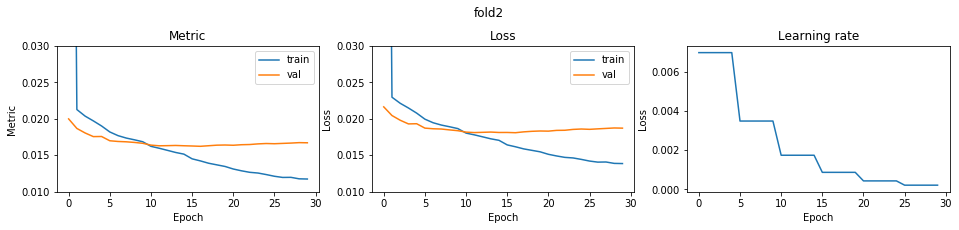

fold 3


epoch1 save best model... 0.02009069213478196
epoch2 save best model... 0.0185721350519797
epoch3 save best model... 0.01815340343506366
epoch4 save best model... 0.017857541636073778
epoch5 save best model... 0.01759711746677994
epoch6 save best model... 0.017145650932281056
epoch7 save best model... 0.01705936402218217
epoch8 save best model... 0.016894229472209626
epoch9 save best model... 0.016812310513779353
epoch10 save best model... 0.016811596803316224
epoch11 save best model... 0.016638980911522765
epoch12 save best model... 0.01657065651029484
epoch13 save best model... 0.016542333106516705
epoch16 save best model... 0.016438992408471253
fold3 score: 0.016438992241098384


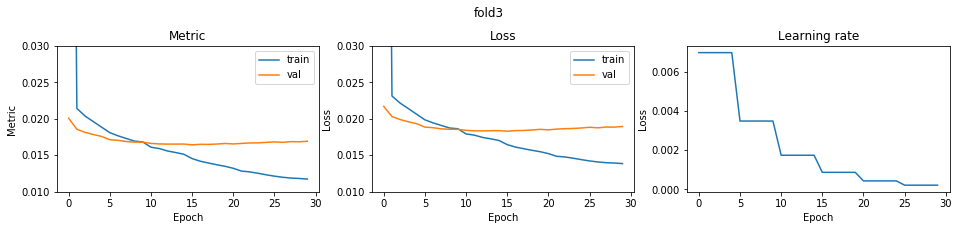

fold 4


epoch1 save best model... 0.019737190327231598
epoch2 save best model... 0.018498935873762352
epoch3 save best model... 0.017958564790292453
epoch4 save best model... 0.01771333179476932
epoch5 save best model... 0.01761804284158763
epoch6 save best model... 0.017142575697078114
epoch7 save best model... 0.0169560517173829
epoch8 save best model... 0.016842517961487006
epoch9 save best model... 0.016839584408238836
epoch10 save best model... 0.01681034435774783
epoch11 save best model... 0.016559542287862383
epoch12 save best model... 0.016552494112868923
epoch13 save best model... 0.01651747430927186
epoch14 save best model... 0.016500548809206702
epoch16 save best model... 0.016406905725768053
fold4 score: 0.016406905644518514


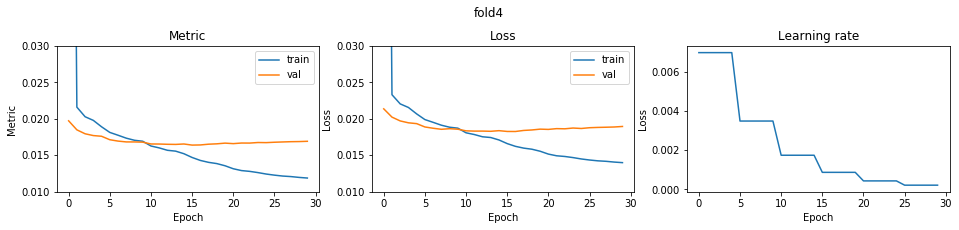

CV score: 0.016363067305570043

optimizer: AdamW
fold 0


epoch1 save best model... 0.0200601369923231
epoch2 save best model... 0.018771440244718943
epoch3 save best model... 0.017983102171357238
epoch4 save best model... 0.01747550238136007
epoch5 save best model... 0.017324049890482616
epoch6 save best model... 0.01693048527324254
epoch7 save best model... 0.016765182386396415
epoch9 save best model... 0.016668776299694134
epoch10 save best model... 0.016507584084852138
epoch11 save best model... 0.016372289300677717
epoch12 save best model... 0.01627994196273064
epoch13 save best model... 0.016255271386414562
epoch16 save best model... 0.01618678734079852
fold0 score: 0.016186787224962564


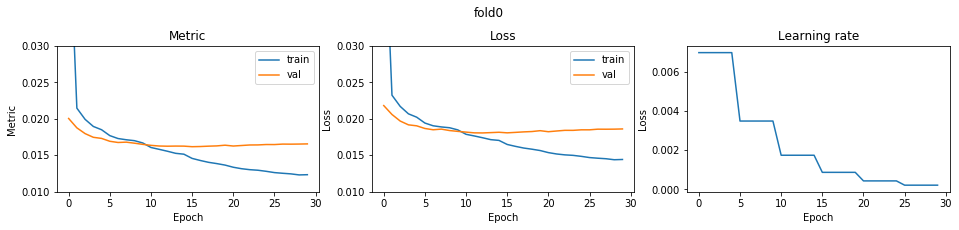

fold 1


epoch1 save best model... 0.020256583791715892
epoch2 save best model... 0.01909754989470537
epoch3 save best model... 0.01813428587176026
epoch4 save best model... 0.017843529061722197
epoch5 save best model... 0.017523892708912095
epoch6 save best model... 0.017114858707257326
epoch7 save best model... 0.017004708542835877
epoch8 save best model... 0.016935381042737303
epoch9 save best model... 0.016892183476354097
epoch10 save best model... 0.016814537044409997
epoch11 save best model... 0.016615354144717844
epoch12 save best model... 0.01657610440825779
epoch13 save best model... 0.01655821811206644
epoch16 save best model... 0.016522168346711892
fold1 score: 0.016522168065760227


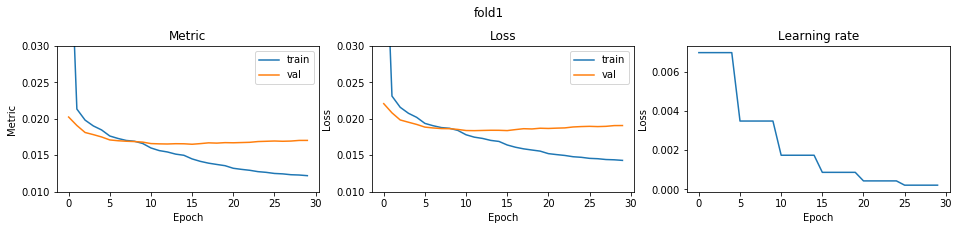

fold 2


epoch1 save best model... 0.019996878658127448
epoch2 save best model... 0.01840182141701978
epoch3 save best model... 0.0180100345868243
epoch4 save best model... 0.01758837811568212
epoch5 save best model... 0.017409648571191427
epoch6 save best model... 0.016882870170822732
epoch7 save best model... 0.01687612601293399
epoch8 save best model... 0.01674317292942086
epoch10 save best model... 0.016705906393350622
epoch11 save best model... 0.016390805668690923
epoch13 save best model... 0.016360844473578808
epoch14 save best model... 0.016342267201817452
epoch16 save best model... 0.01629391600802035
fold2 score: 0.01629391582781083


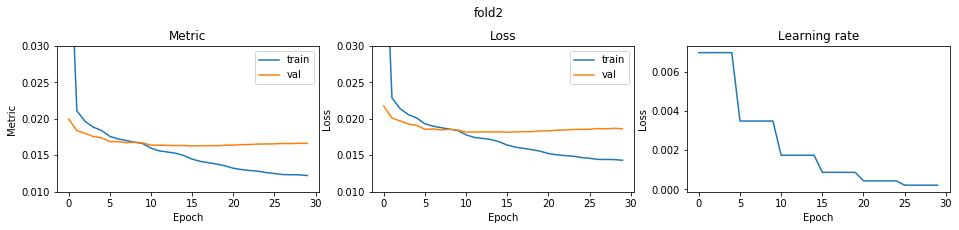

fold 3


epoch1 save best model... 0.020169399422858596
epoch2 save best model... 0.018620108772739598
epoch3 save best model... 0.01807844422265446
epoch4 save best model... 0.017705502841782867
epoch5 save best model... 0.01750117018436992
epoch6 save best model... 0.017168062697917832
epoch7 save best model... 0.01707108618907953
epoch8 save best model... 0.01700947463962171
epoch9 save best model... 0.01685385945590387
epoch10 save best model... 0.016838967809899113
epoch11 save best model... 0.016622204281780063
epoch12 save best model... 0.016611158023408033
epoch14 save best model... 0.016543983887448262
epoch16 save best model... 0.016541571412362788
fold3 score: 0.016541571300639348


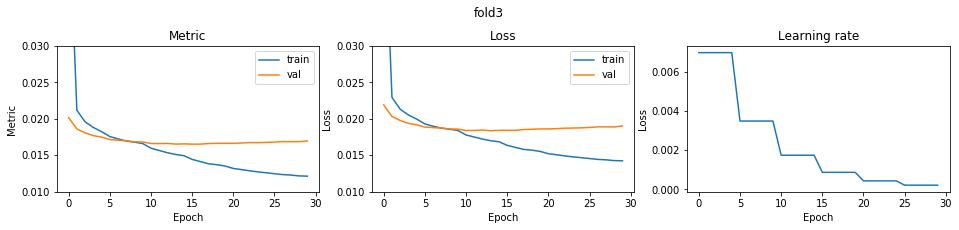

fold 4


epoch1 save best model... 0.019703618824855343
epoch2 save best model... 0.018498217371336962
epoch3 save best model... 0.017994257456417237
epoch4 save best model... 0.017674708600179345
epoch5 save best model... 0.017324988992464704
epoch6 save best model... 0.01698402067294221
epoch7 save best model... 0.016866826167190128
epoch8 save best model... 0.016847281130815694
epoch9 save best model... 0.01675355532217202
epoch10 save best model... 0.01664269688053392
epoch11 save best model... 0.01647765180796113
epoch13 save best model... 0.01646487925685348
epoch14 save best model... 0.016447442512034283
epoch15 save best model... 0.016436485984789077
epoch16 save best model... 0.016391108739603488
fold4 score: 0.01639110875009726


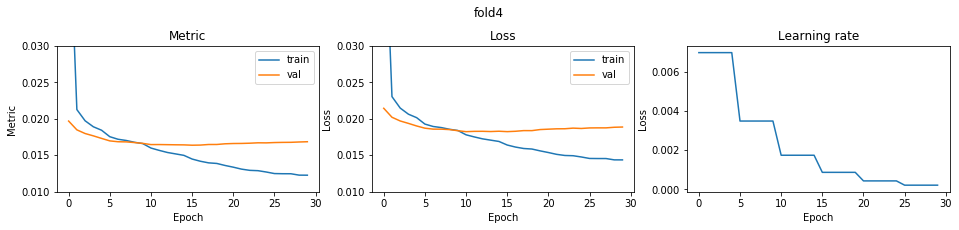

CV score: 0.016387108326462674

optimizer: AdamP
fold 0


epoch1 save best model... 0.019923176166679973
epoch2 save best model... 0.018357120825991814
epoch3 save best model... 0.01774385299338431
epoch4 save best model... 0.01750686323707223
epoch5 save best model... 0.017208426915838942
epoch6 save best model... 0.016913770460831277
epoch7 save best model... 0.016747805181729494
epoch8 save best model... 0.016716912365041182
epoch9 save best model... 0.01661085831277191
epoch10 save best model... 0.016597795251392013
epoch11 save best model... 0.016361254850372774
epoch12 save best model... 0.016297991728253136
epoch14 save best model... 0.016257019477189945
epoch16 save best model... 0.01617264463385919
fold0 score: 0.016172644529868913


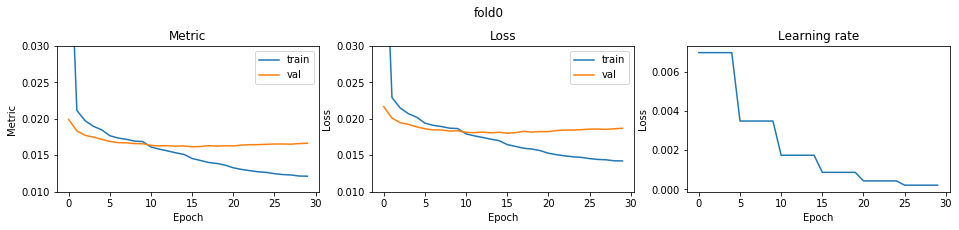

fold 1


epoch1 save best model... 0.020086190762373033
epoch2 save best model... 0.018555019837654542
epoch3 save best model... 0.018141176278698035
epoch4 save best model... 0.017682505566113275
epoch5 save best model... 0.017545463522825298
epoch6 save best model... 0.01705519120658984
epoch7 save best model... 0.017039514643280823
epoch8 save best model... 0.016978206521455656
epoch9 save best model... 0.016908289847683732
epoch11 save best model... 0.01658466547442395
epoch12 save best model... 0.01655378334197063
fold1 score: 0.016553783272758985


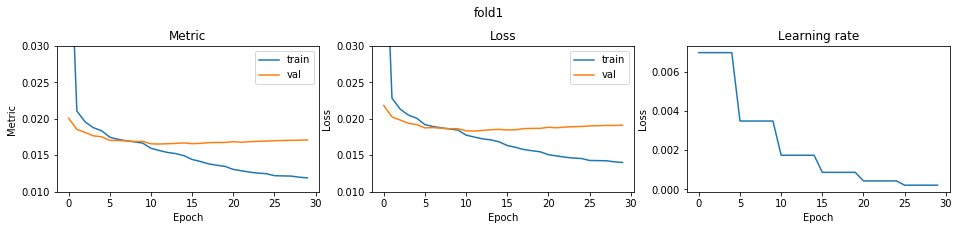

fold 2


epoch1 save best model... 0.020169258787362282
epoch2 save best model... 0.018576888553416247
epoch3 save best model... 0.01788335036733382
epoch4 save best model... 0.017449501763938446
epoch6 save best model... 0.016917217771763967
epoch7 save best model... 0.01681509882608065
epoch8 save best model... 0.016748248819515574
epoch9 save best model... 0.01672888990032439
epoch10 save best model... 0.016671997342851987
epoch11 save best model... 0.0163851613427117
epoch14 save best model... 0.016341810924628924
epoch16 save best model... 0.016291761160360282
fold2 score: 0.01629176102428499


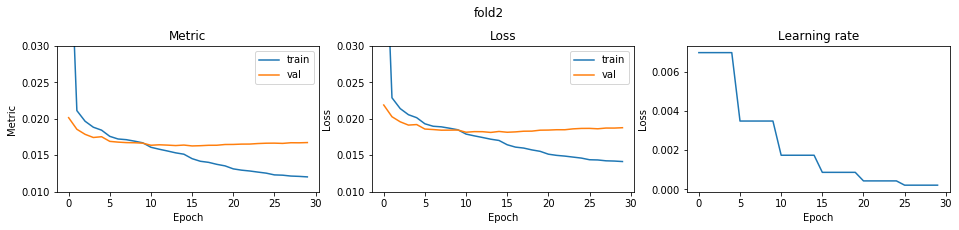

fold 3


epoch1 save best model... 0.0203348841441791
epoch2 save best model... 0.01860048785118348
epoch3 save best model... 0.018113796177038028
epoch4 save best model... 0.01759498648914023
epoch5 save best model... 0.017548700095767446
epoch6 save best model... 0.017128709721079854
epoch7 save best model... 0.01706443802922421
epoch8 save best model... 0.016969484386537097
epoch9 save best model... 0.01683266743601794
epoch10 save best model... 0.01682347612400329
epoch11 save best model... 0.016593777191038148
epoch13 save best model... 0.01658354389071804
epoch16 save best model... 0.01655400901277611
epoch17 save best model... 0.016529828883232317
fold3 score: 0.016529828671800403


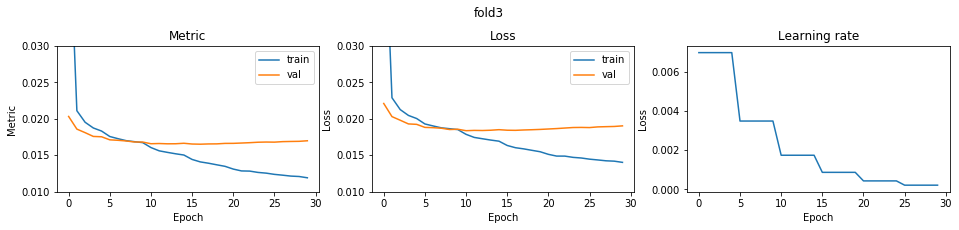

fold 4


epoch1 save best model... 0.01983701015116142
epoch2 save best model... 0.018291696519983386
epoch3 save best model... 0.017806712107346787
epoch4 save best model... 0.017553278755031713
epoch5 save best model... 0.01730320399843479
epoch6 save best model... 0.016932809901485275
epoch7 save best model... 0.016864300329569124
epoch8 save best model... 0.01685305435872363
epoch9 save best model... 0.016802625155717066
epoch10 save best model... 0.016671287650687955
epoch11 save best model... 0.016533379442989826
epoch12 save best model... 0.016457545891370207
epoch16 save best model... 0.016382048168306605
fold4 score: 0.016382048154568393


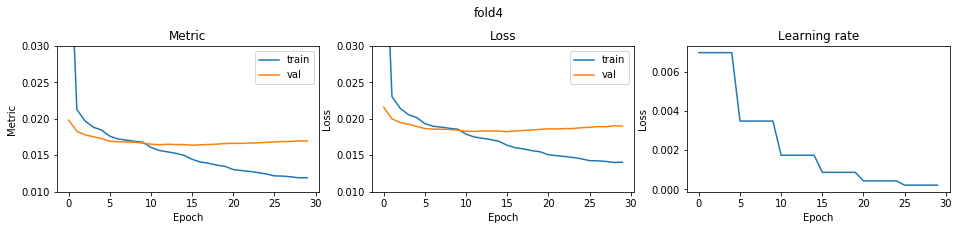

CV score: 0.016386009781010093

optimizer: DiffGrad
fold 0


epoch1 save best model... 0.03170954561654419
fold0 score: 0.03170954564386404


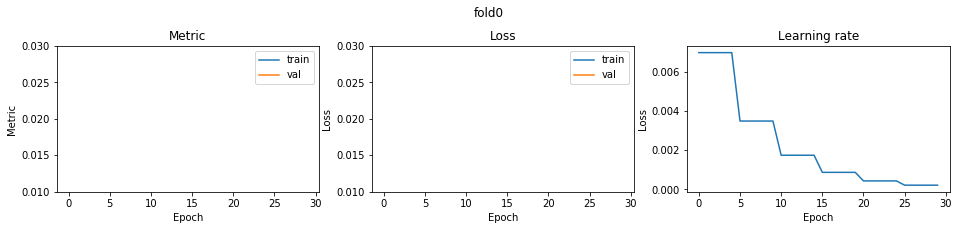

fold 1


epoch1 save best model... 0.03146685013285692
fold1 score: 0.03146685008488902


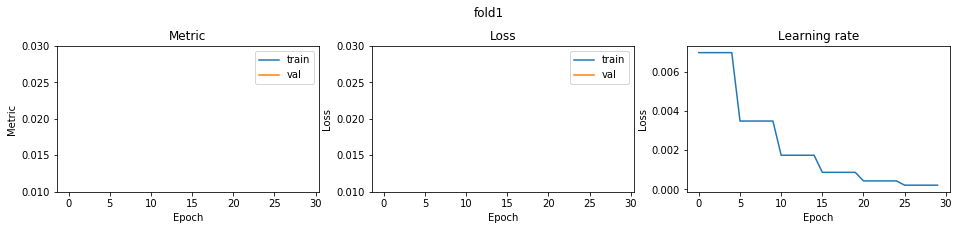

fold 2


epoch1 save best model... 0.03198097421182712
epoch11 save best model... 0.03183324743333018
fold2 score: 0.031833245889831885


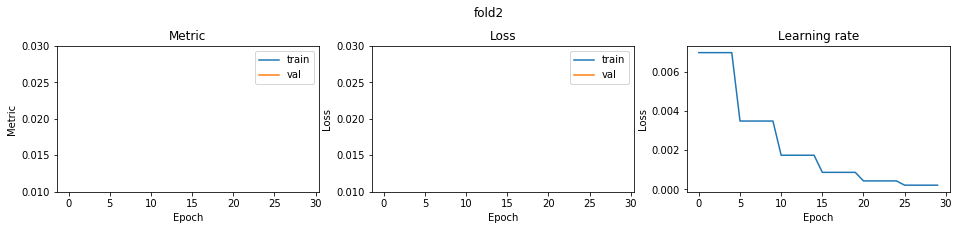

fold 3


epoch1 save best model... 0.03179613929284325
fold3 score: 0.03179613929250763


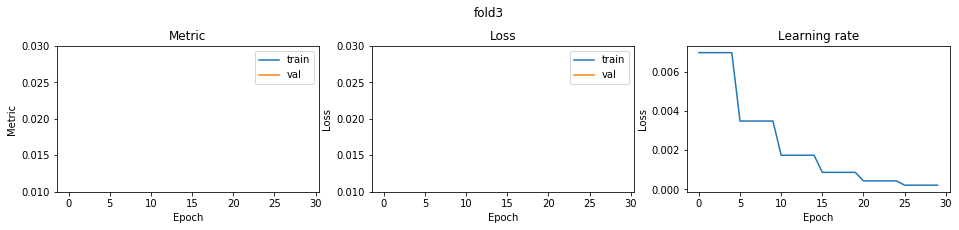

fold 4


epoch1 save best model... 0.03169519930551834
fold4 score: 0.0316951993384835


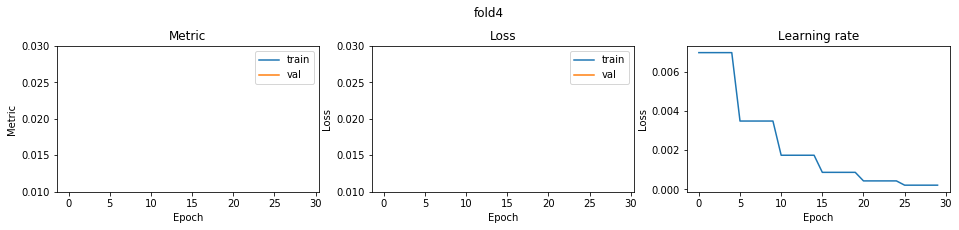

CV score: 0.03170020061963113

optimizer: Lamb
fold 0


epoch1 save best model... 0.02009652682022109
epoch2 save best model... 0.018278673276780406
epoch3 save best model... 0.017875383648351003
epoch4 save best model... 0.017549243337710244
epoch5 save best model... 0.01718069867131243
epoch6 save best model... 0.016861060238814573
epoch7 save best model... 0.016722697463387236
epoch8 save best model... 0.016664005266948008
epoch9 save best model... 0.01657770638076211
epoch10 save best model... 0.016559146666275615
epoch11 save best model... 0.016410362601687534
epoch12 save best model... 0.016378202023735623
epoch13 save best model... 0.016350112794336263
epoch14 save best model... 0.016314116719439796
epoch16 save best model... 0.01626468304553173
epoch18 save best model... 0.01625351461248816
epoch20 save best model... 0.016251981554972962
epoch22 save best model... 0.01624737920108037
epoch29 save best model... 0.016234504965670696
fold0 score: 0.016234504902890416


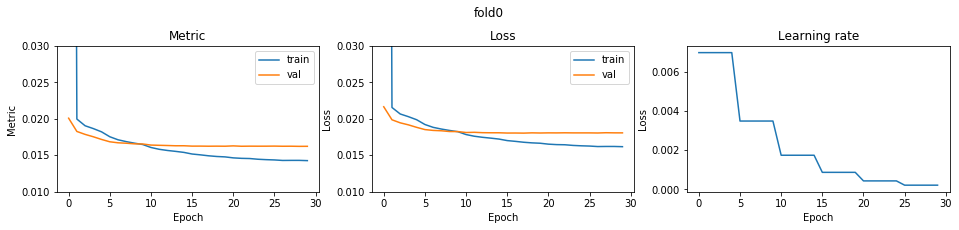

fold 1


epoch1 save best model... 0.020060280970694344
epoch2 save best model... 0.01854534381412786
epoch3 save best model... 0.017889644002966713
epoch4 save best model... 0.017694836276576795
epoch5 save best model... 0.017513642334997803
epoch6 save best model... 0.01716326273668801
epoch7 save best model... 0.017115136310984425
epoch8 save best model... 0.016936549195825823
epoch9 save best model... 0.016907908335603107
epoch10 save best model... 0.016807888588456638
epoch11 save best model... 0.016657157800879476
epoch12 save best model... 0.016638725948061452
epoch13 save best model... 0.016624370097348413
epoch14 save best model... 0.016569030580850772
epoch16 save best model... 0.016543938478934084
epoch18 save best model... 0.016542157343289364
epoch19 save best model... 0.016526604620419404
epoch21 save best model... 0.0164848460146797
fold1 score: 0.016484845988968985


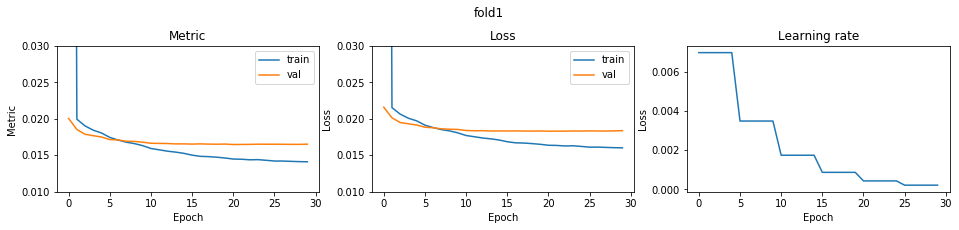

fold 2


epoch1 save best model... 0.019925812817388526
epoch2 save best model... 0.018501956215076103
epoch3 save best model... 0.017796535604678164
epoch4 save best model... 0.017490377483940812
epoch5 save best model... 0.01722479786992915
epoch6 save best model... 0.016860390565169036
epoch7 save best model... 0.016770393008993897
epoch8 save best model... 0.016699755823209553
epoch9 save best model... 0.016634419064745595
epoch10 save best model... 0.016538047582279457
epoch11 save best model... 0.016478405262121416
epoch12 save best model... 0.01645138166678484
epoch13 save best model... 0.016404643349262924
epoch14 save best model... 0.016388079320630376
epoch15 save best model... 0.016368128808746173
epoch16 save best model... 0.01634260064840154
epoch17 save best model... 0.016335846195886527
epoch18 save best model... 0.016316316989168786
epoch20 save best model... 0.016314664298588293
epoch25 save best model... 0.016310104111871136
epoch30 save best model... 0.016304258069994918
fold

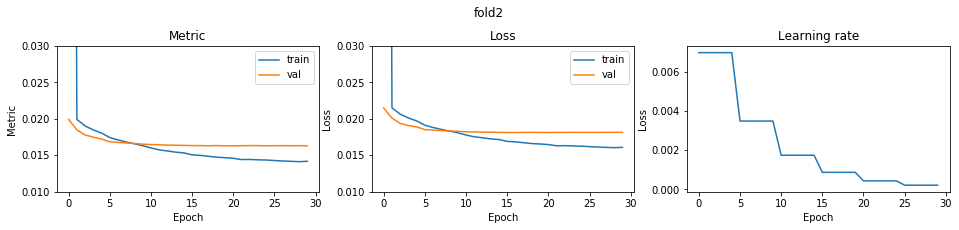

fold 3


epoch1 save best model... 0.020253482108388374
epoch2 save best model... 0.018428848316820852
epoch3 save best model... 0.01790171026470721
epoch4 save best model... 0.017640621360637466
epoch5 save best model... 0.01745873782826176
epoch6 save best model... 0.017167694186091695
epoch7 save best model... 0.01699399825202509
epoch8 save best model... 0.016914513672793237
epoch9 save best model... 0.016779276785909587
epoch11 save best model... 0.016630317684441193
epoch12 save best model... 0.016606521867809643
epoch13 save best model... 0.01659413668918922
epoch15 save best model... 0.016583581837763955
epoch16 save best model... 0.01653982769731848
epoch17 save best model... 0.0165077810606374
epoch18 save best model... 0.016487397718113892
epoch19 save best model... 0.01647998054717627
epoch24 save best model... 0.016473832664107544
fold3 score: 0.016473832589215153


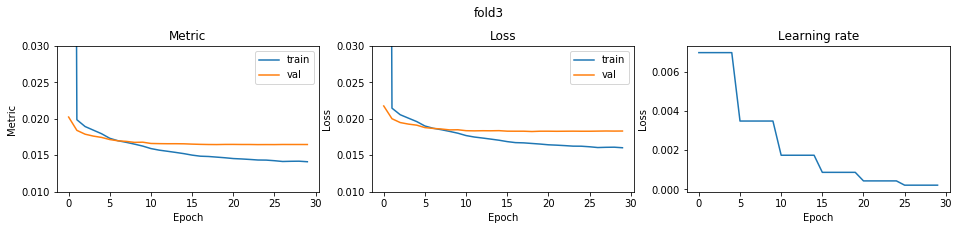

fold 4


epoch1 save best model... 0.019799647923211032
epoch2 save best model... 0.018387359032801996
epoch3 save best model... 0.01784487542672961
epoch4 save best model... 0.01763226294546369
epoch5 save best model... 0.01731929756140926
epoch6 save best model... 0.01704635540392581
epoch7 save best model... 0.016958828596716453
epoch8 save best model... 0.016812471663982424
epoch9 save best model... 0.016714745077701255
epoch11 save best model... 0.016564959299099336
epoch12 save best model... 0.016519507932092715
epoch13 save best model... 0.01651327692371091
epoch14 save best model... 0.016494391303602817
epoch15 save best model... 0.016472687288813275
epoch16 save best model... 0.016430784958777502
epoch17 save best model... 0.01640203233282156
epoch23 save best model... 0.0163967448619782
fold4 score: 0.016396744622955383


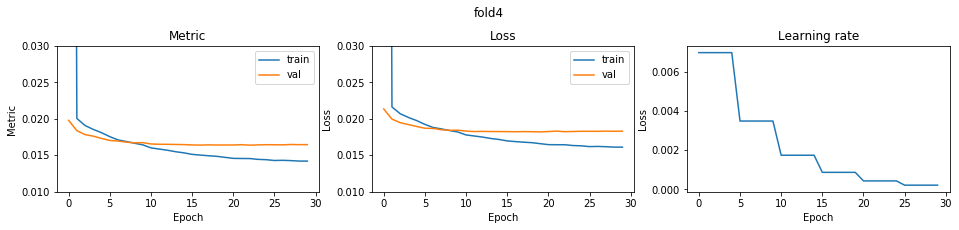

CV score: 0.01637883578852328

optimizer: NovoGrad
fold 0


epoch1 save best model... 0.018574860748879457
epoch2 save best model... 0.017657787730420912
epoch3 save best model... 0.017414246547907793
epoch4 save best model... 0.017084211322366514
epoch5 save best model... 0.017024968573844786
epoch6 save best model... 0.01666340782712288
epoch7 save best model... 0.016505250304190606
epoch8 save best model... 0.016500644688335394
epoch9 save best model... 0.016390929587507846
epoch10 save best model... 0.016323462936492606
epoch11 save best model... 0.016307149070542058
epoch12 save best model... 0.016203779147212355
epoch15 save best model... 0.016147021653134894
epoch17 save best model... 0.016135549061594357
epoch19 save best model... 0.016123963135945905
epoch20 save best model... 0.016074515412007894
fold0 score: 0.016074515432183332


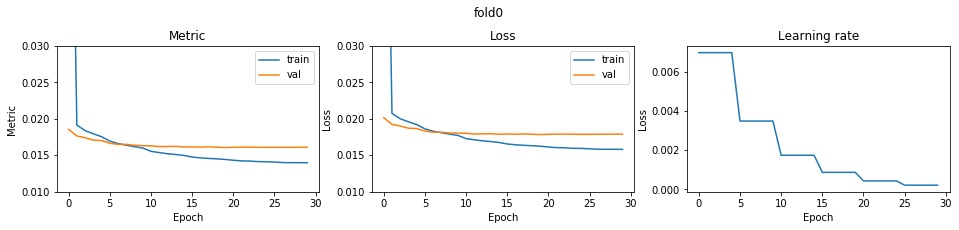

fold 1


epoch1 save best model... 0.018797861674440208
epoch2 save best model... 0.018021496681220224
epoch3 save best model... 0.01769672802125954
epoch4 save best model... 0.01738248346850877
epoch5 save best model... 0.01729373831372376
epoch6 save best model... 0.016967664807814215
epoch7 save best model... 0.016816607230625356
epoch8 save best model... 0.016758855293708814
epoch9 save best model... 0.01674010407215243
epoch10 save best model... 0.016655677102810025
epoch11 save best model... 0.016515376139453412
epoch12 save best model... 0.016506378197697482
epoch15 save best model... 0.016491914425604597
epoch17 save best model... 0.01647150623604679
epoch20 save best model... 0.016471146993800798
epoch23 save best model... 0.016469330998172816
fold1 score: 0.016469330916371143


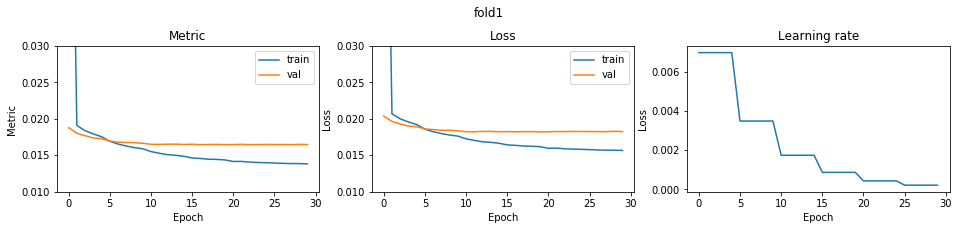

fold 2


epoch1 save best model... 0.018563468417496093
epoch2 save best model... 0.017840433417630374
epoch3 save best model... 0.017614392827246503
epoch4 save best model... 0.0171778069719533
epoch5 save best model... 0.017054513758644682
epoch6 save best model... 0.016678121757024537
epoch7 save best model... 0.016577869731789433
epoch8 save best model... 0.016557479385896842
epoch9 save best model... 0.016518198240588266
epoch10 save best model... 0.016419700755361925
epoch11 save best model... 0.016289963880517767
epoch12 save best model... 0.01625173174478852
epoch13 save best model... 0.016238722876588545
epoch15 save best model... 0.01622728262063541
epoch17 save best model... 0.01617261360504037
fold2 score: 0.01617261355295494


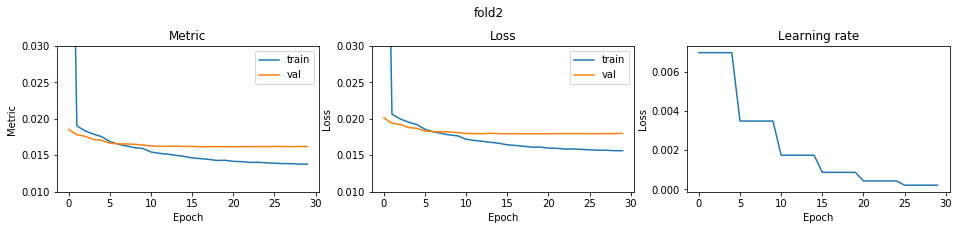

fold 3


epoch1 save best model... 0.01876856371726425
epoch2 save best model... 0.017953564684439222
epoch3 save best model... 0.017551088980176318
epoch4 save best model... 0.01740150001909847
epoch5 save best model... 0.017191611151879223
epoch6 save best model... 0.01689033645092762
epoch7 save best model... 0.01682128554384027
epoch8 save best model... 0.016783172757723338
epoch9 save best model... 0.016639977892551037
epoch10 save best model... 0.016601130480460125
epoch11 save best model... 0.016462004468150455
epoch12 save best model... 0.01642067190429412
epoch15 save best model... 0.016388234333612518
epoch16 save best model... 0.016361453799967885
epoch17 save best model... 0.016350304691761665
epoch19 save best model... 0.01634664076098277
epoch21 save best model... 0.01628832391045292
fold3 score: 0.016288323765210305


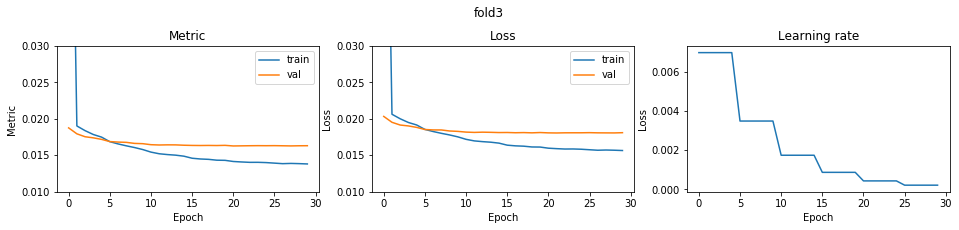

fold 4


epoch1 save best model... 0.0184251694827593
epoch2 save best model... 0.0178729159986613
epoch3 save best model... 0.017454279528544676
epoch4 save best model... 0.017207591857226534
epoch5 save best model... 0.01707978647388942
epoch6 save best model... 0.016826468361605274
epoch7 save best model... 0.016673064953594517
epoch8 save best model... 0.016607883020997864
epoch9 save best model... 0.016550144635921596
epoch10 save best model... 0.0164665769178904
epoch11 save best model... 0.01642509976567399
epoch12 save best model... 0.016390844892735904
epoch13 save best model... 0.01636352649421043
epoch16 save best model... 0.016332331493683582
epoch17 save best model... 0.01630150073277923
fold4 score: 0.01630150065592173


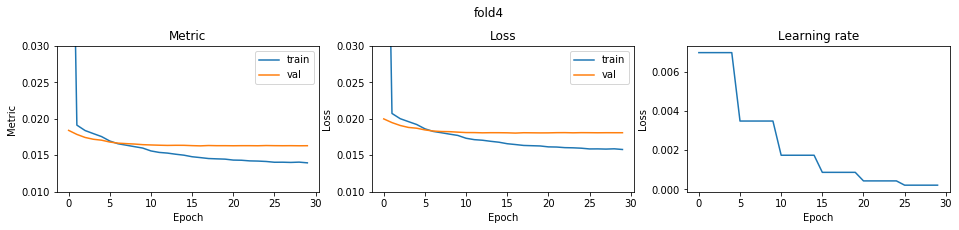

CV score: 0.016261251422996476

optimizer: PlainRAdam
fold 0


epoch1 save best model... 0.02033859429571243
epoch2 save best model... 0.018903836617267484
epoch3 save best model... 0.0182297934262519
epoch4 save best model... 0.01778877754876038
epoch5 save best model... 0.017441025436569457
epoch6 save best model... 0.017027679119674927
epoch7 save best model... 0.01691621033419645
epoch8 save best model... 0.01687425448387386
epoch9 save best model... 0.016788089591882494
epoch10 save best model... 0.01667337216487778
epoch11 save best model... 0.01640643950271715
epoch12 save best model... 0.016377315096608055
epoch13 save best model... 0.016308865299478073
epoch15 save best model... 0.016285496016281206
epoch16 save best model... 0.01618390032100854
fold0 score: 0.016183900270409092


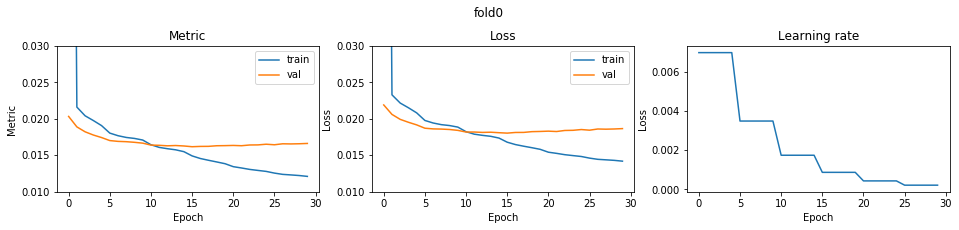

fold 1


epoch1 save best model... 0.020445931998227283
epoch2 save best model... 0.019165705906439002
epoch3 save best model... 0.018492097637683363
epoch4 save best model... 0.017912839747087697
epoch5 save best model... 0.017660467419667245
epoch6 save best model... 0.017219484280595394
epoch7 save best model... 0.01710532084625154
epoch8 save best model... 0.017036437649194106
epoch9 save best model... 0.017014519261621917
epoch10 save best model... 0.016916123452036386
epoch11 save best model... 0.016700701341397957
epoch12 save best model... 0.01666414142028431
epoch13 save best model... 0.016634563101240403
epoch16 save best model... 0.016510809918130944
fold1 score: 0.016510809852873527


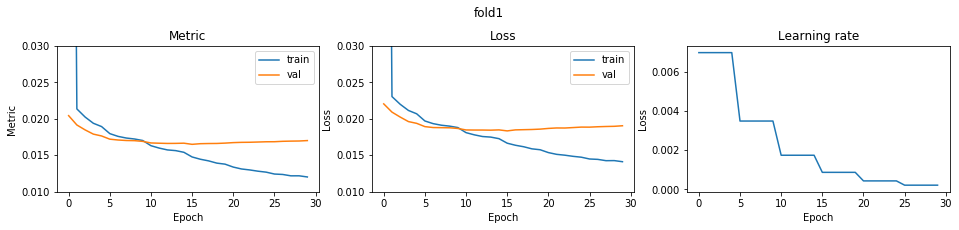

fold 2


epoch1 save best model... 0.02054939140546808
epoch2 save best model... 0.019136506039628028
epoch3 save best model... 0.018245673001467788
epoch4 save best model... 0.017878508619246055
epoch5 save best model... 0.01753449225452372
epoch6 save best model... 0.017060302744546764
epoch7 save best model... 0.017006545756661516
epoch8 save best model... 0.016954866217567713
epoch10 save best model... 0.016842533410950142
epoch11 save best model... 0.016465609480484075
epoch12 save best model... 0.016435074292320235
epoch15 save best model... 0.01642058726899219
epoch16 save best model... 0.016305688947293204
fold2 score: 0.016305688859497448


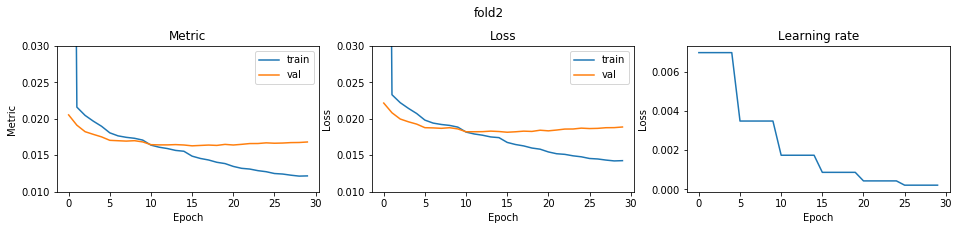

fold 3


epoch1 save best model... 0.02046349021120332
epoch2 save best model... 0.019012503025539914
epoch3 save best model... 0.018233308524894687
epoch4 save best model... 0.018007329876846497
epoch5 save best model... 0.017701245239747004
epoch6 save best model... 0.01717007540989506
epoch7 save best model... 0.017157936984236122
epoch8 save best model... 0.017082786543086884
epoch9 save best model... 0.01702439704006177
epoch10 save best model... 0.016860076830911203
epoch11 save best model... 0.01673695117294585
epoch12 save best model... 0.016642034739035274
epoch13 save best model... 0.016613159120371375
epoch15 save best model... 0.016603136448304176
epoch16 save best model... 0.016448342148426724
fold3 score: 0.016448342120136177


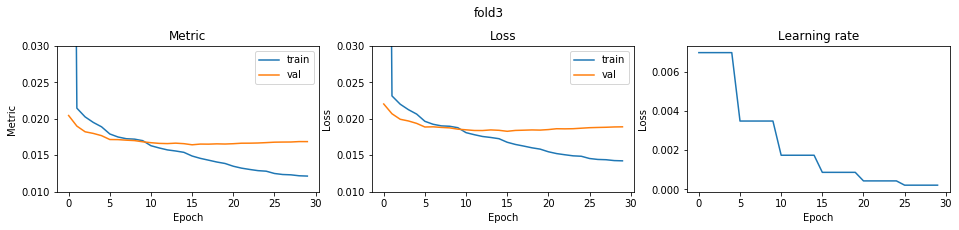

fold 4


epoch1 save best model... 0.020069285761352824
epoch2 save best model... 0.018831315552624864
epoch3 save best model... 0.018042452819645404
epoch4 save best model... 0.017818315180362223
epoch5 save best model... 0.017736217741067425
epoch6 save best model... 0.017143096124800028
epoch7 save best model... 0.01711943063986804
epoch8 save best model... 0.01705860384911774
epoch9 save best model... 0.016951435354616757
epoch10 save best model... 0.016902685294390266
epoch11 save best model... 0.016592374012926445
epoch12 save best model... 0.016553979195179185
epoch13 save best model... 0.016479999602163436
fold4 score: 0.016479999519250825


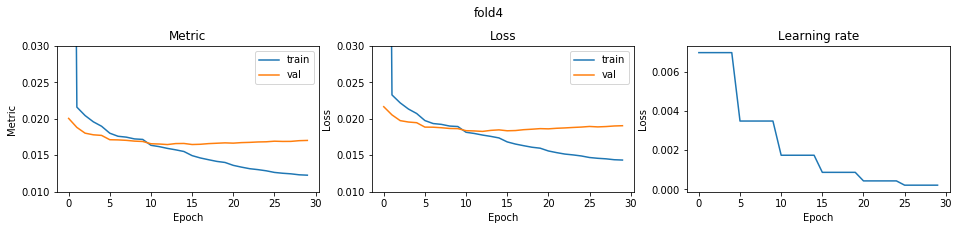

CV score: 0.01638574607402046

optimizer: QHAdam
fold 0


epoch1 save best model... 0.03179580162625106
fold0 score: 0.031795801639117535


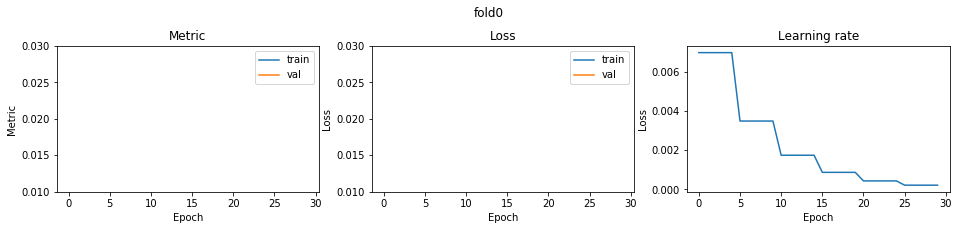

fold 1


epoch1 save best model... 0.031973484470696784
epoch2 save best model... 0.031887146458623894
epoch14 save best model... 0.03180972906540401
fold1 score: 0.031809731707732075


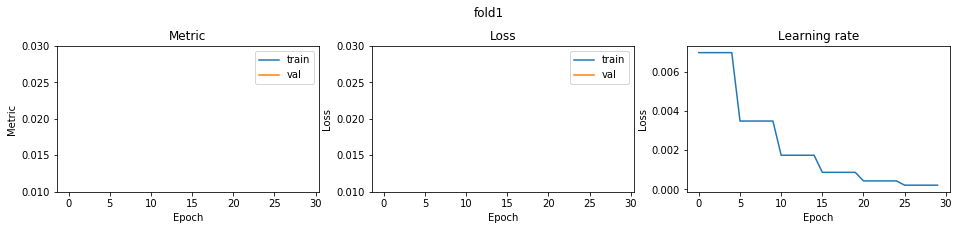

fold 2


epoch1 save best model... 0.03213910545579161
epoch9 save best model... 0.03201715028905249
epoch11 save best model... 0.031960771259325296
fold2 score: 0.03196076906324063


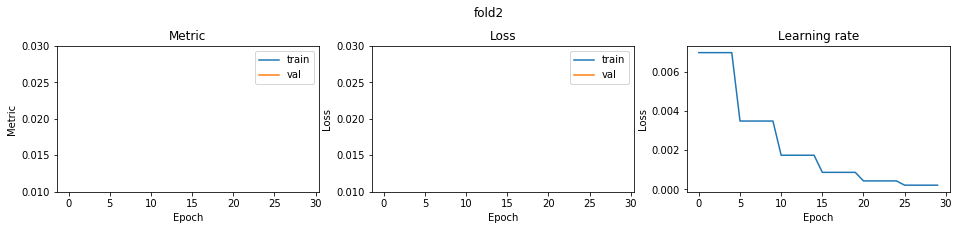

fold 3


epoch1 save best model... 0.03194150930028706
epoch8 save best model... 0.03174232452819315
fold3 score: 0.03174232350606837


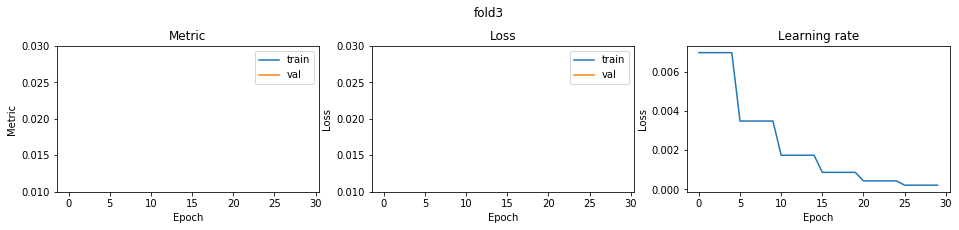

fold 4


epoch1 save best model... 0.03221664188391527
epoch2 save best model... 0.03201454308113096
epoch11 save best model... 0.031989595801452844
epoch27 save best model... 0.031979638516291944
epoch28 save best model... 0.03193958582089268
fold4 score: 0.031939585871710224


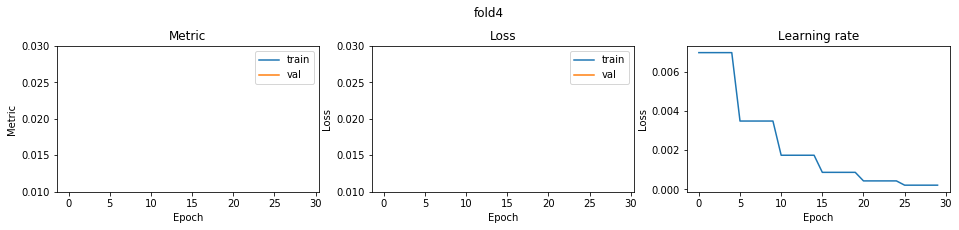

CV score: 0.031849639112810885

optimizer: RAdam
fold 0


epoch1 save best model... 0.0208583637011282
epoch2 save best model... 0.019109297062616142
epoch3 save best model... 0.01818609707872118
epoch4 save best model... 0.017791037864830335
epoch5 save best model... 0.017512364998663477
epoch6 save best model... 0.017019261556395365
epoch7 save best model... 0.016821168731380433
epoch9 save best model... 0.01671847698611795
epoch10 save best model... 0.016641336520773133
epoch11 save best model... 0.016415538968081355
epoch12 save best model... 0.016354335667162385
epoch13 save best model... 0.016316677977867712
epoch15 save best model... 0.016309218243579116
epoch16 save best model... 0.01620794030029437
fold0 score: 0.016207940074667165


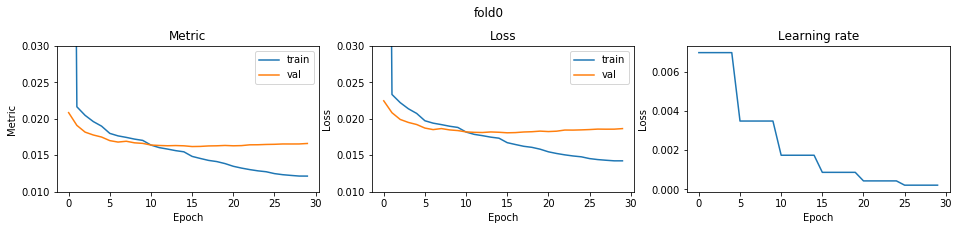

fold 1


epoch1 save best model... 0.02048315357448273
epoch2 save best model... 0.0189724876610089
epoch3 save best model... 0.01853179572310106
epoch4 save best model... 0.017885353463736067
epoch5 save best model... 0.017649512812257573
epoch6 save best model... 0.017129780588415657
epoch7 save best model... 0.01709222525492307
epoch8 save best model... 0.017063683509575423
epoch9 save best model... 0.016970992889777284
epoch10 save best model... 0.016956324962821425
epoch11 save best model... 0.016621381331699454
epoch12 save best model... 0.01654523473439238
epoch14 save best model... 0.0165447995595432
epoch16 save best model... 0.016533806801646928
epoch18 save best model... 0.016516781617257312
fold1 score: 0.01651678143924158


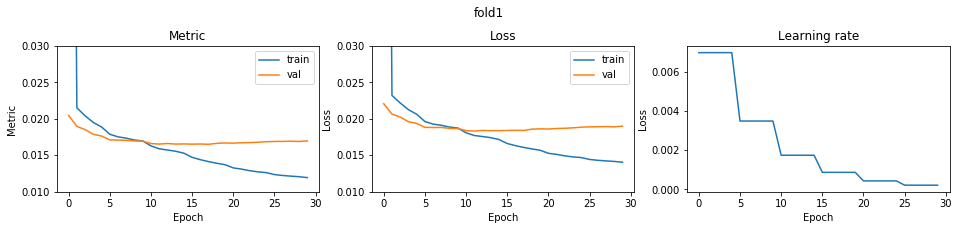

fold 2


epoch1 save best model... 0.020539045003687337
epoch2 save best model... 0.019204774952526923
epoch3 save best model... 0.018319662145151586
epoch4 save best model... 0.017906617125809043
epoch5 save best model... 0.017630572680542644
epoch6 save best model... 0.0170002281665802
epoch7 save best model... 0.01686878403571071
epoch9 save best model... 0.01679019655121584
epoch10 save best model... 0.01671101814901932
epoch11 save best model... 0.016449521389516362
epoch13 save best model... 0.01642321491171346
epoch15 save best model... 0.01639027201045813
epoch16 save best model... 0.01628936183299147
epoch17 save best model... 0.016274008132206686
epoch18 save best model... 0.01627189880646519
fold2 score: 0.01627189882875304


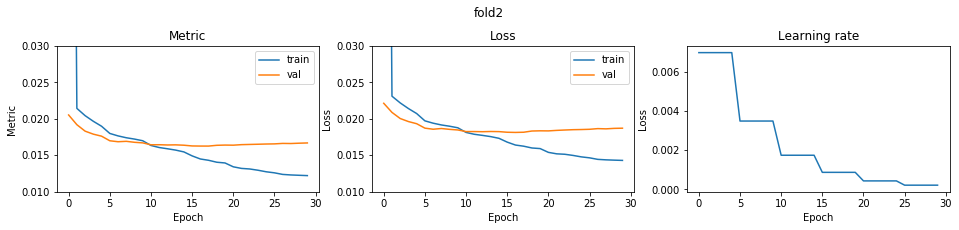

fold 3


epoch1 save best model... 0.020637928438213802
epoch2 save best model... 0.01885196581856265
epoch3 save best model... 0.018677410995481633
epoch4 save best model... 0.017922131675200067
epoch5 save best model... 0.01768720779389754
epoch6 save best model... 0.017145751479478524
epoch7 save best model... 0.016971410225847722
epoch8 save best model... 0.016969553047286215
epoch10 save best model... 0.01686870820676072
epoch11 save best model... 0.016667645483581107
epoch12 save best model... 0.01657555669266094
epoch13 save best model... 0.01656749140416062
epoch14 save best model... 0.01650985539731716
epoch16 save best model... 0.016478308309760614
epoch17 save best model... 0.016454483823668306
fold3 score: 0.016454483711305694


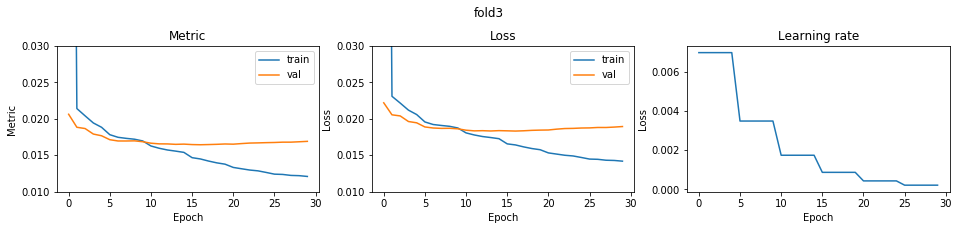

fold 4


epoch1 save best model... 0.02009826918940881
epoch2 save best model... 0.018672077144774056
epoch3 save best model... 0.017984507701323624
epoch4 save best model... 0.017681118004567124
epoch6 save best model... 0.01709232024619343
epoch7 save best model... 0.017086772509088955
epoch8 save best model... 0.01699929384128583
epoch9 save best model... 0.01691182421600968
epoch10 save best model... 0.016874961639438375
epoch11 save best model... 0.01653290026925148
epoch16 save best model... 0.016427440733006032
fold4 score: 0.016427440713877185


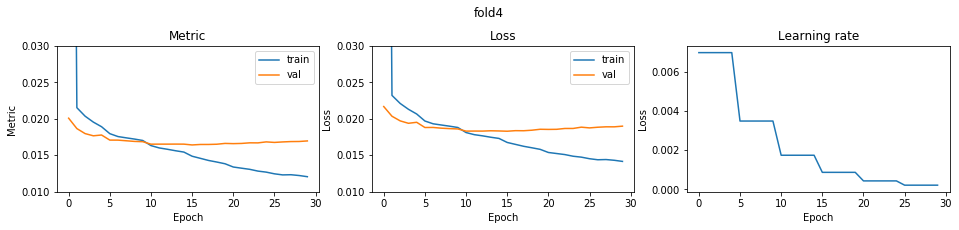

CV score: 0.016375707255812378

optimizer: Ranger
fold 0


epoch1 save best model... 0.021413188327553602
epoch2 save best model... 0.01956789505780422
epoch3 save best model... 0.018543171788436404
epoch4 save best model... 0.017935227884450643
epoch5 save best model... 0.01761558646917479
epoch6 save best model... 0.017199344608024747
epoch7 save best model... 0.01704814348938389
epoch8 save best model... 0.016879489070869523
epoch9 save best model... 0.016775173691349583
epoch10 save best model... 0.01669432005605285
epoch11 save best model... 0.016466210912785797
epoch12 save best model... 0.0164116640730097
epoch13 save best model... 0.01630984856694054
epoch14 save best model... 0.01626922200457246
epoch15 save best model... 0.016268448717467878
epoch16 save best model... 0.016169825762696988
epoch17 save best model... 0.016159763087461233
epoch18 save best model... 0.016110073806026394
fold0 score: 0.016110073706147848


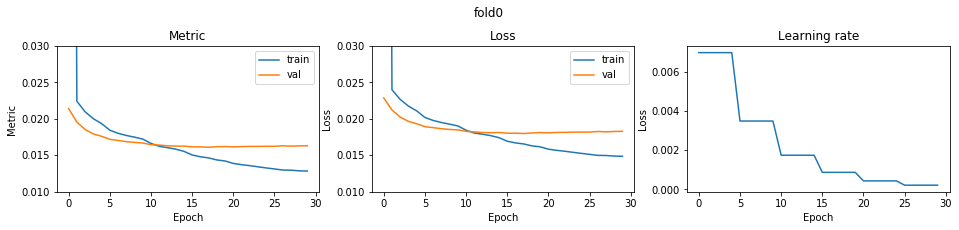

fold 1


epoch1 save best model... 0.02182060088830756
epoch2 save best model... 0.019553984689156406
epoch3 save best model... 0.018852371976244665
epoch4 save best model... 0.018215417361583355
epoch5 save best model... 0.01787815538126153
epoch6 save best model... 0.017352698782259864
epoch7 save best model... 0.017136704259208095
epoch9 save best model... 0.016961563277567784
epoch10 save best model... 0.016917231198384133
epoch11 save best model... 0.016636286348895538
epoch12 save best model... 0.01660912826497725
epoch13 save best model... 0.016554059718787928
epoch14 save best model... 0.016535409725141514
epoch15 save best model... 0.016489505061638276
epoch16 save best model... 0.016407457876532056
epoch17 save best model... 0.01640490536092286
fold1 score: 0.016404905099195056


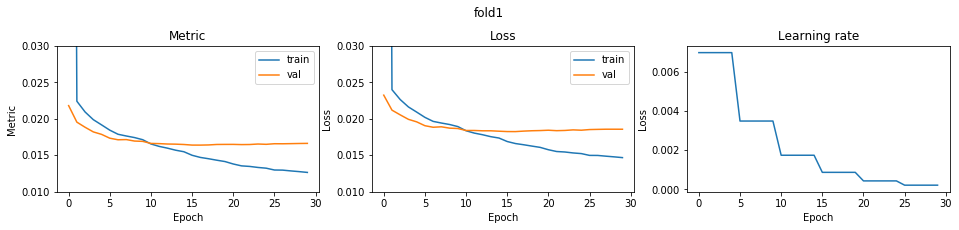

fold 2


epoch1 save best model... 0.021213365225157453
epoch2 save best model... 0.019863654864456706
epoch3 save best model... 0.01871891518026475
epoch4 save best model... 0.01813100523462421
epoch5 save best model... 0.017643386955585396
epoch6 save best model... 0.01723105232465794
epoch7 save best model... 0.017052377748994235
epoch8 save best model... 0.01689925114884141
epoch9 save best model... 0.016849987407245283
epoch10 save best model... 0.016696869922552735
epoch11 save best model... 0.01640436344598177
epoch12 save best model... 0.01634430357862555
epoch16 save best model... 0.016266762871209487
epoch17 save best model... 0.0162143693866807
fold2 score: 0.016214369280925837


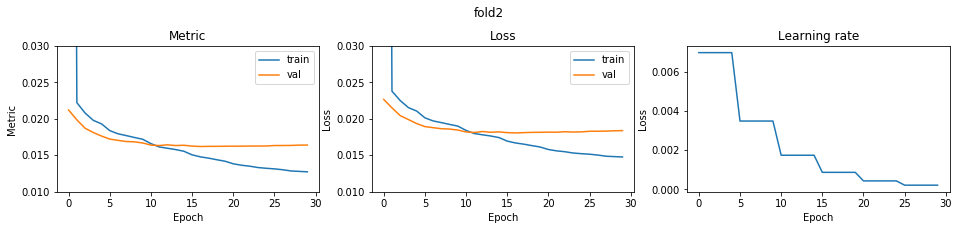

fold 3


epoch1 save best model... 0.021594691621924587
epoch2 save best model... 0.01975662219200224
epoch3 save best model... 0.01862051563129542
epoch4 save best model... 0.018051432056568884
epoch5 save best model... 0.01787014512688872
epoch6 save best model... 0.017324748835133935
epoch7 save best model... 0.01725722117845928
epoch8 save best model... 0.0172086651379705
epoch9 save best model... 0.01697155688093776
epoch10 save best model... 0.01692844233719594
epoch11 save best model... 0.01668527452041796
epoch12 save best model... 0.016614199464966742
epoch13 save best model... 0.01659216759323327
epoch14 save best model... 0.016552629272171333
epoch15 save best model... 0.01650694375072769
epoch16 save best model... 0.016392353912369945
fold3 score: 0.016392353770946003


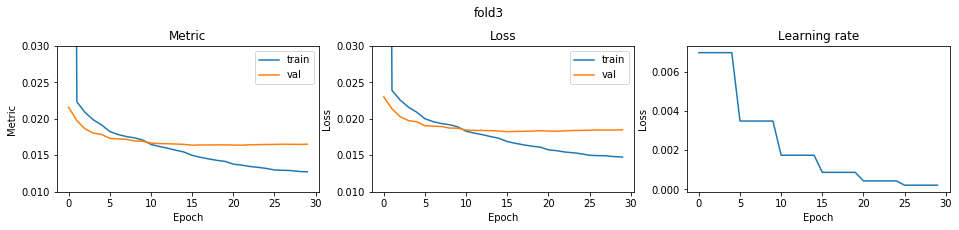

fold 4


epoch1 save best model... 0.02103923326082409
epoch2 save best model... 0.019285151283500678
epoch3 save best model... 0.01837071098412699
epoch4 save best model... 0.017768463117743
epoch5 save best model... 0.01758995258242978
epoch6 save best model... 0.017154367130190338
epoch7 save best model... 0.017052213908311038
epoch8 save best model... 0.01685229810866992
epoch11 save best model... 0.016530764949824108
epoch13 save best model... 0.016512058728325747
epoch14 save best model... 0.01647605717793141
epoch16 save best model... 0.016409331764219697
fold4 score: 0.01640933169164945


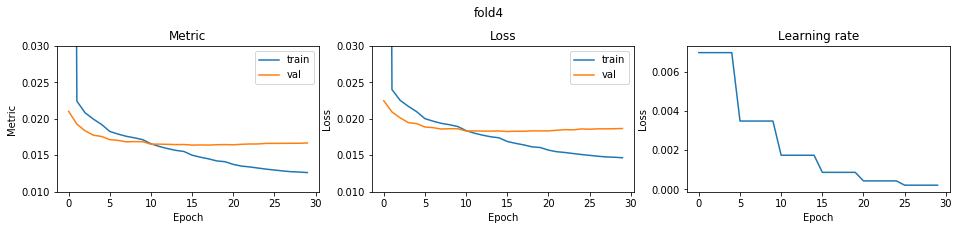

CV score: 0.01630620639717212

optimizer: RangerQH
fold 0


epoch1 save best model... 0.03144193725461026
fold0 score: 0.031441937192957965


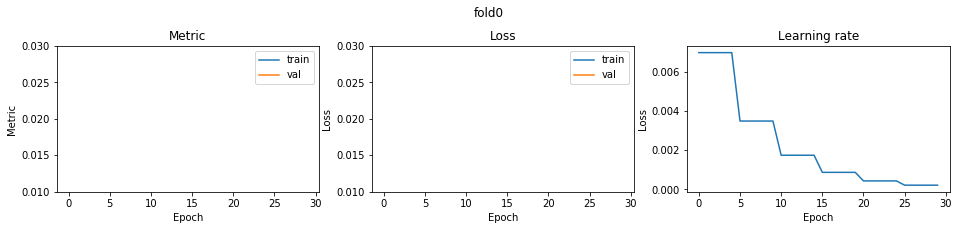

fold 1


epoch1 save best model... 0.031711044312406164
fold1 score: 0.031711044206958576


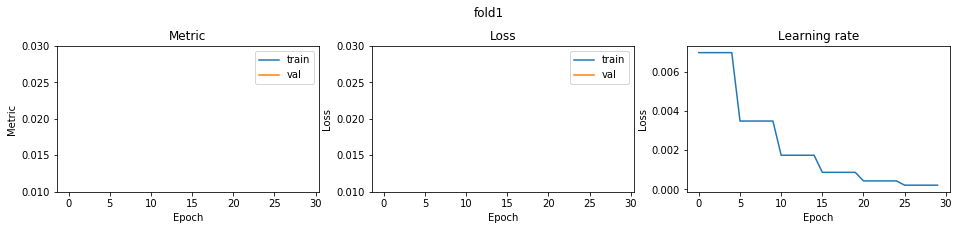

fold 2


epoch1 save best model... 0.031528690853214504
fold2 score: 0.03152869086340632


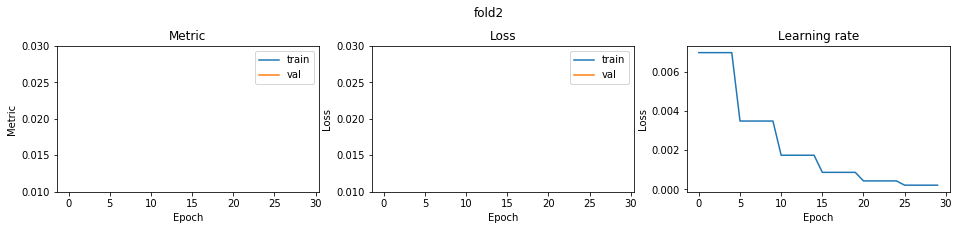

fold 3


epoch1 save best model... 0.03210303753207105
epoch6 save best model... 0.032088460866574006
epoch10 save best model... 0.03197762582255931
fold3 score: 0.0319776242869056


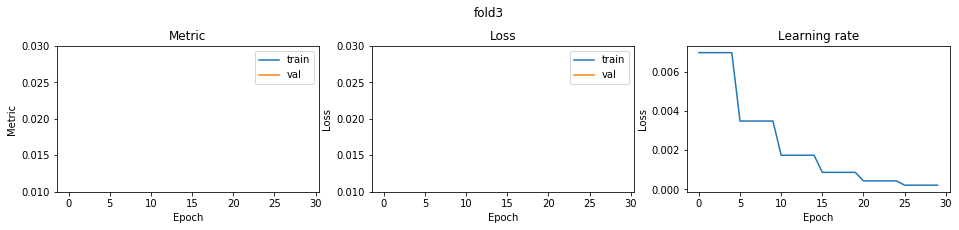

fold 4


epoch1 save best model... 0.0316432331724767
fold4 score: 0.0316432329045352


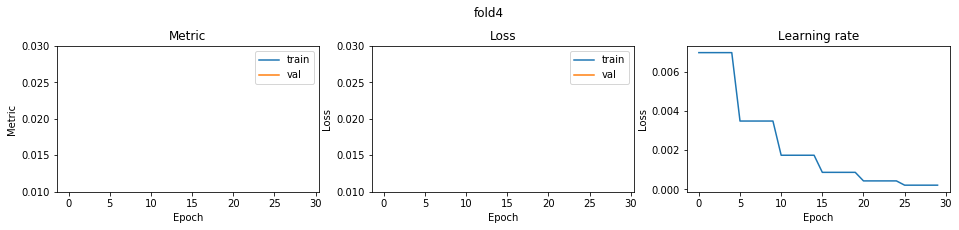

CV score: 0.031660509594101605

optimizer: RangerVA
fold 0


epoch1 save best model... 0.5341030567545011
epoch2 save best model... 0.05873881465922998
epoch3 save best model... 0.027744977311114517
epoch4 save best model... 0.02319393239847484
epoch5 save best model... 0.021781653019860556
epoch6 save best model... 0.02131554563879831
epoch7 save best model... 0.021051116891052567
epoch8 save best model... 0.020789818437706366
epoch9 save best model... 0.02057774462705321
epoch10 save best model... 0.020397980795464645
epoch11 save best model... 0.02036719921730238
epoch12 save best model... 0.020318516776610614
epoch13 save best model... 0.02020215455502068
epoch14 save best model... 0.020096727936679246
epoch15 save best model... 0.02004044627630765
epoch16 save best model... 0.020032969387014796
epoch17 save best model... 0.019971972436629286
epoch18 save best model... 0.019954981072752787
epoch19 save best model... 0.019897080092332358
epoch21 save best model... 0.019865175183853962
epoch22 save best model... 0.01986192466949955
epoch24 sav

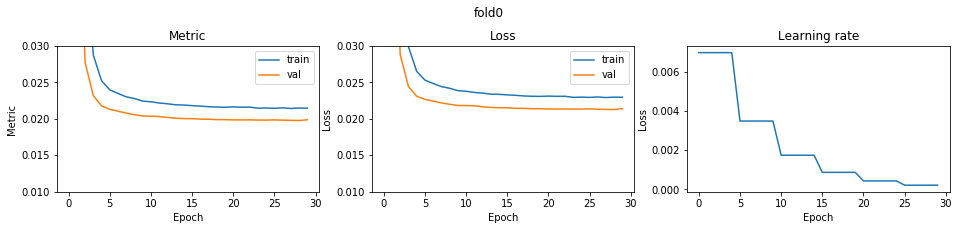

fold 1


epoch1 save best model... 0.5411678660320621
epoch2 save best model... 0.059996366765673485
epoch3 save best model... 0.02777528825966528
epoch4 save best model... 0.023241879417643538
epoch5 save best model... 0.021753303294139454
epoch6 save best model... 0.021374834097937126
epoch7 save best model... 0.021081554042427925
epoch8 save best model... 0.02085048411407322
epoch9 save best model... 0.020641306223800608
epoch10 save best model... 0.0204703814790797
epoch12 save best model... 0.02033270465532192
epoch13 save best model... 0.020259116417466305
epoch14 save best model... 0.02012483956023633
epoch16 save best model... 0.020075917405649887
epoch17 save best model... 0.020054849211400723
epoch19 save best model... 0.01997083676675507
epoch22 save best model... 0.019930190606839322
epoch24 save best model... 0.019918178652720234
epoch25 save best model... 0.019887751115600188
epoch26 save best model... 0.019865634664638518
fold1 score: 0.01986563452083606


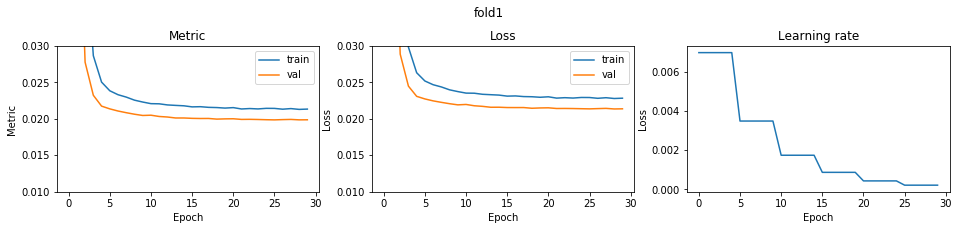

fold 2


epoch1 save best model... 0.5376991072665805
epoch2 save best model... 0.05908120265343
epoch3 save best model... 0.027763526076542186
epoch4 save best model... 0.023376731625971366
epoch5 save best model... 0.021848926399184076
epoch6 save best model... 0.02150966595848999
epoch7 save best model... 0.0211833702236088
epoch8 save best model... 0.02093180119448084
epoch9 save best model... 0.020805436808010745
epoch10 save best model... 0.020597993455849305
epoch11 save best model... 0.020509915663607166
epoch12 save best model... 0.020417921346951574
epoch13 save best model... 0.020417039239968817
epoch14 save best model... 0.020275718819177703
epoch15 save best model... 0.02022856880742424
epoch16 save best model... 0.0202070009383492
epoch17 save best model... 0.02018109453075172
epoch18 save best model... 0.02017221485486767
epoch19 save best model... 0.020105390106899698
epoch21 save best model... 0.02008761208114849
epoch22 save best model... 0.0200479523304024
epoch23 save best m

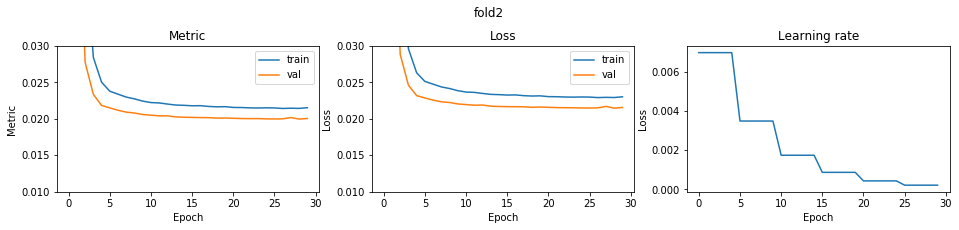

fold 3


epoch1 save best model... 0.5241409454910522
epoch2 save best model... 0.057208520683177784
epoch3 save best model... 0.02749300674113163
epoch4 save best model... 0.02336807536440721
epoch5 save best model... 0.02204012146181425
epoch6 save best model... 0.02151341107939126
epoch7 save best model... 0.02125458299757272
epoch8 save best model... 0.02103586796509921
epoch9 save best model... 0.020873994781616608
epoch10 save best model... 0.02074834146708725
epoch11 save best model... 0.020624426916954458
epoch12 save best model... 0.020592857952439703
epoch13 save best model... 0.02053567237116753
epoch14 save best model... 0.020455208330379126
epoch15 save best model... 0.02041746338188716
epoch16 save best model... 0.020353571028959915
epoch18 save best model... 0.02033458362144666
epoch19 save best model... 0.02028362640012098
epoch21 save best model... 0.020225996558038955
epoch24 save best model... 0.020225110915245526
epoch25 save best model... 0.020214532035273545
epoch26 save b

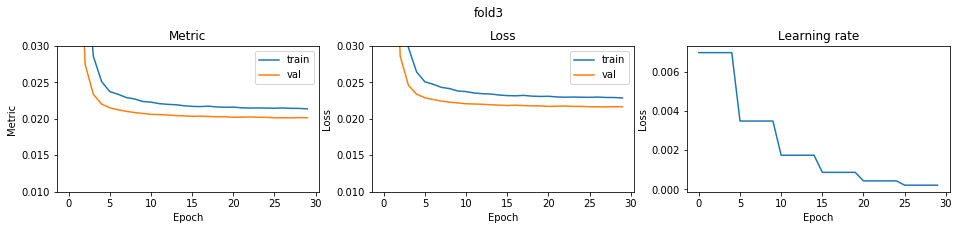

fold 4


epoch1 save best model... 0.53228230055481
epoch2 save best model... 0.05819294546181357
epoch3 save best model... 0.027110805509268286
epoch4 save best model... 0.022950230160375933
epoch5 save best model... 0.02167225918628632
epoch6 save best model... 0.02126461774246568
epoch7 save best model... 0.02097299505865248
epoch8 save best model... 0.02077459035131546
epoch9 save best model... 0.020544294007377093
epoch10 save best model... 0.020351893343625416
epoch11 save best model... 0.02029819650011209
epoch12 save best model... 0.020292446347365076
epoch13 save best model... 0.02016819253445079
epoch14 save best model... 0.0201305507586798
epoch16 save best model... 0.020054264945362044
epoch17 save best model... 0.020018853836932596
epoch19 save best model... 0.01996280366389382
epoch20 save best model... 0.01993105655922162
epoch21 save best model... 0.01990520623438315
epoch23 save best model... 0.019870207179549886
epoch24 save best model... 0.019864209450289164
epoch25 save best

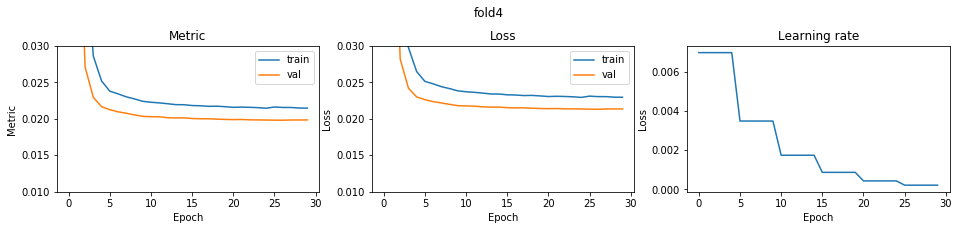

CV score: 0.019917435051478076

optimizer: SWATS
fold 0


epoch1 save best model... 0.031114464329559874
fold0 score: 0.031114464267957675


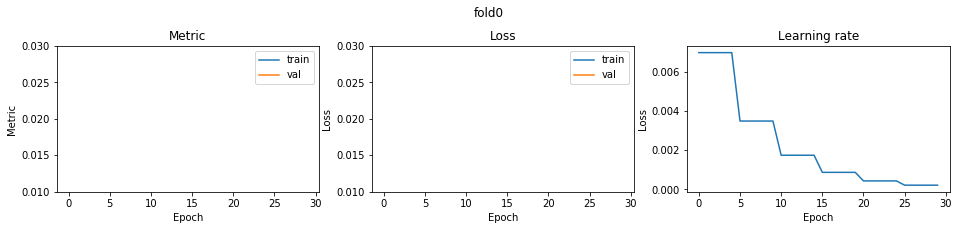

fold 1


epoch1 save best model... 0.03096112182483121
fold1 score: 0.030961121790154873


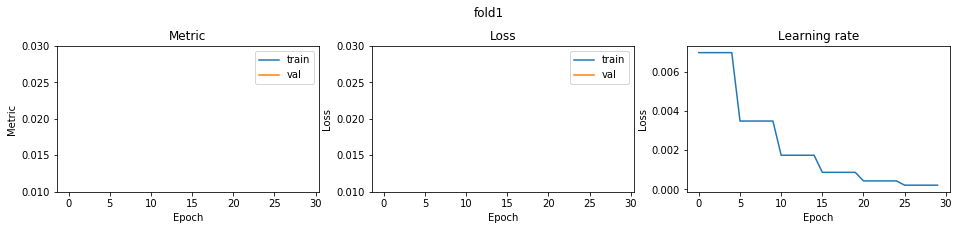

fold 2


epoch1 save best model... 0.031143150124915316
fold2 score: 0.031143150093055013


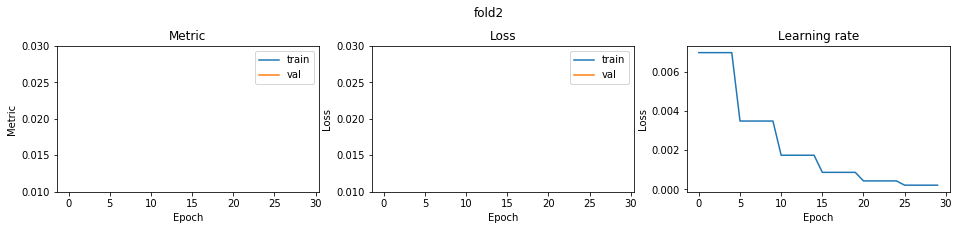

fold 3


epoch1 save best model... 0.031063105838886697
fold3 score: 0.031063105732937368


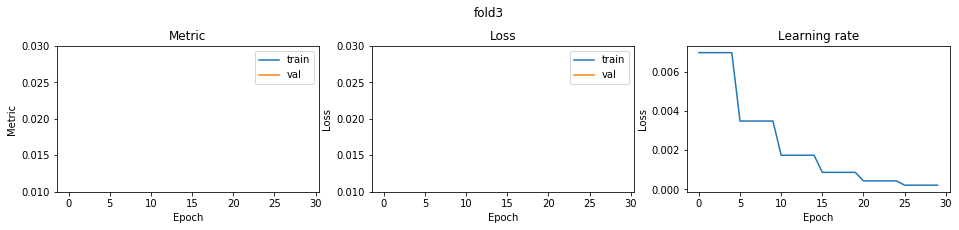

fold 4


epoch1 save best model... 0.03079692870972504
fold4 score: 0.030796928505008914


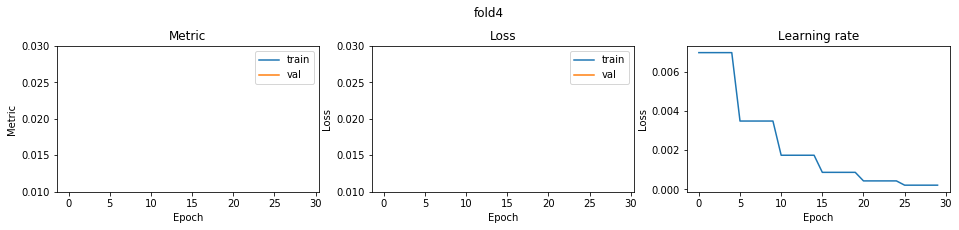

CV score: 0.031015750762544494

optimizer: Yogi
fold 0


epoch1 save best model... 0.031010195856451445
fold0 score: 0.031010195717106344


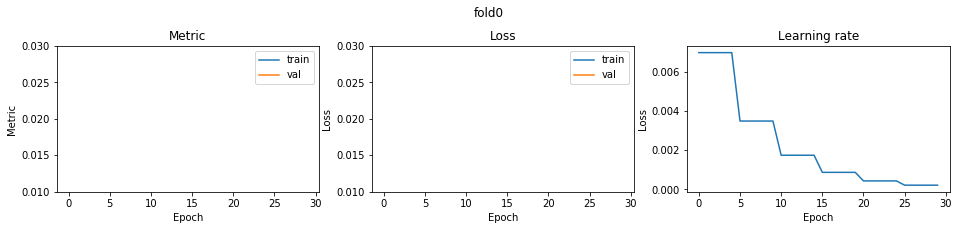

fold 1


epoch1 save best model... 0.03085473847381752
fold1 score: 0.030854738640295715


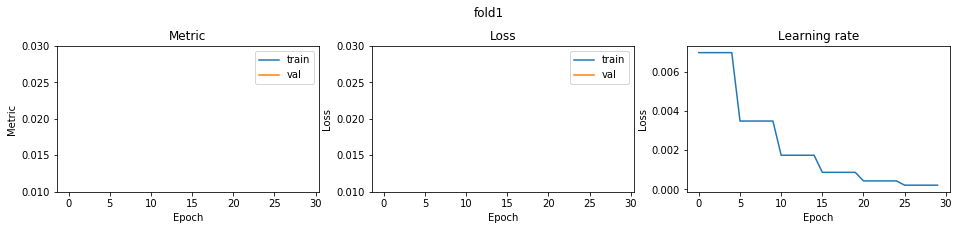

fold 2


epoch1 save best model... 0.031016398730097258
fold2 score: 0.031016398587571783


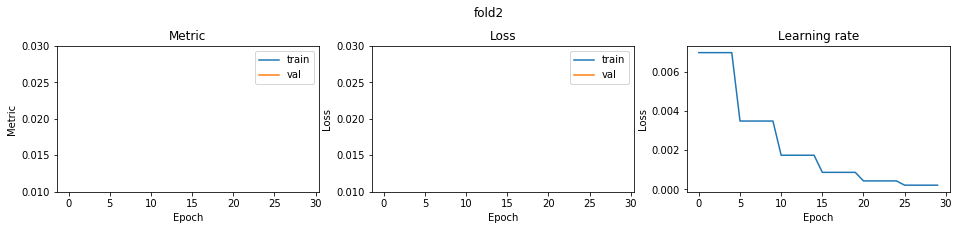

fold 3


epoch1 save best model... 0.031051056270311524
fold3 score: 0.031051056192036304


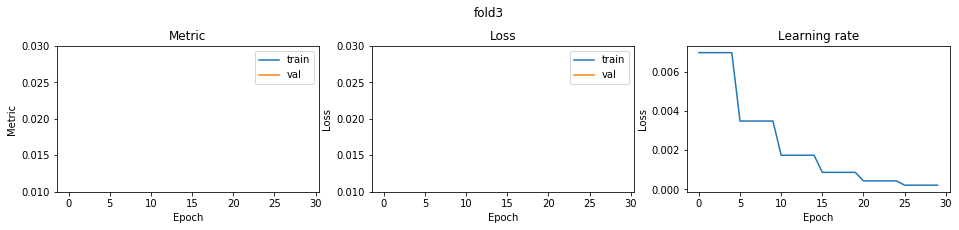

fold 4


epoch1 save best model... 0.030993465447038886
fold4 score: 0.030993465475698277


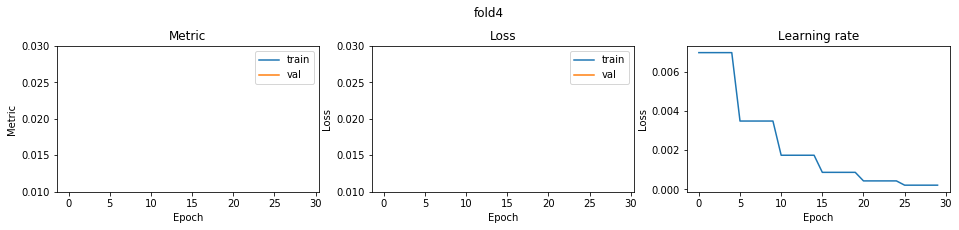

CV score: 0.030985175442526065

optimizer: Adam
fold 0


epoch1 save best model... 0.031946653128518875
epoch4 save best model... 0.03180088731704241
fold0 score: 0.03180088542550502


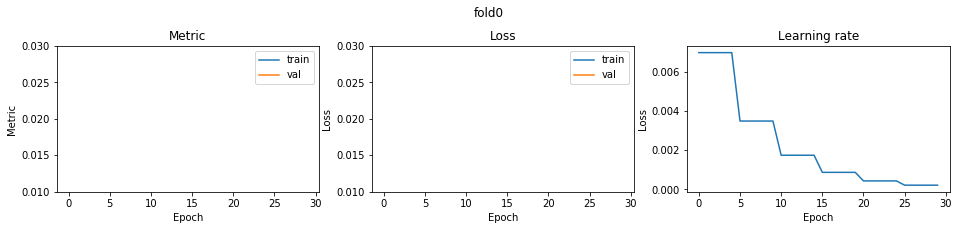

fold 1


epoch1 save best model... 0.031976906657830054
epoch13 save best model... 0.03189376908263005
epoch17 save best model... 0.031824337796826495
fold1 score: 0.03182433777493609


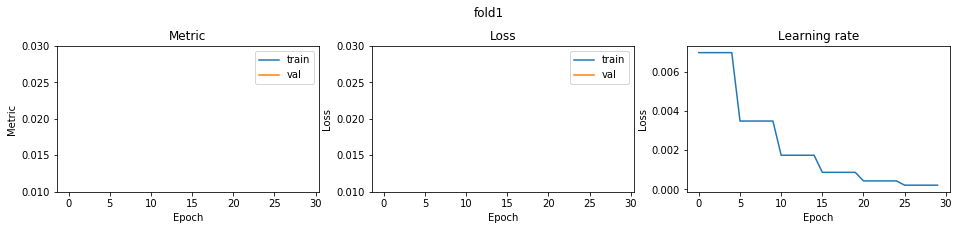

fold 2


epoch1 save best model... 0.031941081815895556
epoch8 save best model... 0.03174175789308564
epoch22 save best model... 0.03172840316915504
fold2 score: 0.031728404086259106


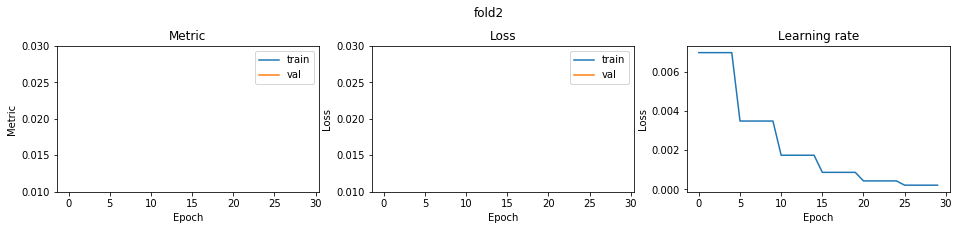

fold 3


epoch1 save best model... 0.03182400782127994
fold3 score: 0.03182400760504548


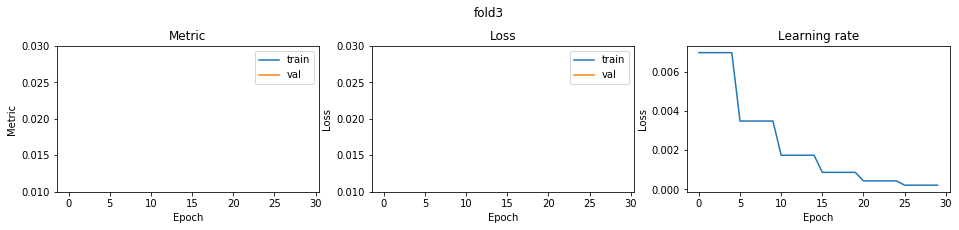

fold 4


epoch1 save best model... 0.03228572195985594
epoch4 save best model... 0.03167673763320495
epoch8 save best model... 0.03144285997592235
fold4 score: 0.03144285995527351


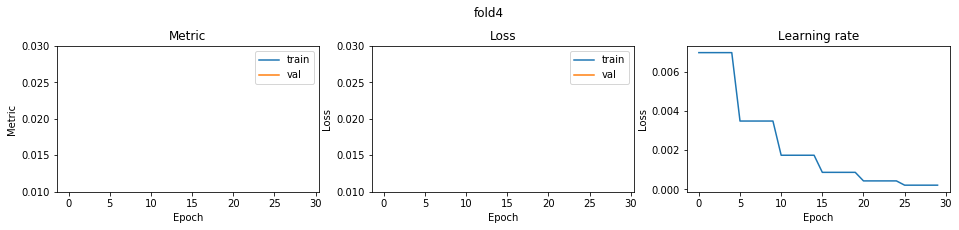

CV score: 0.03172409420614877

optimizer: LookaheadAdam
fold 0


epoch1 save best model... 0.031227423665633507
fold0 score: 0.031227423649614176


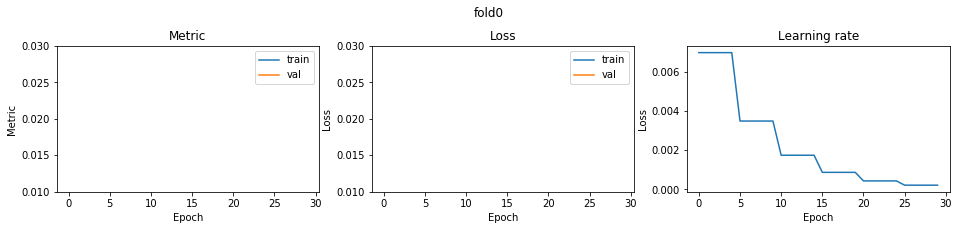

fold 1


epoch1 save best model... 0.03172166035000271
fold1 score: 0.03172166043849691


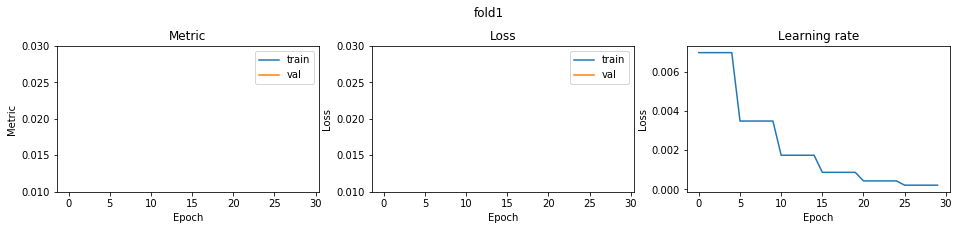

fold 2


epoch1 save best model... 0.031323804877194245
fold2 score: 0.0313238048708741


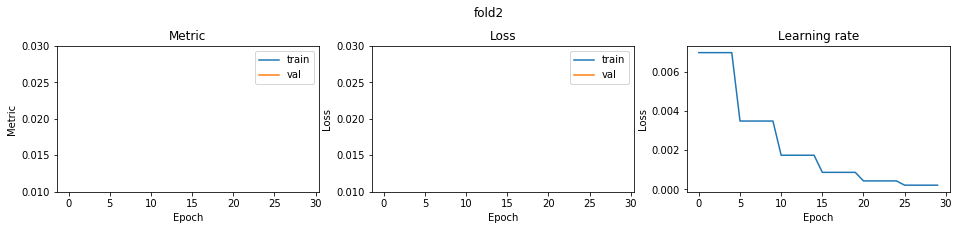

fold 3


epoch1 save best model... 0.03186426096954351
fold3 score: 0.03186426079441048


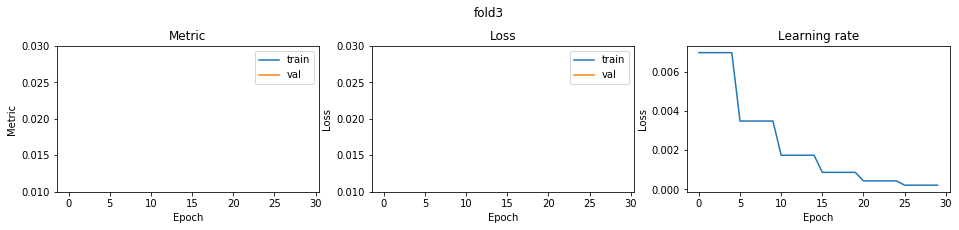

fold 4


epoch1 save best model... 0.03187326012022267
epoch10 save best model... 0.03176934680559912
epoch12 save best model... 0.0317467912098134
fold4 score: 0.0317467902754809


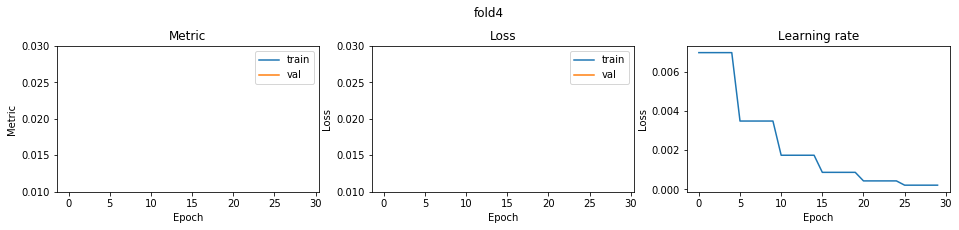

CV score: 0.03157679293154086

optimizer: LookaheadDiffGrad
fold 0


epoch1 save best model... 0.03395185788291462
epoch2 save best model... 0.03174128133913922
fold0 score: 0.03174128114471977


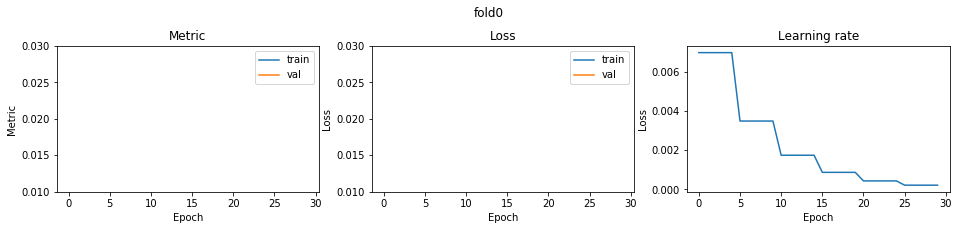

fold 1


epoch1 save best model... 0.03296978914536031
epoch2 save best model... 0.03128759857834974
fold1 score: 0.031287598632338806


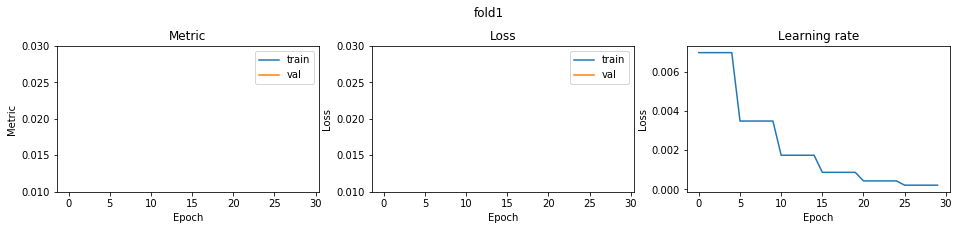

fold 2


epoch1 save best model... 0.03396926895904362
epoch2 save best model... 0.031147578418404237
fold2 score: 0.031147578459715657


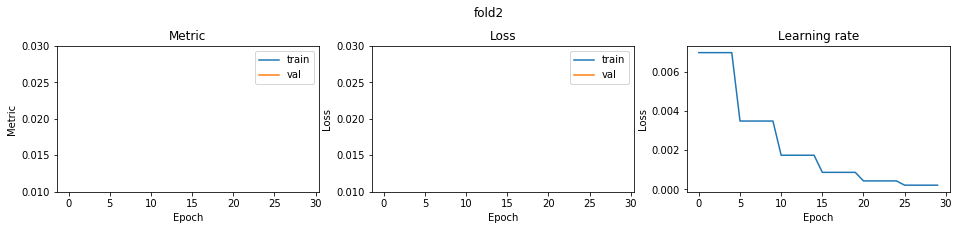

fold 3


epoch1 save best model... 0.03398074476909665
epoch2 save best model... 0.03162445981641022
fold3 score: 0.03162445973093959


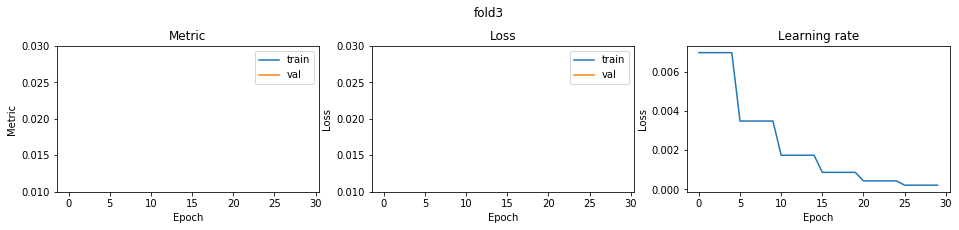

fold 4


epoch1 save best model... 0.0331178108005358
epoch2 save best model... 0.03141870557973352
fold4 score: 0.03141870530058832


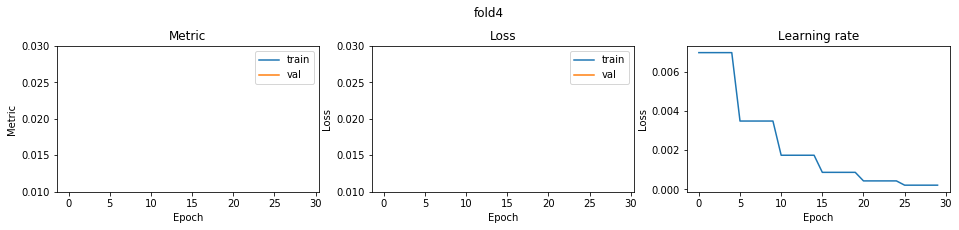

CV score: 0.03144394527841965

optimizer: LookaheadYogi
fold 0


epoch1 save best model... 0.03136042080446229
epoch2 save best model... 0.03089158297399725
fold0 score: 0.030891583046039634


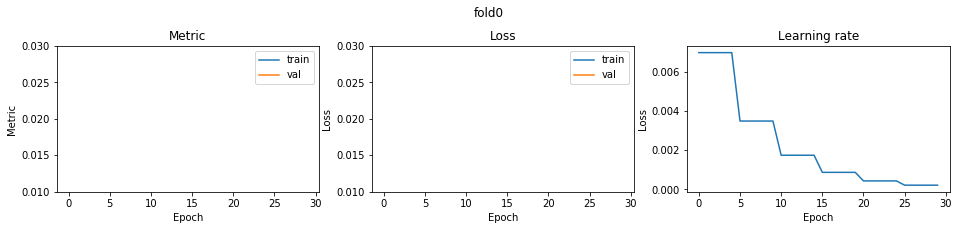

fold 1


epoch1 save best model... 0.03098092830297914
epoch2 save best model... 0.03092606855001692
fold1 score: 0.030926068440884615


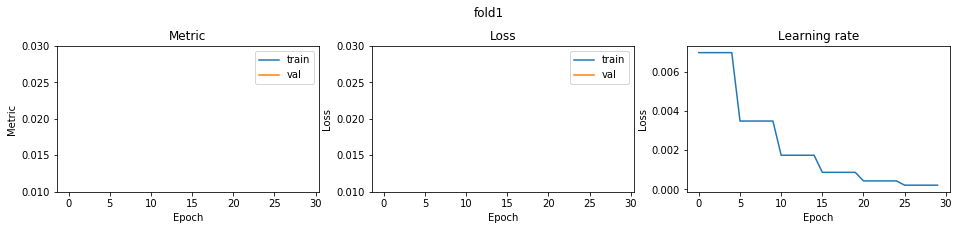

fold 2


epoch1 save best model... 0.03118274891042416
epoch2 save best model... 0.030999978582845186
fold2 score: 0.030999978632158018


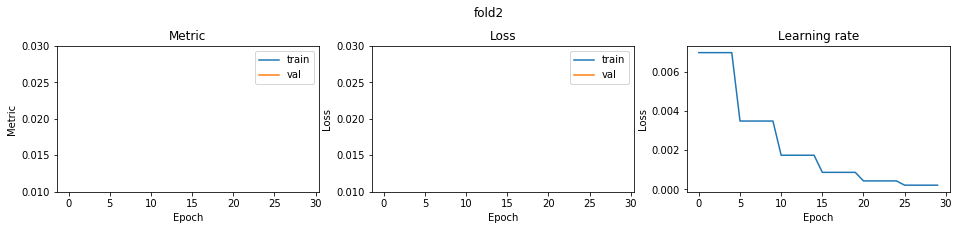

fold 3


epoch1 save best model... 0.03147116116670243
epoch2 save best model... 0.030948230729423515
fold3 score: 0.0309482307052983


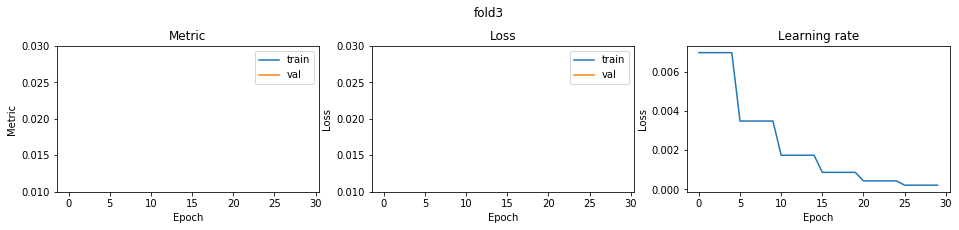

fold 4


epoch1 save best model... 0.031073060101386083
epoch2 save best model... 0.03075842983545502
fold4 score: 0.03075842986958592


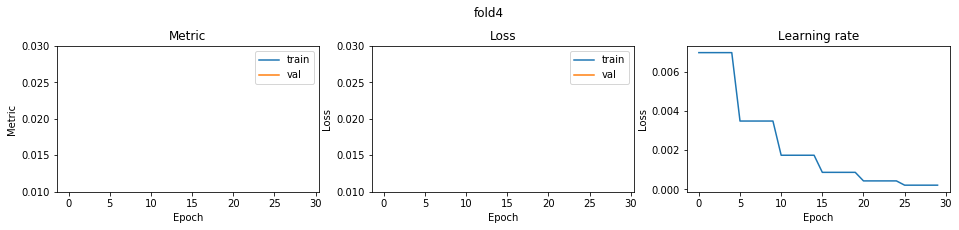

CV score: 0.030904852838501907


In [24]:
score_dict = {}

for optimizer in optim_list:
    CFG.optimizer = optimizer
    logger.info('')
    logger.info('optimizer: '+ optimizer.__name__)
    oof, predictions = run_kfold_nn(CFG,
                                    trn_df,
                                    test_df,
                                    CFG.feature_cols,
                                    CFG.target_cols,
                                    n_fold=5)

    # OOF score without 'ctl_vehicle'
    ys = trn_df[y_keys]
    preds = oof

    score = compute_metric(preds, ys)
    score_dict[optimizer.__name__] = score

In [25]:
logger.info(pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(score_dict, columns=['metric'], orient='index')

                     metric
Adam_CG            0.031788
AdamW_CG           0.016370
PlainRAdam_CG      0.150609
RAdam_CG           0.016369
Ranger_CG          0.016333
AggMo              0.030035
Apollo             0.627587
PID                0.628133
QHM                0.629704
SGDP               0.628969
SGDW               0.519621
SGD                0.630827
AdaBelief          0.016418
AdaBound           0.030464
AdaMod             0.016363
AdamW              0.016387
AdamP              0.016386
DiffGrad           0.031700
Lamb               0.016379
NovoGrad           0.016261
PlainRAdam         0.016386
QHAdam             0.031850
RAdam              0.016376
Ranger             0.016306
RangerQH           0.031661
RangerVA           0.019917
SWATS              0.031016
Yogi               0.030985
Adam               0.031724
LookaheadAdam      0.031577
LookaheadDiffGrad  0.031444
LookaheadYogi      0.030905


metric
Adam_CG            0.031788
AdamW_CG           0.016370
PlainRAdam_CG      0.150609
RAdam_CG           0.016369
Ranger_CG          0.016333
AggMo              0.030035
Apollo             0.627587
PID                0.628133
QHM                0.629704
SGDP               0.628969
SGDW               0.519621
SGD                0.630827
AdaBelief          0.016418
AdaBound           0.030464
AdaMod             0.016363
AdamW              0.016387
AdamP              0.016386
DiffGrad           0.031700
Lamb               0.016379
NovoGrad           0.016261
PlainRAdam         0.016386
QHAdam             0.031850
RAdam              0.016376
Ranger             0.016306
RangerQH           0.031661
RangerVA           0.019917
SWATS              0.031016
Yogi               0.030985
Adam               0.031724
LookaheadAdam      0.031577
LookaheadDiffGrad  0.031444
LookaheadYogi      0.030905

In [26]:
sort_dict = {k: v for k, v in sorted(score_dict.items(), key=lambda x: x[1])}
logger.info(pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index'))
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index')

                     metric
NovoGrad           0.016261
Ranger             0.016306
Ranger_CG          0.016333
AdaMod             0.016363
RAdam_CG           0.016369
AdamW_CG           0.016370
RAdam              0.016376
Lamb               0.016379
PlainRAdam         0.016386
AdamP              0.016386
AdamW              0.016387
AdaBelief          0.016418
RangerVA           0.019917
AggMo              0.030035
AdaBound           0.030464
LookaheadYogi      0.030905
Yogi               0.030985
SWATS              0.031016
LookaheadDiffGrad  0.031444
LookaheadAdam      0.031577
RangerQH           0.031661
DiffGrad           0.031700
Adam               0.031724
Adam_CG            0.031788
QHAdam             0.031850
PlainRAdam_CG      0.150609
SGDW               0.519621
Apollo             0.627587
PID                0.628133
SGDP               0.628969
QHM                0.629704
SGD                0.630827


metric
NovoGrad           0.016261
Ranger             0.016306
Ranger_CG          0.016333
AdaMod             0.016363
RAdam_CG           0.016369
AdamW_CG           0.016370
RAdam              0.016376
Lamb               0.016379
PlainRAdam         0.016386
AdamP              0.016386
AdamW              0.016387
AdaBelief          0.016418
RangerVA           0.019917
AggMo              0.030035
AdaBound           0.030464
LookaheadYogi      0.030905
Yogi               0.030985
SWATS              0.031016
LookaheadDiffGrad  0.031444
LookaheadAdam      0.031577
RangerQH           0.031661
DiffGrad           0.031700
Adam               0.031724
Adam_CG            0.031788
QHAdam             0.031850
PlainRAdam_CG      0.150609
SGDW               0.519621
Apollo             0.627587
PID                0.628133
SGDP               0.628969
QHM                0.629704
SGD                0.630827

In [27]:
pd.DataFrame.from_dict(sort_dict, columns=['metric'], orient='index').to_csv(nb_name[:-6]+'.csv')